<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

# NIRSpec IFU Pipeline Notebook

**Authors**: Kayli Glidic (kglidic@stsci.edu), Maria Pena-Guerrero (pena@stsci.edu), Leonardo Ubeda (lubeda@stsci.edu); NIRSpec branch<br>
**Last Updated**: April 16, 2025 </br>
**Pipeline Version**: 1.18.0 (Build 11.3, Context jwst_1364.pmap)

**Purpose**:<br>
End-to-end calibration with the James Webb Space Telescope (JWST) pipeline is divided into three main processing stages. This notebook provides a framework for processing generic Near-Infrared Spectrograph (NIRSpec) integral field unit (IFU) data through [stages 1-3 of the JWST pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing#gsc.tab=0), including how to use associations for multi-exposure observations and how to interact and work with JWST datamodels. Data is assumed to be organized into two folders: science and background, as specified in the paths set up below. In most cases, editing cells outside the [Configuration](#1.-Configuration) section is unnecessary unless the standard pipeline processing options or plot parameters need to be modified.

**[Data](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))**:<br>
This notebook is set up to use observations of Tarantula Nebula with the G140H, G235H, and G395H grisms obtained by Proposal ID (PID) 2729, Observation 5. This observation has a CYCLING dither pattern with 8 points. These observations do not include nods or background. The demo data will automatically download unless disabled (i.e., to use local files instead).

**[JWST pipeline version and CRDS context](#Set-CRDS-Context-and-Server)**:<br>
This notebook was written for the above-specified pipeline version and associated build context for this version of the JWST Calibration Pipeline. Information about this and other contexts can be found in the JWST Calibration Reference Data System (CRDS [server](https://jwst-crds.stsci.edu/)). If you use different pipeline versions, please refer to the table [here](https://jwst-crds.stsci.edu/display_build_contexts/) to determine what context to use. To learn more about the differences for the pipeline, read the relevant [documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/jwst-operations-pipeline-build-information#references).<br>

Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and [associated CRDS context](https://jwst-crds.stsci.edu/display_build_contexts/), taking advantage of bug fixes and algorithm improvements.**
Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-ifu-known-issues#gsc.tab=0) for this build are noted in the notebook.

**Updates**:<br>
This notebook is regularly updated to incorporate the latest pipeline improvements. Find the most up-to-date version of this notebook [here](https://github.com/spacetelescope/jwst-pipeline-notebooks/).

**Recent Changes**:</br>
* October 15, 2024: Converted notebook to follow standard template. </br>
* November 4, 2024: Notebook updated to JWST pipeline version 1.16.0 (Build 11.1).
* January 7, 2025: Add handling for background and CRDS.
* February 7, 2025: Always construct associations within this notebook, generalize plotting.
* April 16, 2025: Notebook updated to JWST pipeline version 1.18.0 (Build 11.3) and added Jdaviz plotting options.


---

## Table of Contents
* [1. Configuration](#1.-Configuration)
* [2. Package Imports](#2.-Package-Imports)
* [3. Demo Mode Setup](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
* [4. Directory Setup](#4.-Directory-Setup)
* [5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)](#5.-Stage-1:-Detector1Pipeline-(calwebb_detector1))
    * [5.1 Configure `Detector1Pipeline`](#5.1-Configure-Detector1Pipeline)
    * [5.2 Run `Detector1Pipeline`](#5.2-Run-Detector1Pipeline)
        * [5.2.1 Calibrating Science Files](#5.2.1-Calibrating-Science-Files)
        * [5.2.2 Calibrating Background Files](#5.2.2-Calibrating-Background-Files)
* [6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)](#5.-Stage-2:-Spec2Pipeline-(calwebb_spec2))
    * [6.1 Configure `Spec2Pipeline`](#6.1-Configure-Spec2Pipeline)
    * [6.2 Create `Spec2Pipeline` Association Files](#6.2-Create-Spec2Pipeline-Association-Files)
    * [6.3 Run `Spec2Pipeline`](#6.3-Run-Spec2Pipeline)
        * [6.3.1 Calibrating Science Files](#6.3.1-Calibrating-Science-Files)
        * [6.3.2 Calibrating Background Files](#6.3.2-Calibrating-Background-Files)
* [7. Stage 3: `Spec3Pipeline` (`calwebb_spec3`)](#5.-Stage-3:-Spec3Pipeline-(calwebb_spec3))
    * [7.1 Configure `Spec3Pipeline`](#7.1-Configure-Spec3Pipeline)
    * [7.2 Create `Spec3Pipeline` Association Files](#7.2-Create-Spec3Pipeline-Association-Files)
    * [7.3 Run `Spec3Pipeline`](#7.3-Run-Spec3Pipeline)
* [8. Visualize the Data](#8.-Visualize-the-Data)
    * [8.1 Display `Detector1Pipeline` Products](#8.1-Display-Detector1Pipeline-Products)
    * [8.2 Display `Spec3Pipeline` Products](#8.2-Display-Spec3Pipeline-Products)
* [9. Modifying the EXTRACT1D Reference File (as needed)](#9.-Modifying-the-EXTRACT1D-Reference-File-(as-needed))

---

## 1. Configuration
#### Install dependencies and parameters
To make sure that the pipeline version is compatible with the steps discussed below and that the required dependencies and packages get installed, you can create a fresh Conda environment and install the provided requirements.txt file before starting this notebook:

    conda create -n nirspec_ifu_pipeline python=3.12
    conda activate nirspec_ifu_pipeline
    pip install -r requirements.txt

Set the basic parameters to configure the notebook. These parameters determine what data gets used, where data is located (if already on disk), and the type of background subtraction (if any). The list of parameters includes:<br>

* `demo_mode`:
    * `True`: Downloads example data from the [Barbara A. Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) and processes it through the pipeline. All processing will occur in a local directory unless modified in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below.
    * `False`: Process your own downloaded data; provide its location. <br><br>
* **Directories with data**:
    * `sci_dir`: Directory where science observation data is stored.
    * `bg_dir`: Directory where background observation data is stored. <br><br>

* **[Backgroud subtraction methods](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-strategies/nirspec-background-recommended-strategies#gsc.tab=0)** (`True` = run, `False` = skip):
    * `master_bg`: Apply master-background subtraction in `calwebb_spec3`? Uses dedicated background observations.
    * `pixel_bg`: Apply pixel-to-pixel background subtraction in `calwebb_spec2`? This is the default pipeline setting. Uses noded observations.<br><br>

In [1]:
# Basic import necessary for configuration.
# Uncomment logging to hide log information.

import os
import warnings
#import logging

# Control logging level: INFO, WARNING, ERROR
# Run command loging.disable if want to hide logging
# ERROR messages.
#logging.disable(logging.ERROR)
warnings.simplefilter("ignore", RuntimeWarning)

<div class="alert alert-block alert-warning">
    
Note that `demo_mode` must be set appropriately below.
</div>

In [2]:
# Set parameters for demo_mode, data mode directories, and processing steps.

# -------------------------------DEMO MODE-----------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# ----------------------------User Mode Directories--------------------------
else:  # If demo_mode = False, look for user data in these paths.

    # Set directory paths for processing specific data; adjust to your local
    # directory setup (examples provided below).
    basedir = os.path.abspath(os.path.join(os.getcwd(), ''))

    # Directory to science observation data; expects uncalibrated data in
    # sci_dir/uncal/ and results in stage1, stage2, and stage3 directories.
    sci_dir = os.path.join(basedir, 'ifu_data_02729/Obs005', '')

    # Directory to dedicated background observation data; expects uncalibrated data in
    # bg_dir/uncal/ and results in stage1, stage2, and stage3 directories.
    # bg_dir = os.path.join(basedir, 'ifu_data_02729/Obs002', '')
    bg_dir = ''  # If no dedicated background observation, use an empty string.

# ---------------------------Set Processing Steps----------------------------
# Individual pipeline stages can be turned on/off here. Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Science processing.
dodet1 = True  # calwebb_detector1
dospec2 = True  # calwebb_spec2
dospec3 = True  # calwebb_spec3
doviz = True  # Visualize calwebb outputs

# Dedicated Background Processing
dodet1bg = False  # calwebb_detector1
dospec2bg = False  # calwebb_spec2 (needed for Master Background subtraction)

# How should background subtraction be done?
# Dedicated backgrounds can either use master or pixel-based subtraction
# Nodded backgrounds can use only pixel-based subtraction
# If none are selected, data will not be background subtracted.
master_bg = False  # Master-background subtraction in spec3.
pixel_bg = False  # Pixel-based background subtraction in spec2.

Running in demonstration mode using online example data!


---

### Set CRDS Context and Server
Before importing `CRDS` and `JWST` modules, we need to configure our environment. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline. If the local CRDS cache directory has not been set, it will automatically be created in the home directory.<br><br>
[Build Context Table](https://jwst-crds.stsci.edu/display_build_contexts/)

In [3]:
# ------------------------Set CRDS context and paths------------------------
# Each version of the calibration pipeline is associated with a specific CRDS
# context file. The pipeline will select the appropriate context file behind
# the scenes while running. However, if you wish to override the default context
# file and run the pipeline with a different context, you can set that using
# the CRDS_CONTEXT environment variable. Here we show how this is done,
# although we leave the line commented out in order to use the default context.
# If you wish to specify a different context, uncomment the line below.
# os.environ['CRDS_CONTEXT'] = 'jwst_1364.pmap'  # CRDS context for 1.18.0

# Set CRDS cache directory to user home if not already set.
if os.getenv('CRDS_PATH') is None:
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds_cache')

# Check whether the CRDS server URL has been set. If not, set it.
if os.getenv('CRDS_SERVER_URL') is None:
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Output the current CRDS path and server URL in use.
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS local filepath: /home/runner/crds_cache
CRDS file server: https://jwst-crds.stsci.edu


---

## 2. Package Imports


In [4]:
# Use the entire available screen width for this notebook.
from IPython.display import display, HTML, JSON
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# ----------------------General Imports----------------------
import time
import copy
import json
import glob
import asdf
import itertools
import numpy as np
from pprint import pprint

# ----------------------Astropy Imports----------------------
# Astropy utilities for opening FITS files, downloading demo files, etc.
from astropy.io import fits
from astropy.stats import sigma_clip
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch
from astropy.visualization import LinearStretch, AsinhStretch, simple_norm

# -------------------- Astroquery Imports ----------------------
from astroquery.mast import Observations

# ----------------------Plotting Imports---------------------
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.collections import PatchCollection
from jdaviz import Cubeviz, Specviz
from specutils import Spectrum1D

<div class="alert alert-block alert-info">

Installation instructions for the JWST pipeline found here: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io) •
[Github](https://github.com/spacetelescope/jwst)

</div>

In [6]:
# ----------------------JWST Calibration Pipeline Imports----------------------
import jwst  # Import the base JWST and CRDS packages.
import crds
from crds.client import api
from stpipe import crds_client

# JWST pipelines (each encompassing many steps).
from jwst.pipeline import Detector1Pipeline  # calwebb_detector1
from jwst.pipeline import Spec2Pipeline  # calwebb_spec2
from jwst.pipeline import Spec3Pipeline  # calwebb_spec3
from jwst.extract_1d import Extract1dStep  # Extract1D Step

# JWST pipeline utilities
from jwst import datamodels  # JWST pipeline utilities: datamodels.
from jwst.associations import asn_from_list as afl  # Tools for creating association files.
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase  # Define Lvl2 ASN.
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base  # Define Lvl3 ASN.

# Check the default context for the Pipeline version
default_context = crds.get_default_context('jwst', state='build')
print("JWST Calibration Pipeline Version = {}".format(jwst.__version__))
print(f"Default CRDS Context for JWST Version {jwst.__version__}: {default_context}")
print(f"Using CRDS Context: {os.environ.get('CRDS_CONTEXT', default_context)}")

CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.18.0.dist-info)


JWST Calibration Pipeline Version = 1.18.0
Default CRDS Context for JWST Version 1.18.0: jwst_1364.pmap
Using CRDS Context: jwst_1364.pmap


---

### Define Convience Functions

Define a function that filters files based on detector, filter, and grating.

In [7]:
def get_matching(files, detector, filt, grating, exp_type):
    """
    Filters a list of FITS files to find those with matching 
    detector, filter, and grating for a specified exposure type.

    Parameters
    ----------
    files : list of str
        Paths to FITS files to check.
    detector : str
        Expected value of the DETECTOR keyword.
    filt : str
        Expected value of the FILTER keyword.
    grating : str
        Expected value of the GRATING keyword.
    exp_type : str, optional
        The exposure type to match.

    Returns
    -------
    files_regular : list of str
        Files with matching configuration and IS_IMPRT == False or missing.
    files_imprint : list of str)
        Files with matching configuration and IS_IMPRT == True.
    """
    files_regular, files_imprint = [], []
    for file in files:
        # Skip if EXP_TYPE doesn't match the provided one.
        if fits.getval(file, 'EXP_TYPE') != exp_type:
            files_regular.append(file)
            continue
        # Check if DETECTOR, FILTER, and GRATING match
        detector_match = fits.getval(file, 'DETECTOR') == detector
        filter_match = fits.getval(file, 'FILTER') == filt
        grating_match = fits.getval(file, 'GRATING') == grating
        if detector_match and filter_match and grating_match:
            # Only IFU and MOS observations have imprint exposures.
            try:
                is_imprt = fits.getval(file, 'IS_IMPRT')
            except KeyError:
                is_imprt = None
            (files_imprint if is_imprt else files_regular).append(file)
    return files_regular, files_imprint

Define a function that checks the grating wheel tilt value between two files.

In [8]:
def match_gwa(file1, file2):
    """
    Check if GWA tilt values match closely enough to be associated.

    Parameters
    ----------
    file1, file2 : str 
        Input exposures FITS file paths.

    Returns
    -------
    True if both GWA tilt values match within tolerance, else False.
    """
    hdr1, hdr2 = fits.getheader(file1), fits.getheader(file2)
    return np.allclose(
        (hdr1['GWA_XTIL'], hdr1['GWA_YTIL']),
        (hdr2['GWA_XTIL'], hdr2['GWA_YTIL']),
        atol=1e-8, rtol=0
    )

In [9]:
# Start a timer to keep track of runtime.
time0 = time.perf_counter()

---
## 3. Demo Mode Setup (ignore if not using demo data)
<div class="alert alert-block alert-info">

The data in this notebook is public and does not require a token. For other data sets, you may need to provide a token. For more infomation visit the
[astroquery](https://astroquery.readthedocs.io/en/latest/index.html) documentation.

</div>


If running in demonstration mode, set up the program information to retrieve the uncalibrated data (`_uncal.fits`) automatically from MAST using `astroquery`. MAST provides flexibility by allowing searches based on proposal ID and observation ID, rather than relying solely on filenames. More information about the JWST file naming conventions can be found [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html).

The IFU demo data in this notebook is from the [Early Release Science (ERS) Proposal ID 2729](https://www.stsci.edu/jwst/science-execution/program-information?id=2729) and features observations of the Tarantula Nebula (extended source) using multiple grisms. The program setup is briefly summarized in the table below.

| Demo Target: Tarantula Nebula | | |
|:-----------:|:-------:|:---:|
| Proposal ID | 02729 | Program number |
| OBSERVTN | 005 | Observation number |
| [GRATING/FILTER](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-modes/nirspec-ifu-spectroscopy) | G140H/F100LP | λ: 0.97–1.89 μm (a medium resolution, R ~ 1000) |
|                | G235H/F170LP | λ: 1.66–3.17 μm (a high resolution, R ~ 2700) |
|                | G395H/F290LP | λ: 2.87–5.27 μm (a high resolution, R ~ 2700) |
| SUBARRAY | SUBS200A1 | Subarray used |
| NINTS | 2 | Number of integrations in exposure |
| NGROUPS | 30 | Number of groups in integration |
|   DURATION  | 87.533 [s] | Total duration of one exposure |
|   READPATT  | NRSIRS2RAPID | Readout Pattern |
|   PATTTYPE  | CYCLING | Primary dither pattern type |
|   PATTSIZE  | LARGE | Primary dither pattern size (1.0" extent) |
|   NUMDTHPT  | 8 | Total number of points in pattern |
|   SRCTYAPT  | UNKNOWN | Source Type selected in APT |

> **Note:** The presence of a physical gap between detectors affects high-resolution IFU observations because the spectra are long enough to span both NIRSpec detectors. When using the grating-filter combination G140H/F070LP (or PRISM/CLEAR) the resulting spectra do not have any gaps because the spectra do not extend beyond NRS1. [More Info ...](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-operations/nirspec-ifu-operations/nirspec-ifu-wavelength-ranges-and-gaps#NIRSpecIFUWavelengthRangesandGaps-Wavelengthgaps)

In [10]:
# Set up the program information and directories to collect
# the data in demo_mode.

if demo_mode:

    print('Running in demonstration mode. '
          'Example data will be downloaded from MAST!')

    # NOTE:
    # For non public data sets, you may need to provide a token.
    # However, for security it is not recommended to enter tokens into
    # a terminal or Jupyter notebook.
    #Observations.login(token="")

    # --------------Program and observation information--------------
    program = "02729"
    sci_observtn = "005"
    bg_observtn = None
    # Possible filter options ["F100LP;G140H","F170LP;G235H","F290LP;G395H"].
    # Limiting selection to one.
    filters = ["F290LP;G395H"]

    # ----------Define the base and observation directories----------
    basedir = os.path.abspath(os.path.join(os.getcwd(), ''))
    sci_dir = os.path.join(basedir, f'ifu_data_{program}')
    sci_dir = os.path.join(sci_dir, f'Obs{sci_observtn}')
    uncal_dir = os.path.join(sci_dir, 'uncal/')

    # If no background observation, leave blank.
    bg_dir = os.path.join(basedir, f'ifu_data_{program}')
    bg_dir = os.path.join(bg_dir, f'Obs{bg_observtn}') if bg_observtn else ''
    uncal_bgdir = os.path.join(bg_dir, 'uncal/') if bg_observtn else ''

    # ------Ensure directories for downloading MAST data exists------
    os.makedirs(uncal_dir, exist_ok=True)
    if bg_observtn:  # only if background observation is provided.
        os.makedirs(uncal_bgdir, exist_ok=True)

else:
    print('Running with user provided data.')

Running in demonstration mode. Example data will be downloaded from MAST!


Click on the following links to learn more about querying and downloading data:<br>
• [Downloading data](https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data)<br>
• [Observations Class](https://astroquery.readthedocs.io/en/latest/api/astroquery.mast.ObservationsClass.html)<br>
• [Products Field Descriptions](https://mast.stsci.edu/api/v0/_productsfields.html)<br><br>

Compile tables of files from MAST associated with the science (SCI) and, if applicable, background (BG) observations.

In [11]:
# Obtain a list of observation IDs for the specified demo program.

if demo_mode:
    # --------------------SCIENCE Observation--------------------
    sci_obs_id_table = Observations.query_criteria(instrument_name=['NIRSPEC/IFU'],
                                                   provenance_name=["CALJWST"],
                                                   obs_id=[f'*{program}*{sci_observtn}*'])

    # ------------------BACKGROUND Observation-------------------
    if bg_observtn:
        bg_obs_id_table = Observations.query_criteria(instrument_name=['NIRSPEC/IFU'],
                                                      provenance_name=["CALJWST"],
                                                      obs_id=[f'*{program}*{bg_observtn}*'])

Filter these tables to identify uncalibrated data from MAST.

The demo dataset consists of eight `_uncal.fits` files (per detector), each approximately 63 MB in size. 

In [12]:
# Convert visits into a list of uncalibrated data and ASN files.

if demo_mode:
    file_criteria = {'filters': filters, 'calib_level': [1],
                     'productSubGroupDescription': 'UNCAL'}

    # Initialize lists for science, background, and ASN files.
    sci_downloads, bg_downloads = [], []

    pfilter = Observations.filter_products  # Alias for filter_products method.

    # ----------Identify uncalibrated SCIENCE files associated with each visit----------
    for exposure in sci_obs_id_table:
        sci_products = Observations.get_product_list(exposure)

        # Filter for full-size science files (exclude smaller confirmation images).
        avg_sci_size = np.nanmean(sci_products['size'])
        sci_products = sci_products[sci_products['size'] > avg_sci_size]
        sci_downloads.extend(pfilter(sci_products, **file_criteria)['dataURI'])

    # Filter for full-size background files (exclude smaller confirmation images).
    if bg_observtn:
        for exposure in bg_obs_id_table:
            bg_products = Observations.get_product_list(exposure)

            avg_bg_size = np.nanmean(bg_products['size'])
            bg_products = bg_products[bg_products['size'] > avg_bg_size]
            bg_downloads.extend(pfilter(bg_products, **file_criteria)['dataURI'])

    # Filter out other observations and remove duplicates.
    sci_downloads = {f for f in sci_downloads if f"jw{program}{sci_observtn}" in f}

    if bg_observtn:
        bg_downloads = {f for f in bg_downloads if f"jw{program}{bg_observtn}" in f}
        print(f"Background files selected for downloading: {len(bg_downloads)}")
    else:
        print("Background files selected for downloading: 0")

    print(f"Science files selected for downloading: {len(sci_downloads)}")

Background files selected for downloading: 0
Science files selected for downloading: 16


Download the data. 

<div class="alert alert-block alert-warning">

**Warning**: If this notebook is halted during this step, the downloaded file may be incomplete, and cause crashes later on!
</div>

In [13]:
# Download data and place them into the appropriate directories.

if demo_mode:
    for file in sci_downloads:
        sci_manifest = Observations.download_file(file, local_path=uncal_dir)
    for file in bg_downloads:
        bg_manifest = Observations.download_file(file, local_path=uncal_bgdir)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


---
## 4. Directory Setup
Set up detailed paths to input/output stages here.

In [14]:
# Define/create output subdirectories to keep data products organized.

# -----------------------------Science Directories------------------------------
uncal_dir = os.path.join(sci_dir, 'uncal/')  # Uncalibrated pipeline inputs.
asn_dir = os.path.join(sci_dir, 'asn/')  # Association files.
det1_dir = os.path.join(sci_dir, 'stage1/')  # calwebb_detector1 pipeline outputs.
spec2_dir = os.path.join(sci_dir, 'stage2/')  # calwebb_spec2 pipeline outputs.
spec3_dir = os.path.join(sci_dir, 'stage3/')  # calwebb_spec3 pipeline outputs.

os.makedirs(asn_dir, exist_ok=True)
os.makedirs(det1_dir, exist_ok=True)
os.makedirs(spec2_dir, exist_ok=True)
os.makedirs(spec3_dir, exist_ok=True)

# ---------------------------Background Directories-----------------------------
uncal_bgdir = os.path.join(bg_dir, 'uncal/')  # Uncalibrated pipeline inputs.
asn_bgdir = os.path.join(bg_dir, 'asn/')  # Association files.
det1_bgdir = os.path.join(bg_dir, 'stage1/')  # calwebb_detector1 pipeline outputs.
spec2_bgdir = os.path.join(bg_dir, 'stage2/')  # calwebb_spec2 pipeline outputs.

if bg_dir:
    os.makedirs(asn_bgdir, exist_ok=True)
    os.makedirs(det1_bgdir, exist_ok=True)
    os.makedirs(spec2_bgdir, exist_ok=True)

In [15]:
# Print out the time benchmark.
time1 = time.perf_counter()
print(f"Runtime so far: {round((time1-time0)/60.0, 1):0.4f} min")

Runtime so far: 0.3000 min


---
## 5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)

In this section, we process the data through the `calwebb_detector1` pipeline to create Stage 1 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: Raw exposure (`_uncal.fits`) containing original data from all detector readouts (ncols x nrows x ngroups x nintegrations).
* **Output**: Uncalibrated countrate (slope) image in units of DN/s:
    * `_rate.fits`: A single countrate image averaged over multiple integrations (if available).
    * `_rateints.fits`: Countrate images for each integration, saved in multiple extensions.

The `Detector1Pipeline` applies basic detector-level corrections on a group-by-group basis, followed by ramp fitting for all exposure types, commonly referred to as "ramps-to-slopes" processing.

---

### 5.1 Configure `Detector1Pipeline`

The `Detector1Pipeline` has the following steps available for NIRSpec IFU:

* `group_scale` : Rescales pixel values to correct for improper onboard frame averaging.
* `dq_init` : Initializes the data quality (DQ) flags for the input data.
* `saturation` : Flags pixels at or below the A/D floor or above the saturation threshold.
* `superbias` : Subtracts the superbias reference file from the input data.
* `refpix` : Use reference pixels to correct bias drifts.
* `linearity` : Applies a correction for non-linear detector response.
* `dark_current` : Subtracts the dark current reference file from the input data.
* `jump` : Performs CR/jump detection on each ramp integration within an exposure.
* `clean_flicker_noise`: Removes flicker (1/f) noise from calibrated ramp images (similar to `nsclean` in spec2).
* `ramp_fit` : Determines the mean count rate (counts per second) for each pixel by performing a linear fit to the input data.
* `gain_scale` : Corrects pixel values for non-standard gain settings, primarily in NIRSpec subarray data.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html)

Below, we set up a dictionary that defines how the `Detector1Pipeline` should be configured for IFU data.

<div class="alert alert-warning">
  To override specific steps and reference files, use the examples below.
</div>

In [16]:
# Set up a dictionary to define how the Detector1 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['saturation'] = {}, {}, {}
det1dict['superbias'], det1dict['refpix'] = {}, {}
det1dict['linearity'], det1dict['dark_current'], det1dict['jump'] = {}, {}, {}
det1dict['clean_flicker_noise'], det1dict['ramp_fit'] = {}, {}
det1dict['gain_scale'] = {}

# ---------------------------Override reference files---------------------------
# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
#det1dict['dq_init']['override_mask'] = 'myfile.fits' # Bad pixel mask
#det1dict['superbias']['override_superbias'] = 'myfile.fits' # Bias subtraction
#det1dict['dark_current']['override_dark'] = 'myfile.fits' # Dark current subtraction

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
det1dict['linearity']['skip'] = False  # This is the default.

# Turn on multi-core processing for jump step (off by default).
# Choose what fraction of cores to use (quarter, half, or all).
det1dict['jump']['maximum_cores'] = 'half'

In [17]:
# Turn on detection of cosmic ray snowballs (on by default).
det1dict['jump']['expand_large_events'] = True
det1dict['jump']['expand_factor'] = 3  # (default 2).

<div class="alert alert-info">

Many exposures are affected by artifacts known as [snowballs](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/shower-and-snowball-artifacts#gsc.tab=0) caused by large cosmic ray events. These artifacts are particularly significant in deep exposures with long integration times, with an estimated rate of one snowball per detector (FULL FRAME) per 20 seconds. To expand the number of pixels flagged as jumps around large cosmic ray events, set `expand_large_events` to True. An `expand_factor` of 3 works well for NIRSpec observations to cover most snowballs.
</div>

In [18]:
# Turn on 1/f noise correction in Stage 1? (off by default).
#det1dict['clean_flicker_noise']['skip'] = False

<div class="alert alert-info">

JWST detector readout electronics (a.k.a. SIDECAR ASICs) generate significant 1/f noise during detector operations and signal digitization. This noise manifests as faint banding along the detector's slow axis and varies from column to column. For NIRSpec data, the primary pipeline algorithm to address 1/f noise is `nsclean` in the `Spec2Pipeline` (Rauscher 2023) but is off by default.

An additional 1/f noise-cleaning algorithm, `clean_flicker_noise`, has been implemented at the group stage in the `Detector1Pipeline`. This step is also off by default.
</div>

---
### 5.2 Run `Detector1Pipeline`

Run the science files and, if available, any background files through the `calwebb_detector1` pipeline using the `.call()` method.

We use `.call()` instead of `.run()` to ensure that the latest default parameters from CRDS are applied ([ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/stpipe/call_via_run.html)).

This stage takes approximately 14 minutes to process sixteen `_uncal.fits` files (~1 minutes per file) and generate `_rate.fits` files.

In [19]:
# Final list of UNCAL files ready for Stage 1 processing.
uncal_sci = sorted(glob.glob(uncal_dir + '*uncal.fits'))
print(f"Science UNCAL Files:\n{'-'*20}\n" + "\n".join(uncal_sci))

if bg_dir:
    uncal_bg = sorted(glob.glob(uncal_bgdir + '*uncal.fits'))
    print(f"Background UNCAL Files:\n{'-'*20}\n" + "\n".join(uncal_bg))

Science UNCAL Files:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00001_nrs1_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00001_nrs2_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00002_nrs1_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00002_nrs2_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00003_nrs1_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00003_nrs2_uncal.fits
/home/runn

In [20]:
time_det1 = time.perf_counter()  # Tracks runtime for Stage 1.

---

#### 5.2.1 Calibrating Science Files
Identify the input science files and execute the `calwebb_detector1` pipeline using the `call` method.

In [21]:
# Run Stage 1 pipeline on the science using the custom det1dict dictionary.
if dodet1:
    # --------------------------Science UNCAL files--------------------------
    for uncal_file in sorted(glob.glob(uncal_dir + '*uncal.fits')):
        print(f"Applying Stage 1 Corrections & Calibrations to: "
              f"{os.path.basename(uncal_file)}")

        det1_result = Detector1Pipeline.call(uncal_file,
                                             save_results=True,
                                             steps=det1dict,
                                             output_dir=det1_dir)
    print("Stage 1 has been completed for SCI data! \n")
else:
    print('Skipping Detector1 processing for SCI data.')

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00001_nrs1_uncal.fits


2025-05-12 19:41:07,240 - CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.18.0.dist-info)


2025-05-12 19:41:07,401 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 204 files) (0 / 741.0 K bytes)


2025-05-12 19:41:07,448 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_calver_0048.rmap    5.3 K bytes  (2 / 204 files) (694 / 741.0 K bytes)


2025-05-12 19:41:07,628 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_0047.imap      385 bytes  (3 / 204 files) (6.0 K / 741.0 K bytes)


2025-05-12 19:41:07,686 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 204 files) (6.4 K / 741.0 K bytes)


2025-05-12 19:41:07,748 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 204 files) (7.8 K / 741.0 K bytes)


2025-05-12 19:41:07,823 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_superbias_0079.rmap   36.0 K bytes  (6 / 204 files) (8.6 K / 741.0 K bytes)


2025-05-12 19:41:07,884 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_sirskernel_0001.rmap      630 bytes  (7 / 204 files) (44.6 K / 741.0 K bytes)


2025-05-12 19:41:07,972 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_sflat_0026.rmap   20.6 K bytes  (8 / 204 files) (45.3 K / 741.0 K bytes)


2025-05-12 19:41:08,029 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_saturation_0018.rmap    2.0 K bytes  (9 / 204 files) (65.9 K / 741.0 K bytes)


2025-05-12 19:41:08,077 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_refpix_0015.rmap    1.6 K bytes  (10 / 204 files) (67.9 K / 741.0 K bytes)


2025-05-12 19:41:08,225 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_readnoise_0025.rmap    2.6 K bytes  (11 / 204 files) (69.5 K / 741.0 K bytes)


2025-05-12 19:41:08,371 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pictureframe_0001.rmap      675 bytes  (12 / 204 files) (72.0 K / 741.0 K bytes)


2025-05-12 19:41:08,439 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_photom_0013.rmap      958 bytes  (13 / 204 files) (72.7 K / 741.0 K bytes)


2025-05-12 19:41:08,499 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pathloss_0008.rmap    1.2 K bytes  (14 / 204 files) (73.7 K / 741.0 K bytes)


2025-05-12 19:41:08,595 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-whitelightstep_0001.rmap      777 bytes  (15 / 204 files) (74.9 K / 741.0 K bytes)


2025-05-12 19:41:08,667 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0013.rmap    2.1 K bytes  (16 / 204 files) (75.6 K / 741.0 K bytes)


2025-05-12 19:41:08,715 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-resamplespecstep_0002.rmap      709 bytes  (17 / 204 files) (77.8 K / 741.0 K bytes)


2025-05-12 19:41:08,763 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-outlierdetectionstep_0005.rmap    1.1 K bytes  (18 / 204 files) (78.5 K / 741.0 K bytes)


2025-05-12 19:41:08,841 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-jumpstep_0005.rmap      810 bytes  (19 / 204 files) (79.6 K / 741.0 K bytes)


2025-05-12 19:41:08,887 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-image2pipeline_0008.rmap    1.0 K bytes  (20 / 204 files) (80.4 K / 741.0 K bytes)


2025-05-12 19:41:08,948 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-detector1pipeline_0003.rmap    1.1 K bytes  (21 / 204 files) (81.4 K / 741.0 K bytes)


2025-05-12 19:41:09,039 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-darkpipeline_0003.rmap      872 bytes  (22 / 204 files) (82.5 K / 741.0 K bytes)


2025-05-12 19:41:09,085 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-darkcurrentstep_0003.rmap    1.8 K bytes  (23 / 204 files) (83.4 K / 741.0 K bytes)


2025-05-12 19:41:09,154 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ote_0030.rmap    1.3 K bytes  (24 / 204 files) (85.2 K / 741.0 K bytes)


2025-05-12 19:41:09,211 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_msaoper_0016.rmap    1.5 K bytes  (25 / 204 files) (86.4 K / 741.0 K bytes)


2025-05-12 19:41:09,256 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_msa_0027.rmap    1.3 K bytes  (26 / 204 files) (87.9 K / 741.0 K bytes)


2025-05-12 19:41:09,305 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_mask_0043.rmap    3.5 K bytes  (27 / 204 files) (89.2 K / 741.0 K bytes)


2025-05-12 19:41:09,441 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (28 / 204 files) (92.7 K / 741.0 K bytes)


2025-05-12 19:41:09,488 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ipc_0006.rmap      876 bytes  (29 / 204 files) (94.3 K / 741.0 K bytes)


2025-05-12 19:41:09,625 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ifuslicer_0017.rmap    1.5 K bytes  (30 / 204 files) (95.2 K / 741.0 K bytes)


2025-05-12 19:41:09,687 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ifupost_0019.rmap    1.5 K bytes  (31 / 204 files) (96.7 K / 741.0 K bytes)


2025-05-12 19:41:09,733 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ifufore_0017.rmap    1.5 K bytes  (32 / 204 files) (98.2 K / 741.0 K bytes)


2025-05-12 19:41:09,790 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_gain_0023.rmap    1.8 K bytes  (33 / 204 files) (99.7 K / 741.0 K bytes)


2025-05-12 19:41:09,869 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_fpa_0028.rmap    1.3 K bytes  (34 / 204 files) (101.5 K / 741.0 K bytes)


2025-05-12 19:41:09,916 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_fore_0026.rmap    5.0 K bytes  (35 / 204 files) (102.7 K / 741.0 K bytes)


2025-05-12 19:41:09,963 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_flat_0015.rmap    3.8 K bytes  (36 / 204 files) (107.7 K / 741.0 K bytes)


2025-05-12 19:41:10,017 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_fflat_0026.rmap    7.2 K bytes  (37 / 204 files) (111.5 K / 741.0 K bytes)


2025-05-12 19:41:10,063 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_extract1d_0018.rmap    2.3 K bytes  (38 / 204 files) (118.7 K / 741.0 K bytes)


2025-05-12 19:41:10,162 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_disperser_0028.rmap    5.7 K bytes  (39 / 204 files) (121.0 K / 741.0 K bytes)


2025-05-12 19:41:10,274 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_dflat_0007.rmap    1.1 K bytes  (40 / 204 files) (126.7 K / 741.0 K bytes)


2025-05-12 19:41:10,333 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_dark_0074.rmap   34.2 K bytes  (41 / 204 files) (127.9 K / 741.0 K bytes)


2025-05-12 19:41:10,393 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_cubepar_0015.rmap      966 bytes  (42 / 204 files) (162.1 K / 741.0 K bytes)


2025-05-12 19:41:10,452 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_collimator_0026.rmap    1.3 K bytes  (43 / 204 files) (163.1 K / 741.0 K bytes)


2025-05-12 19:41:10,509 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_camera_0026.rmap    1.3 K bytes  (44 / 204 files) (164.4 K / 741.0 K bytes)


2025-05-12 19:41:10,559 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_barshadow_0007.rmap    1.8 K bytes  (45 / 204 files) (165.7 K / 741.0 K bytes)


2025-05-12 19:41:10,616 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_area_0018.rmap    6.3 K bytes  (46 / 204 files) (167.5 K / 741.0 K bytes)


2025-05-12 19:41:10,662 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_apcorr_0009.rmap    5.6 K bytes  (47 / 204 files) (173.8 K / 741.0 K bytes)


2025-05-12 19:41:10,708 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_0398.imap    5.8 K bytes  (48 / 204 files) (179.3 K / 741.0 K bytes)


2025-05-12 19:41:10,754 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_wfssbkg_0010.rmap    3.1 K bytes  (49 / 204 files) (185.1 K / 741.0 K bytes)


2025-05-12 19:41:10,813 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_wavelengthrange_0006.rmap      862 bytes  (50 / 204 files) (188.2 K / 741.0 K bytes)


2025-05-12 19:41:10,860 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (51 / 204 files) (189.1 K / 741.0 K bytes)


2025-05-12 19:41:10,907 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_trapdensity_0005.rmap      705 bytes  (52 / 204 files) (189.9 K / 741.0 K bytes)


2025-05-12 19:41:10,955 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_throughput_0005.rmap    1.3 K bytes  (53 / 204 files) (190.6 K / 741.0 K bytes)


2025-05-12 19:41:11,002 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_superbias_0030.rmap    7.4 K bytes  (54 / 204 files) (191.8 K / 741.0 K bytes)


2025-05-12 19:41:11,049 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_specwcs_0014.rmap    3.1 K bytes  (55 / 204 files) (199.2 K / 741.0 K bytes)


2025-05-12 19:41:11,099 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_specprofile_0008.rmap    2.4 K bytes  (56 / 204 files) (202.4 K / 741.0 K bytes)


2025-05-12 19:41:11,146 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_speckernel_0006.rmap    1.0 K bytes  (57 / 204 files) (204.7 K / 741.0 K bytes)


2025-05-12 19:41:11,194 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_sirskernel_0001.rmap      627 bytes  (58 / 204 files) (205.8 K / 741.0 K bytes)


2025-05-12 19:41:11,257 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_saturation_0015.rmap      829 bytes  (59 / 204 files) (206.4 K / 741.0 K bytes)


2025-05-12 19:41:11,304 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_readnoise_0011.rmap      987 bytes  (60 / 204 files) (207.2 K / 741.0 K bytes)


2025-05-12 19:41:11,351 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_photom_0036.rmap    1.3 K bytes  (61 / 204 files) (208.2 K / 741.0 K bytes)


2025-05-12 19:41:11,402 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_persat_0007.rmap      674 bytes  (62 / 204 files) (209.5 K / 741.0 K bytes)


2025-05-12 19:41:11,450 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pathloss_0003.rmap      758 bytes  (63 / 204 files) (210.1 K / 741.0 K bytes)


2025-05-12 19:41:11,497 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pastasoss_0004.rmap      818 bytes  (64 / 204 files) (210.9 K / 741.0 K bytes)


2025-05-12 19:41:11,557 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-undersamplecorrectionstep_0001.rmap      904 bytes  (65 / 204 files) (211.7 K / 741.0 K bytes)


2025-05-12 19:41:11,608 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-tweakregstep_0012.rmap    3.1 K bytes  (66 / 204 files) (212.6 K / 741.0 K bytes)


2025-05-12 19:41:11,655 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-spec2pipeline_0008.rmap      984 bytes  (67 / 204 files) (215.8 K / 741.0 K bytes)


2025-05-12 19:41:11,705 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-sourcecatalogstep_0002.rmap    2.3 K bytes  (68 / 204 files) (216.7 K / 741.0 K bytes)


2025-05-12 19:41:11,752 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-resamplestep_0002.rmap      687 bytes  (69 / 204 files) (219.1 K / 741.0 K bytes)


2025-05-12 19:41:11,801 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-outlierdetectionstep_0004.rmap    2.7 K bytes  (70 / 204 files) (219.7 K / 741.0 K bytes)


2025-05-12 19:41:11,863 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-jumpstep_0007.rmap    6.4 K bytes  (71 / 204 files) (222.4 K / 741.0 K bytes)


2025-05-12 19:41:11,910 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-image2pipeline_0005.rmap    1.0 K bytes  (72 / 204 files) (228.8 K / 741.0 K bytes)


2025-05-12 19:41:11,968 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-detector1pipeline_0002.rmap    1.0 K bytes  (73 / 204 files) (229.8 K / 741.0 K bytes)


2025-05-12 19:41:12,027 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-darkpipeline_0002.rmap      868 bytes  (74 / 204 files) (230.8 K / 741.0 K bytes)


2025-05-12 19:41:12,074 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-darkcurrentstep_0001.rmap      591 bytes  (75 / 204 files) (231.7 K / 741.0 K bytes)


2025-05-12 19:41:12,120 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-chargemigrationstep_0004.rmap    5.7 K bytes  (76 / 204 files) (232.3 K / 741.0 K bytes)


2025-05-12 19:41:12,194 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_nrm_0005.rmap      663 bytes  (77 / 204 files) (237.9 K / 741.0 K bytes)


2025-05-12 19:41:12,239 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_mask_0022.rmap    1.3 K bytes  (78 / 204 files) (238.6 K / 741.0 K bytes)


2025-05-12 19:41:12,288 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_linearity_0022.rmap      961 bytes  (79 / 204 files) (239.9 K / 741.0 K bytes)


2025-05-12 19:41:12,344 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_ipc_0007.rmap      651 bytes  (80 / 204 files) (240.9 K / 741.0 K bytes)


2025-05-12 19:41:12,392 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_gain_0011.rmap      797 bytes  (81 / 204 files) (241.5 K / 741.0 K bytes)


2025-05-12 19:41:12,438 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_flat_0023.rmap    5.9 K bytes  (82 / 204 files) (242.3 K / 741.0 K bytes)


2025-05-12 19:41:12,485 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_filteroffset_0010.rmap      853 bytes  (83 / 204 files) (248.2 K / 741.0 K bytes)


2025-05-12 19:41:12,531 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_extract1d_0007.rmap      905 bytes  (84 / 204 files) (249.0 K / 741.0 K bytes)


2025-05-12 19:41:12,578 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (85 / 204 files) (249.9 K / 741.0 K bytes)


2025-05-12 19:41:12,636 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_distortion_0025.rmap    3.4 K bytes  (86 / 204 files) (250.4 K / 741.0 K bytes)


2025-05-12 19:41:12,683 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_dark_0034.rmap    7.5 K bytes  (87 / 204 files) (253.9 K / 741.0 K bytes)


2025-05-12 19:41:12,732 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_bkg_0002.rmap    2.9 K bytes  (88 / 204 files) (261.4 K / 741.0 K bytes)


2025-05-12 19:41:12,780 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_area_0014.rmap    2.7 K bytes  (89 / 204 files) (264.3 K / 741.0 K bytes)


2025-05-12 19:41:12,825 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_apcorr_0010.rmap    4.3 K bytes  (90 / 204 files) (267.0 K / 741.0 K bytes)


2025-05-12 19:41:12,872 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_abvegaoffset_0004.rmap    1.4 K bytes  (91 / 204 files) (271.3 K / 741.0 K bytes)


2025-05-12 19:41:12,920 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_0272.imap    5.8 K bytes  (92 / 204 files) (272.7 K / 741.0 K bytes)


2025-05-12 19:41:12,972 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_wfssbkg_0004.rmap    7.2 K bytes  (93 / 204 files) (278.5 K / 741.0 K bytes)


2025-05-12 19:41:13,030 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_wavelengthrange_0010.rmap      996 bytes  (94 / 204 files) (285.7 K / 741.0 K bytes)


2025-05-12 19:41:13,088 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_tsophot_0003.rmap      896 bytes  (95 / 204 files) (286.7 K / 741.0 K bytes)


2025-05-12 19:41:13,146 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (96 / 204 files) (287.6 K / 741.0 K bytes)


2025-05-12 19:41:13,193 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (97 / 204 files) (289.2 K / 741.0 K bytes)


2025-05-12 19:41:13,240 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_superbias_0019.rmap   18.9 K bytes  (98 / 204 files) (290.8 K / 741.0 K bytes)


2025-05-12 19:41:13,300 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_specwcs_0022.rmap    7.1 K bytes  (99 / 204 files) (309.7 K / 741.0 K bytes)


2025-05-12 19:41:13,345 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_sirskernel_0002.rmap      671 bytes  (100 / 204 files) (316.8 K / 741.0 K bytes)


2025-05-12 19:41:13,392 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_saturation_0011.rmap    2.8 K bytes  (101 / 204 files) (317.5 K / 741.0 K bytes)


2025-05-12 19:41:13,438 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_readnoise_0026.rmap   25.9 K bytes  (102 / 204 files) (320.3 K / 741.0 K bytes)


2025-05-12 19:41:13,500 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_psfmask_0008.rmap   28.4 K bytes  (103 / 204 files) (346.2 K / 741.0 K bytes)


2025-05-12 19:41:13,558 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_photom_0028.rmap    3.4 K bytes  (104 / 204 files) (374.6 K / 741.0 K bytes)


2025-05-12 19:41:13,615 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_persat_0005.rmap    1.6 K bytes  (105 / 204 files) (377.9 K / 741.0 K bytes)


2025-05-12 19:41:13,676 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-whitelightstep_0004.rmap    2.0 K bytes  (106 / 204 files) (379.5 K / 741.0 K bytes)


2025-05-12 19:41:13,723 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap    4.5 K bytes  (107 / 204 files) (381.5 K / 741.0 K bytes)


2025-05-12 19:41:13,781 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-spec2pipeline_0008.rmap      984 bytes  (108 / 204 files) (386.0 K / 741.0 K bytes)


2025-05-12 19:41:13,826 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-sourcecatalogstep_0002.rmap    4.6 K bytes  (109 / 204 files) (387.0 K / 741.0 K bytes)


2025-05-12 19:41:13,874 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-resamplestep_0002.rmap      687 bytes  (110 / 204 files) (391.6 K / 741.0 K bytes)


2025-05-12 19:41:13,938 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-outlierdetectionstep_0003.rmap      940 bytes  (111 / 204 files) (392.3 K / 741.0 K bytes)


2025-05-12 19:41:13,985 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-jumpstep_0005.rmap      806 bytes  (112 / 204 files) (393.2 K / 741.0 K bytes)


2025-05-12 19:41:14,031 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-image2pipeline_0004.rmap    1.1 K bytes  (113 / 204 files) (394.0 K / 741.0 K bytes)


2025-05-12 19:41:14,080 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-detector1pipeline_0005.rmap    1.3 K bytes  (114 / 204 files) (395.2 K / 741.0 K bytes)


2025-05-12 19:41:14,139 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-darkpipeline_0002.rmap      868 bytes  (115 / 204 files) (396.4 K / 741.0 K bytes)


2025-05-12 19:41:14,185 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-darkcurrentstep_0001.rmap      618 bytes  (116 / 204 files) (397.3 K / 741.0 K bytes)


2025-05-12 19:41:14,230 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_mask_0012.rmap    4.1 K bytes  (117 / 204 files) (397.9 K / 741.0 K bytes)


2025-05-12 19:41:14,276 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (118 / 204 files) (402.1 K / 741.0 K bytes)


2025-05-12 19:41:14,325 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_ipc_0003.rmap    2.0 K bytes  (119 / 204 files) (404.5 K / 741.0 K bytes)


2025-05-12 19:41:14,370 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_gain_0016.rmap    2.1 K bytes  (120 / 204 files) (406.4 K / 741.0 K bytes)


2025-05-12 19:41:14,419 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_flat_0028.rmap   51.7 K bytes  (121 / 204 files) (408.6 K / 741.0 K bytes)


2025-05-12 19:41:14,486 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_filteroffset_0004.rmap    1.4 K bytes  (122 / 204 files) (460.2 K / 741.0 K bytes)


2025-05-12 19:41:14,531 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_extract1d_0005.rmap    1.2 K bytes  (123 / 204 files) (461.7 K / 741.0 K bytes)


2025-05-12 19:41:14,577 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (124 / 204 files) (462.9 K / 741.0 K bytes)


2025-05-12 19:41:14,624 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_distortion_0033.rmap   53.4 K bytes  (125 / 204 files) (463.4 K / 741.0 K bytes)


2025-05-12 19:41:14,690 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_dark_0047.rmap   29.0 K bytes  (126 / 204 files) (516.7 K / 741.0 K bytes)


2025-05-12 19:41:14,753 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_area_0012.rmap   33.5 K bytes  (127 / 204 files) (545.7 K / 741.0 K bytes)


2025-05-12 19:41:14,810 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_apcorr_0008.rmap    4.3 K bytes  (128 / 204 files) (579.2 K / 741.0 K bytes)


2025-05-12 19:41:14,858 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_abvegaoffset_0003.rmap    1.3 K bytes  (129 / 204 files) (583.5 K / 741.0 K bytes)


2025-05-12 19:41:14,918 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_0314.imap    5.6 K bytes  (130 / 204 files) (584.8 K / 741.0 K bytes)


2025-05-12 19:41:14,966 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_wavelengthrange_0027.rmap      929 bytes  (131 / 204 files) (590.4 K / 741.0 K bytes)


2025-05-12 19:41:15,022 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_tsophot_0004.rmap      882 bytes  (132 / 204 files) (591.3 K / 741.0 K bytes)


2025-05-12 19:41:15,080 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_straymask_0009.rmap      987 bytes  (133 / 204 files) (592.2 K / 741.0 K bytes)


2025-05-12 19:41:15,127 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_specwcs_0043.rmap    5.8 K bytes  (134 / 204 files) (593.2 K / 741.0 K bytes)


2025-05-12 19:41:15,174 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_saturation_0015.rmap    1.2 K bytes  (135 / 204 files) (599.0 K / 741.0 K bytes)


2025-05-12 19:41:15,220 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_rscd_0008.rmap    1.0 K bytes  (136 / 204 files) (600.1 K / 741.0 K bytes)


2025-05-12 19:41:15,267 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_resol_0006.rmap      790 bytes  (137 / 204 files) (601.2 K / 741.0 K bytes)


2025-05-12 19:41:15,314 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_reset_0026.rmap    3.9 K bytes  (138 / 204 files) (602.0 K / 741.0 K bytes)


2025-05-12 19:41:15,360 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_regions_0034.rmap    5.2 K bytes  (139 / 204 files) (605.8 K / 741.0 K bytes)


2025-05-12 19:41:15,417 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_readnoise_0023.rmap    1.6 K bytes  (140 / 204 files) (611.0 K / 741.0 K bytes)


2025-05-12 19:41:15,464 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_psfmask_0009.rmap    2.1 K bytes  (141 / 204 files) (612.7 K / 741.0 K bytes)


2025-05-12 19:41:15,521 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_psf_0003.rmap      839 bytes  (142 / 204 files) (614.8 K / 741.0 K bytes)


2025-05-12 19:41:15,569 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_photom_0056.rmap    3.7 K bytes  (143 / 204 files) (615.6 K / 741.0 K bytes)


2025-05-12 19:41:15,617 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pathloss_0005.rmap      866 bytes  (144 / 204 files) (619.4 K / 741.0 K bytes)


2025-05-12 19:41:15,663 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-whitelightstep_0003.rmap      912 bytes  (145 / 204 files) (620.2 K / 741.0 K bytes)


2025-05-12 19:41:15,723 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-tweakregstep_0003.rmap    1.8 K bytes  (146 / 204 files) (621.2 K / 741.0 K bytes)


2025-05-12 19:41:15,770 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-spec3pipeline_0009.rmap      816 bytes  (147 / 204 files) (623.0 K / 741.0 K bytes)


2025-05-12 19:41:15,817 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-spec2pipeline_0012.rmap    1.3 K bytes  (148 / 204 files) (623.8 K / 741.0 K bytes)


2025-05-12 19:41:15,863 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-sourcecatalogstep_0003.rmap    1.9 K bytes  (149 / 204 files) (625.1 K / 741.0 K bytes)


2025-05-12 19:41:15,921 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-resamplestep_0002.rmap      677 bytes  (150 / 204 files) (627.0 K / 741.0 K bytes)


2025-05-12 19:41:15,968 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-resamplespecstep_0002.rmap      706 bytes  (151 / 204 files) (627.7 K / 741.0 K bytes)


2025-05-12 19:41:16,027 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-outlierdetectionstep_0020.rmap    3.4 K bytes  (152 / 204 files) (628.4 K / 741.0 K bytes)


2025-05-12 19:41:16,076 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-jumpstep_0011.rmap    1.6 K bytes  (153 / 204 files) (631.8 K / 741.0 K bytes)


2025-05-12 19:41:16,121 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-image2pipeline_0010.rmap    1.1 K bytes  (154 / 204 files) (633.4 K / 741.0 K bytes)


2025-05-12 19:41:16,166 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-extract1dstep_0003.rmap      807 bytes  (155 / 204 files) (634.5 K / 741.0 K bytes)


2025-05-12 19:41:16,212 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-emicorrstep_0003.rmap      796 bytes  (156 / 204 files) (635.3 K / 741.0 K bytes)


2025-05-12 19:41:16,258 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-detector1pipeline_0010.rmap    1.6 K bytes  (157 / 204 files) (636.1 K / 741.0 K bytes)


2025-05-12 19:41:16,303 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-darkpipeline_0002.rmap      860 bytes  (158 / 204 files) (637.7 K / 741.0 K bytes)


2025-05-12 19:41:16,366 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-darkcurrentstep_0002.rmap      683 bytes  (159 / 204 files) (638.5 K / 741.0 K bytes)


2025-05-12 19:41:16,415 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_mrsxartcorr_0002.rmap    2.2 K bytes  (160 / 204 files) (639.2 K / 741.0 K bytes)


2025-05-12 19:41:16,478 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_mrsptcorr_0005.rmap    2.0 K bytes  (161 / 204 files) (641.4 K / 741.0 K bytes)


2025-05-12 19:41:16,523 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_mask_0026.rmap    4.3 K bytes  (162 / 204 files) (643.3 K / 741.0 K bytes)


2025-05-12 19:41:16,579 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_linearity_0018.rmap    2.8 K bytes  (163 / 204 files) (647.6 K / 741.0 K bytes)


2025-05-12 19:41:16,627 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_ipc_0008.rmap      700 bytes  (164 / 204 files) (650.4 K / 741.0 K bytes)


2025-05-12 19:41:16,685 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_gain_0013.rmap    3.9 K bytes  (165 / 204 files) (651.1 K / 741.0 K bytes)


2025-05-12 19:41:16,731 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_fringefreq_0003.rmap    1.4 K bytes  (166 / 204 files) (655.0 K / 741.0 K bytes)


2025-05-12 19:41:16,788 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_fringe_0019.rmap    3.9 K bytes  (167 / 204 files) (656.5 K / 741.0 K bytes)


2025-05-12 19:41:16,845 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_flat_0066.rmap   15.7 K bytes  (168 / 204 files) (660.4 K / 741.0 K bytes)


2025-05-12 19:41:16,898 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_filteroffset_0025.rmap    2.5 K bytes  (169 / 204 files) (676.1 K / 741.0 K bytes)


2025-05-12 19:41:16,944 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_extract1d_0020.rmap    1.4 K bytes  (170 / 204 files) (678.6 K / 741.0 K bytes)


2025-05-12 19:41:16,993 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_emicorr_0003.rmap      663 bytes  (171 / 204 files) (679.9 K / 741.0 K bytes)


2025-05-12 19:41:17,049 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_drizpars_0002.rmap      511 bytes  (172 / 204 files) (680.6 K / 741.0 K bytes)


2025-05-12 19:41:17,107 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_distortion_0040.rmap    4.9 K bytes  (173 / 204 files) (681.1 K / 741.0 K bytes)


2025-05-12 19:41:17,154 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_dark_0036.rmap    4.4 K bytes  (174 / 204 files) (686.0 K / 741.0 K bytes)


2025-05-12 19:41:17,200 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_cubepar_0017.rmap      800 bytes  (175 / 204 files) (690.4 K / 741.0 K bytes)


2025-05-12 19:41:17,257 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_area_0015.rmap      866 bytes  (176 / 204 files) (691.2 K / 741.0 K bytes)


2025-05-12 19:41:17,303 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_apcorr_0019.rmap    5.0 K bytes  (177 / 204 files) (692.0 K / 741.0 K bytes)


2025-05-12 19:41:17,350 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_abvegaoffset_0003.rmap    1.3 K bytes  (178 / 204 files) (697.0 K / 741.0 K bytes)


2025-05-12 19:41:17,397 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_0437.imap    5.8 K bytes  (179 / 204 files) (698.3 K / 741.0 K bytes)


2025-05-12 19:41:17,443 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_trappars_0004.rmap      903 bytes  (180 / 204 files) (704.1 K / 741.0 K bytes)


2025-05-12 19:41:17,491 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_trapdensity_0006.rmap      930 bytes  (181 / 204 files) (705.0 K / 741.0 K bytes)


2025-05-12 19:41:17,548 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_superbias_0017.rmap    3.8 K bytes  (182 / 204 files) (706.0 K / 741.0 K bytes)


2025-05-12 19:41:17,604 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_saturation_0009.rmap      779 bytes  (183 / 204 files) (709.7 K / 741.0 K bytes)


2025-05-12 19:41:17,653 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_readnoise_0014.rmap    1.3 K bytes  (184 / 204 files) (710.5 K / 741.0 K bytes)


2025-05-12 19:41:17,714 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_photom_0014.rmap    1.1 K bytes  (185 / 204 files) (711.8 K / 741.0 K bytes)


2025-05-12 19:41:17,770 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_persat_0006.rmap      884 bytes  (186 / 204 files) (712.9 K / 741.0 K bytes)


2025-05-12 19:41:17,817 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (187 / 204 files) (713.8 K / 741.0 K bytes)


2025-05-12 19:41:17,867 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-sourcecatalogstep_0001.rmap      636 bytes  (188 / 204 files) (714.6 K / 741.0 K bytes)


2025-05-12 19:41:17,914 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-outlierdetectionstep_0001.rmap      654 bytes  (189 / 204 files) (715.3 K / 741.0 K bytes)


2025-05-12 19:41:17,961 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-image2pipeline_0005.rmap      974 bytes  (190 / 204 files) (715.9 K / 741.0 K bytes)


2025-05-12 19:41:18,006 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-detector1pipeline_0002.rmap    1.0 K bytes  (191 / 204 files) (716.9 K / 741.0 K bytes)


2025-05-12 19:41:18,052 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-darkpipeline_0002.rmap      856 bytes  (192 / 204 files) (717.9 K / 741.0 K bytes)


2025-05-12 19:41:18,109 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_mask_0023.rmap    1.1 K bytes  (193 / 204 files) (718.8 K / 741.0 K bytes)


2025-05-12 19:41:18,165 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_linearity_0015.rmap      925 bytes  (194 / 204 files) (719.8 K / 741.0 K bytes)


2025-05-12 19:41:18,212 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_ipc_0003.rmap      614 bytes  (195 / 204 files) (720.8 K / 741.0 K bytes)


2025-05-12 19:41:18,270 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_gain_0010.rmap      890 bytes  (196 / 204 files) (721.4 K / 741.0 K bytes)


2025-05-12 19:41:18,329 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_flat_0009.rmap    1.1 K bytes  (197 / 204 files) (722.3 K / 741.0 K bytes)


2025-05-12 19:41:18,375 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_distortion_0011.rmap    1.2 K bytes  (198 / 204 files) (723.4 K / 741.0 K bytes)


2025-05-12 19:41:18,421 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_dark_0017.rmap    4.3 K bytes  (199 / 204 files) (724.6 K / 741.0 K bytes)


2025-05-12 19:41:18,479 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_area_0010.rmap    1.2 K bytes  (200 / 204 files) (728.9 K / 741.0 K bytes)


2025-05-12 19:41:18,526 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_apcorr_0004.rmap    4.0 K bytes  (201 / 204 files) (730.1 K / 741.0 K bytes)


2025-05-12 19:41:18,574 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (202 / 204 files) (734.0 K / 741.0 K bytes)


2025-05-12 19:41:18,621 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_0123.imap    5.1 K bytes  (203 / 204 files) (735.3 K / 741.0 K bytes)


2025-05-12 19:41:18,668 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_1364.pmap         580 bytes  (204 / 204 files) (740.4 K / 741.0 K bytes)


2025-05-12 19:41:19,080 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0005.asdf    1.4 K bytes  (1 / 1 files) (0 / 1.4 K bytes)


2025-05-12 19:41:19,129 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0005.asdf


2025-05-12 19:41:19,140 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf    1.7 K bytes  (1 / 1 files) (0 / 1.7 K bytes)


2025-05-12 19:41:19,189 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-05-12 19:41:19,202 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf    1.2 K bytes  (1 / 1 files) (0 / 1.2 K bytes)


2025-05-12 19:41:19,264 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-05-12 19:41:19,282 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:41:19,284 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:41:19,285 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:41:19,286 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:41:19,287 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:41:19,288 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:41:19,289 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:41:19,290 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:41:19,292 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:41:19,292 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:41:19,294 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:41:19,294 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:41:19,295 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:41:19,296 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:41:19,297 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:41:19,298 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:41:19,300 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:41:19,301 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:41:19,302 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:41:19,303 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-05-12 19:41:19,469 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00001_nrs1_uncal.fits',).


2025-05-12 19:41:19,490 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-05-12 19:41:19,579 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00001_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-05-12 19:41:19,583 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits    8.3 G bytes  (1 / 8 files) (0 / 8.8 G bytes)


2025-05-12 19:42:30,192 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits   16.8 M bytes  (2 / 8 files) (8.3 G / 8.8 G bytes)


2025-05-12 19:42:30,426 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits  117.5 M bytes  (3 / 8 files) (8.4 G / 8.8 G bytes)


2025-05-12 19:42:31,516 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits   26.2 M bytes  (4 / 8 files) (8.5 G / 8.8 G bytes)


2025-05-12 19:42:31,926 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits   33.6 M bytes  (5 / 8 files) (8.5 G / 8.8 G bytes)


2025-05-12 19:42:32,285 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits   93.3 M bytes  (6 / 8 files) (8.5 G / 8.8 G bytes)


2025-05-12 19:42:33,100 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits   50.4 M bytes  (7 / 8 files) (8.6 G / 8.8 G bytes)


2025-05-12 19:42:33,594 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits   78.7 M bytes  (8 / 8 files) (8.7 G / 8.8 G bytes)


2025-05-12 19:42:34,318 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits'.


2025-05-12 19:42:34,319 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits'.


2025-05-12 19:42:34,319 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits'.


2025-05-12 19:42:34,320 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits'.


2025-05-12 19:42:34,321 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 19:42:34,321 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits'.


2025-05-12 19:42:34,322 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits'.


2025-05-12 19:42:34,322 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:42:34,322 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:42:34,323 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits'.


2025-05-12 19:42:34,324 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:42:34,324 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits'.


2025-05-12 19:42:34,325 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 19:42:34,325 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 19:42:34,326 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:42:34,642 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs1_uncal.fits>,).


2025-05-12 19:42:34,649 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:42:34,650 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:42:34,651 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:42:34,807 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs1_uncal.fits>,).


2025-05-12 19:42:34,824 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits


2025-05-12 19:42:35,001 - CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.18.0.dist-info)


2025-05-12 19:42:35,062 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:42:35,224 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs1_uncal.fits>,).


2025-05-12 19:42:35,241 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits


2025-05-12 19:42:35,341 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:42:35,958 - stpipe.Detector1Pipeline.saturation - INFO - Detected 8733 saturated pixels


2025-05-12 19:42:35,975 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:42:35,987 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:42:36,146 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs1_uncal.fits>,).


2025-05-12 19:42:36,147 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:42:36,303 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs1_uncal.fits>,).


2025-05-12 19:42:36,323 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits


2025-05-12 19:42:36,533 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:42:36,693 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs1_uncal.fits>,).


2025-05-12 19:42:36,765 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 64


2025-05-12 19:42:36,801 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 64


2025-05-12 19:42:36,813 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits


2025-05-12 19:42:37,013 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 1


2025-05-12 19:42:44,118 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:42:44,277 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs1_uncal.fits>,).


2025-05-12 19:42:44,343 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits


2025-05-12 19:42:44,389 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:42:44,659 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:42:44,821 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs1_uncal.fits>,).


2025-05-12 19:42:44,845 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits


2025-05-12 19:42:50,879 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 0.0082 e-/sec


2025-05-12 19:42:50,880 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2025-05-12 19:42:50,880 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-05-12 19:42:52,441 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 19:42:52,598 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs1_uncal.fits>,).


2025-05-12 19:42:52,599 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 19:42:52,755 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs1_uncal.fits>,).


2025-05-12 19:42:52,765 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:42:52,766 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:42:52,801 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-05-12 19:42:52,812 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-05-12 19:42:52,983 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:42:52,984 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:42:55,524 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:42:55,877 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 99


2025-05-12 19:42:55,878 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.89365 sec


2025-05-12 19:42:55,908 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 3.142936


2025-05-12 19:42:55,911 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:42:56,070 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs1_uncal.fits>,).


2025-05-12 19:42:56,071 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:42:56,229 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs1_uncal.fits>,).


2025-05-12 19:42:56,306 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-05-12 19:42:56,307 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-05-12 19:42:56,336 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:42:56,337 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:42:56,568 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:42:58,223 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.649688959121704


2025-05-12 19:42:58,290 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:42:58,450 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs1_uncal.fits>,).


2025-05-12 19:42:58,471 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:42:58,478 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:42:58,637 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw02729005001_02101_00001_nrs1_uncal.fits>,).


2025-05-12 19:42:58,659 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:42:58,666 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:42:58,793 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1_rateints.fits


2025-05-12 19:42:58,794 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:42:58,795 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:42:58,908 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1_rate.fits


2025-05-12 19:42:58,908 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:42:58,909 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:42:59,025 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0003.asdf    1.4 K bytes  (1 / 1 files) (0 / 1.4 K bytes)


2025-05-12 19:42:59,075 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0003.asdf


2025-05-12 19:42:59,084 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-05-12 19:42:59,095 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00001_nrs2_uncal.fits


2025-05-12 19:42:59,113 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:42:59,115 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:42:59,116 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:42:59,117 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:42:59,118 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:42:59,119 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:42:59,120 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:42:59,121 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:42:59,122 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:42:59,123 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:42:59,124 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:42:59,125 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:42:59,126 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:42:59,127 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:42:59,128 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:42:59,129 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:42:59,131 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:42:59,132 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:42:59,133 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:42:59,134 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-05-12 19:42:59,295 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00001_nrs2_uncal.fits',).


2025-05-12 19:42:59,316 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-05-12 19:42:59,401 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00001_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-05-12 19:42:59,405 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits    8.3 G bytes  (1 / 8 files) (0 / 8.8 G bytes)


2025-05-12 19:44:16,954 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits   16.8 M bytes  (2 / 8 files) (8.3 G / 8.8 G bytes)


2025-05-12 19:44:17,244 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits  117.5 M bytes  (3 / 8 files) (8.4 G / 8.8 G bytes)


2025-05-12 19:44:18,032 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits   26.2 M bytes  (4 / 8 files) (8.5 G / 8.8 G bytes)


2025-05-12 19:44:18,371 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits   33.6 M bytes  (5 / 8 files) (8.5 G / 8.8 G bytes)


2025-05-12 19:44:18,727 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits  186.7 M bytes  (6 / 8 files) (8.5 G / 8.8 G bytes)


2025-05-12 19:44:20,291 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits   50.4 M bytes  (7 / 8 files) (8.7 G / 8.8 G bytes)


2025-05-12 19:44:20,848 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits   78.7 M bytes  (8 / 8 files) (8.8 G / 8.8 G bytes)


2025-05-12 19:44:21,735 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.


2025-05-12 19:44:21,736 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.


2025-05-12 19:44:21,736 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.


2025-05-12 19:44:21,737 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits'.


2025-05-12 19:44:21,738 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 19:44:21,738 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits'.


2025-05-12 19:44:21,739 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits'.


2025-05-12 19:44:21,739 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:44:21,740 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:44:21,740 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits'.


2025-05-12 19:44:21,741 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:44:21,741 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits'.


2025-05-12 19:44:21,742 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 19:44:21,743 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 19:44:21,744 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:44:22,049 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs2_uncal.fits>,).


2025-05-12 19:44:22,057 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:44:22,058 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:44:22,059 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:44:22,216 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs2_uncal.fits>,).


2025-05-12 19:44:22,231 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits


2025-05-12 19:44:22,447 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:44:22,606 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs2_uncal.fits>,).


2025-05-12 19:44:22,622 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits


2025-05-12 19:44:22,689 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:44:23,313 - stpipe.Detector1Pipeline.saturation - INFO - Detected 2783 saturated pixels


2025-05-12 19:44:23,330 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:44:23,343 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:44:23,502 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs2_uncal.fits>,).


2025-05-12 19:44:23,503 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:44:23,661 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs2_uncal.fits>,).


2025-05-12 19:44:23,677 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits


2025-05-12 19:44:23,932 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:44:24,092 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs2_uncal.fits>,).


2025-05-12 19:44:24,167 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 72


2025-05-12 19:44:24,204 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 72


2025-05-12 19:44:24,213 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits


2025-05-12 19:44:24,455 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 1


2025-05-12 19:44:31,982 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:44:32,148 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs2_uncal.fits>,).


2025-05-12 19:44:32,164 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits


2025-05-12 19:44:32,216 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:44:32,499 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:44:32,663 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs2_uncal.fits>,).


2025-05-12 19:44:32,684 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits


2025-05-12 19:44:36,842 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 0.0048 e-/sec


2025-05-12 19:44:36,843 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2025-05-12 19:44:36,843 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-05-12 19:44:38,007 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 19:44:38,357 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs2_uncal.fits>,).


2025-05-12 19:44:38,358 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 19:44:38,515 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs2_uncal.fits>,).


2025-05-12 19:44:38,525 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:44:38,525 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:44:38,556 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-05-12 19:44:38,568 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-05-12 19:44:38,756 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:44:38,757 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:44:41,265 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:44:41,419 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 56


2025-05-12 19:44:41,420 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.66354 sec


2025-05-12 19:44:41,451 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2.926048


2025-05-12 19:44:41,454 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:44:41,611 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs2_uncal.fits>,).


2025-05-12 19:44:41,612 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:44:41,772 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00001_nrs2_uncal.fits>,).


2025-05-12 19:44:41,841 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-05-12 19:44:41,842 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-05-12 19:44:41,872 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:44:41,873 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:44:42,094 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:44:43,807 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.7086560726165771


2025-05-12 19:44:43,864 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:44:44,022 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs2_uncal.fits>,).


2025-05-12 19:44:44,044 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:44:44,052 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:44:44,212 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw02729005001_02101_00001_nrs2_uncal.fits>,).


2025-05-12 19:44:44,234 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:44:44,241 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:44:44,366 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2_rateints.fits


2025-05-12 19:44:44,367 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:44:44,368 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:44:44,482 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2_rate.fits


2025-05-12 19:44:44,483 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:44:44,483 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:44:44,593 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0005.asdf


2025-05-12 19:44:44,601 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-05-12 19:44:44,612 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-05-12 19:44:44,629 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:44:44,630 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:44:44,631 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:44:44,632 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:44:44,633 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:44:44,634 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:44:44,635 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:44:44,636 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:44:44,637 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:44:44,638 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:44:44,639 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:44:44,640 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:44:44,641 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:44:44,642 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:44:44,643 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:44:44,644 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:44:44,645 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:44:44,646 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:44:44,648 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:44:44,649 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00002_nrs1_uncal.fits


2025-05-12 19:44:44,813 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00002_nrs1_uncal.fits',).


2025-05-12 19:44:44,834 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-05-12 19:44:44,915 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00002_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-05-12 19:44:44,918 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits'.


2025-05-12 19:44:44,919 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits'.


2025-05-12 19:44:44,920 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits'.


2025-05-12 19:44:44,920 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits'.


2025-05-12 19:44:44,921 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 19:44:44,921 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits'.


2025-05-12 19:44:44,922 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits'.


2025-05-12 19:44:44,922 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:44:44,922 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:44:44,923 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits'.


2025-05-12 19:44:44,923 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:44:44,924 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits'.


2025-05-12 19:44:44,924 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 19:44:44,924 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 19:44:44,926 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:44:45,231 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs1_uncal.fits>,).


2025-05-12 19:44:45,238 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:44:45,239 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:44:45,240 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:44:45,401 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs1_uncal.fits>,).


2025-05-12 19:44:45,417 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits


2025-05-12 19:44:45,605 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:44:45,766 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs1_uncal.fits>,).


2025-05-12 19:44:45,781 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits


2025-05-12 19:44:45,871 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:44:46,454 - stpipe.Detector1Pipeline.saturation - INFO - Detected 8663 saturated pixels


2025-05-12 19:44:46,471 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:44:46,483 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:44:46,642 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs1_uncal.fits>,).


2025-05-12 19:44:46,643 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:44:46,802 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs1_uncal.fits>,).


2025-05-12 19:44:46,818 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits


2025-05-12 19:44:47,051 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:44:47,210 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs1_uncal.fits>,).


2025-05-12 19:44:47,282 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 64


2025-05-12 19:44:47,319 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 64


2025-05-12 19:44:47,328 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits


2025-05-12 19:44:47,560 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 1


2025-05-12 19:44:54,811 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:44:54,972 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs1_uncal.fits>,).


2025-05-12 19:44:54,987 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits


2025-05-12 19:44:55,072 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:44:55,349 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:44:55,510 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs1_uncal.fits>,).


2025-05-12 19:44:55,531 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits


2025-05-12 19:45:15,931 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 0.0082 e-/sec


2025-05-12 19:45:15,932 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2025-05-12 19:45:15,932 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-05-12 19:45:17,266 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 19:45:17,491 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs1_uncal.fits>,).


2025-05-12 19:45:17,492 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 19:45:17,650 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs1_uncal.fits>,).


2025-05-12 19:45:17,659 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:45:17,660 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:45:17,690 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-05-12 19:45:17,702 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-05-12 19:45:17,895 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:45:17,895 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:45:20,375 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:45:20,700 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 81


2025-05-12 19:45:20,701 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.80538 sec


2025-05-12 19:45:20,731 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 3.072187


2025-05-12 19:45:20,735 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:45:20,894 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs1_uncal.fits>,).


2025-05-12 19:45:20,895 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:45:21,054 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs1_uncal.fits>,).


2025-05-12 19:45:21,125 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-05-12 19:45:21,125 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-05-12 19:45:21,158 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:45:21,159 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:45:21,388 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:45:23,082 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.6901352405548096


2025-05-12 19:45:23,140 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:45:23,301 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs1_uncal.fits>,).


2025-05-12 19:45:23,323 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:45:23,330 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:45:23,484 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw02729005001_02101_00002_nrs1_uncal.fits>,).


2025-05-12 19:45:23,505 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:45:23,511 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:45:23,625 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1_rateints.fits


2025-05-12 19:45:23,626 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:45:23,627 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:45:23,740 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1_rate.fits


2025-05-12 19:45:23,740 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:45:23,741 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:45:23,849 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0003.asdf


2025-05-12 19:45:23,858 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-05-12 19:45:23,868 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-05-12 19:45:23,884 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:45:23,884 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:45:23,885 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:45:23,886 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:45:23,887 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:45:23,888 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:45:23,889 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:45:23,890 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:45:23,891 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:45:23,892 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:45:23,893 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:45:23,894 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:45:23,895 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:45:23,896 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:45:23,897 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:45:23,898 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:45:23,900 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:45:23,901 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:45:23,902 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:45:23,903 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-05-12 19:45:24,062 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00002_nrs2_uncal.fits',).


Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00002_nrs2_uncal.fits


2025-05-12 19:45:24,083 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-05-12 19:45:24,158 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00002_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-05-12 19:45:24,161 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.


2025-05-12 19:45:24,162 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.


2025-05-12 19:45:24,163 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.


2025-05-12 19:45:24,163 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits'.


2025-05-12 19:45:24,164 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 19:45:24,164 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits'.


2025-05-12 19:45:24,165 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits'.


2025-05-12 19:45:24,165 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:45:24,165 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:45:24,166 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits'.


2025-05-12 19:45:24,166 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:45:24,167 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits'.


2025-05-12 19:45:24,168 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 19:45:24,169 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 19:45:24,170 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:45:24,463 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs2_uncal.fits>,).


2025-05-12 19:45:24,471 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:45:24,471 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:45:24,473 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:45:24,633 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs2_uncal.fits>,).


2025-05-12 19:45:24,648 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits


2025-05-12 19:45:24,807 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:45:24,970 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs2_uncal.fits>,).


2025-05-12 19:45:24,986 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits


2025-05-12 19:45:25,053 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:45:25,643 - stpipe.Detector1Pipeline.saturation - INFO - Detected 2660 saturated pixels


2025-05-12 19:45:25,662 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:45:25,674 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:45:25,840 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs2_uncal.fits>,).


2025-05-12 19:45:25,841 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:45:26,000 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs2_uncal.fits>,).


2025-05-12 19:45:26,015 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits


2025-05-12 19:45:26,208 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:45:26,366 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs2_uncal.fits>,).


2025-05-12 19:45:26,444 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 60


2025-05-12 19:45:26,480 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 60


2025-05-12 19:45:26,490 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits


2025-05-12 19:45:26,701 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 1


2025-05-12 19:45:33,916 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:45:34,083 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs2_uncal.fits>,).


2025-05-12 19:45:34,099 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits


2025-05-12 19:45:34,145 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:45:34,423 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:45:34,585 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs2_uncal.fits>,).


2025-05-12 19:45:34,607 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits


2025-05-12 19:45:49,980 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 0.0048 e-/sec


2025-05-12 19:45:49,981 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2025-05-12 19:45:49,981 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-05-12 19:45:51,050 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 19:45:51,297 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs2_uncal.fits>,).


2025-05-12 19:45:51,298 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 19:45:51,459 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs2_uncal.fits>,).


2025-05-12 19:45:51,470 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:45:51,470 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:45:51,502 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-05-12 19:45:51,514 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-05-12 19:45:51,711 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:45:51,712 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:45:54,219 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:45:54,369 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 78


2025-05-12 19:45:54,370 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.6578 sec


2025-05-12 19:45:54,401 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2.931543


2025-05-12 19:45:54,404 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:45:54,564 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs2_uncal.fits>,).


2025-05-12 19:45:54,565 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:45:54,733 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00002_nrs2_uncal.fits>,).


2025-05-12 19:45:54,802 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-05-12 19:45:54,803 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-05-12 19:45:54,832 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:45:54,833 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:45:55,066 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:45:56,808 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.7371280193328857


2025-05-12 19:45:56,865 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:45:57,024 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs2_uncal.fits>,).


2025-05-12 19:45:57,045 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:45:57,052 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:45:57,213 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw02729005001_02101_00002_nrs2_uncal.fits>,).


2025-05-12 19:45:57,236 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:45:57,242 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:45:57,356 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2_rateints.fits


2025-05-12 19:45:57,357 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:45:57,358 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:45:57,470 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2_rate.fits


2025-05-12 19:45:57,471 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:45:57,471 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:45:57,587 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0005.asdf


2025-05-12 19:45:57,597 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-05-12 19:45:57,607 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-05-12 19:45:57,623 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:45:57,624 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:45:57,625 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:45:57,626 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:45:57,627 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:45:57,628 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:45:57,629 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:45:57,630 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:45:57,631 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:45:57,632 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:45:57,632 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:45:57,633 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:45:57,634 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:45:57,635 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:45:57,636 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:45:57,636 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:45:57,638 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:45:57,639 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:45:57,642 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:45:57,643 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00003_nrs1_uncal.fits


2025-05-12 19:45:57,801 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00003_nrs1_uncal.fits',).


2025-05-12 19:45:57,820 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-05-12 19:45:57,894 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00003_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-05-12 19:45:57,898 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits'.


2025-05-12 19:45:57,898 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits'.


2025-05-12 19:45:57,899 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits'.


2025-05-12 19:45:57,899 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits'.


2025-05-12 19:45:57,900 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 19:45:57,900 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits'.


2025-05-12 19:45:57,901 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits'.


2025-05-12 19:45:57,901 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:45:57,902 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:45:57,902 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits'.


2025-05-12 19:45:57,902 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:45:57,903 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits'.


2025-05-12 19:45:57,904 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 19:45:57,904 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 19:45:57,905 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:45:58,197 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs1_uncal.fits>,).


2025-05-12 19:45:58,204 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:45:58,205 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:45:58,206 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:45:58,366 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs1_uncal.fits>,).


2025-05-12 19:45:58,382 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits


2025-05-12 19:45:58,543 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:45:58,708 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs1_uncal.fits>,).


2025-05-12 19:45:58,724 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits


2025-05-12 19:45:58,800 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:45:59,392 - stpipe.Detector1Pipeline.saturation - INFO - Detected 8831 saturated pixels


2025-05-12 19:45:59,409 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:45:59,426 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:45:59,590 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs1_uncal.fits>,).


2025-05-12 19:45:59,590 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:45:59,755 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs1_uncal.fits>,).


2025-05-12 19:45:59,771 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits


2025-05-12 19:45:59,993 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:46:00,161 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs1_uncal.fits>,).


2025-05-12 19:46:00,225 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 64


2025-05-12 19:46:00,263 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 64


2025-05-12 19:46:00,273 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits


2025-05-12 19:46:00,501 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 1


2025-05-12 19:46:07,755 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:46:07,919 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs1_uncal.fits>,).


2025-05-12 19:46:07,936 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits


2025-05-12 19:46:08,023 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:46:08,296 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:46:08,463 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs1_uncal.fits>,).


2025-05-12 19:46:08,484 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits


2025-05-12 19:46:28,423 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 0.0082 e-/sec


2025-05-12 19:46:28,424 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2025-05-12 19:46:28,425 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-05-12 19:46:29,522 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 19:46:29,721 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs1_uncal.fits>,).


2025-05-12 19:46:29,722 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 19:46:29,881 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs1_uncal.fits>,).


2025-05-12 19:46:29,891 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:46:29,891 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:46:29,921 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-05-12 19:46:29,933 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-05-12 19:46:30,103 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:46:30,104 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:46:32,604 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:46:32,961 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 106


2025-05-12 19:46:32,962 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.85779 sec


2025-05-12 19:46:32,993 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 3.101974


2025-05-12 19:46:32,995 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:46:33,154 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs1_uncal.fits>,).


2025-05-12 19:46:33,154 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:46:33,312 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs1_uncal.fits>,).


2025-05-12 19:46:33,380 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-05-12 19:46:33,381 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-05-12 19:46:33,413 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:46:33,414 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:46:33,647 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:46:35,290 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.6379218101501465


2025-05-12 19:46:35,346 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:46:35,505 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs1_uncal.fits>,).


2025-05-12 19:46:35,526 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:46:35,533 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:46:35,694 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw02729005001_02101_00003_nrs1_uncal.fits>,).


2025-05-12 19:46:35,715 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:46:35,722 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:46:35,837 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1_rateints.fits


2025-05-12 19:46:35,838 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:46:35,838 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:46:35,951 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1_rate.fits


2025-05-12 19:46:35,952 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:46:35,952 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:46:36,062 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0003.asdf


2025-05-12 19:46:36,072 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-05-12 19:46:36,083 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-05-12 19:46:36,101 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:46:36,103 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:46:36,106 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:46:36,109 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:46:36,110 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:46:36,112 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:46:36,113 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:46:36,115 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:46:36,116 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:46:36,118 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:46:36,120 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:46:36,122 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:46:36,123 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:46:36,125 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:46:36,126 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:46:36,127 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:46:36,129 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:46:36,131 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:46:36,133 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:46:36,134 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-05-12 19:46:36,311 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00003_nrs2_uncal.fits',).


Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00003_nrs2_uncal.fits


2025-05-12 19:46:36,332 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-05-12 19:46:36,409 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00003_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-05-12 19:46:36,413 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.


2025-05-12 19:46:36,414 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.


2025-05-12 19:46:36,414 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.


2025-05-12 19:46:36,415 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits'.


2025-05-12 19:46:36,415 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 19:46:36,416 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits'.


2025-05-12 19:46:36,416 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits'.


2025-05-12 19:46:36,417 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:46:36,417 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:46:36,418 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits'.


2025-05-12 19:46:36,418 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:46:36,419 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits'.


2025-05-12 19:46:36,419 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 19:46:36,419 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 19:46:36,420 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:46:36,710 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs2_uncal.fits>,).


2025-05-12 19:46:36,718 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:46:36,718 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:46:36,719 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:46:36,885 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs2_uncal.fits>,).


2025-05-12 19:46:36,899 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits


2025-05-12 19:46:37,058 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:46:37,221 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs2_uncal.fits>,).


2025-05-12 19:46:37,236 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits


2025-05-12 19:46:37,295 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:46:37,854 - stpipe.Detector1Pipeline.saturation - INFO - Detected 2716 saturated pixels


2025-05-12 19:46:37,867 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:46:37,875 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:46:38,040 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs2_uncal.fits>,).


2025-05-12 19:46:38,041 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:46:38,202 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs2_uncal.fits>,).


2025-05-12 19:46:38,218 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits


2025-05-12 19:46:38,454 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:46:38,620 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs2_uncal.fits>,).


2025-05-12 19:46:38,685 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 66


2025-05-12 19:46:38,723 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 66


2025-05-12 19:46:38,732 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits


2025-05-12 19:46:38,956 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 1


2025-05-12 19:46:46,404 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:46:46,569 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs2_uncal.fits>,).


2025-05-12 19:46:46,585 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits


2025-05-12 19:46:46,637 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:46:46,907 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:46:47,069 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs2_uncal.fits>,).


2025-05-12 19:46:47,091 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits


2025-05-12 19:47:06,570 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 0.0048 e-/sec


2025-05-12 19:47:06,571 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2025-05-12 19:47:06,571 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-05-12 19:47:07,857 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 19:47:08,071 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs2_uncal.fits>,).


2025-05-12 19:47:08,072 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 19:47:08,234 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs2_uncal.fits>,).


2025-05-12 19:47:08,244 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:47:08,245 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:47:08,276 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-05-12 19:47:08,288 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-05-12 19:47:08,481 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:47:08,482 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:47:10,959 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:47:11,113 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 81


2025-05-12 19:47:11,114 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.63212 sec


2025-05-12 19:47:11,145 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2.900923


2025-05-12 19:47:11,148 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:47:11,313 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs2_uncal.fits>,).


2025-05-12 19:47:11,314 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:47:11,480 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00003_nrs2_uncal.fits>,).


2025-05-12 19:47:11,552 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-05-12 19:47:11,553 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-05-12 19:47:11,585 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:47:11,585 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:47:11,811 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:47:13,449 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.633220911026001


2025-05-12 19:47:13,507 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:47:13,672 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs2_uncal.fits>,).


2025-05-12 19:47:13,693 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:47:13,700 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:47:13,860 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw02729005001_02101_00003_nrs2_uncal.fits>,).


2025-05-12 19:47:13,882 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:47:13,889 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:47:14,002 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2_rateints.fits


2025-05-12 19:47:14,003 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:47:14,004 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:47:14,118 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2_rate.fits


2025-05-12 19:47:14,119 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:47:14,119 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:47:14,228 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0005.asdf


2025-05-12 19:47:14,237 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-05-12 19:47:14,247 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-05-12 19:47:14,263 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:47:14,263 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:47:14,264 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:47:14,266 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:47:14,266 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:47:14,267 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:47:14,268 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:47:14,269 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:47:14,270 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:47:14,271 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:47:14,272 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:47:14,273 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:47:14,274 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:47:14,275 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:47:14,276 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:47:14,276 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:47:14,278 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:47:14,279 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:47:14,280 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:47:14,281 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00004_nrs1_uncal.fits


2025-05-12 19:47:14,445 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00004_nrs1_uncal.fits',).


2025-05-12 19:47:14,465 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-05-12 19:47:14,542 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00004_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-05-12 19:47:14,546 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits'.


2025-05-12 19:47:14,546 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits'.


2025-05-12 19:47:14,547 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits'.


2025-05-12 19:47:14,547 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits'.


2025-05-12 19:47:14,548 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 19:47:14,548 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits'.


2025-05-12 19:47:14,548 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits'.


2025-05-12 19:47:14,549 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:47:14,549 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:47:14,550 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits'.


2025-05-12 19:47:14,550 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:47:14,551 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits'.


2025-05-12 19:47:14,551 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 19:47:14,552 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 19:47:14,553 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:47:14,844 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs1_uncal.fits>,).


2025-05-12 19:47:14,851 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:47:14,852 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:47:14,853 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:47:15,013 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs1_uncal.fits>,).


2025-05-12 19:47:15,028 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits


2025-05-12 19:47:15,199 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:47:15,362 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs1_uncal.fits>,).


2025-05-12 19:47:15,378 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits


2025-05-12 19:47:15,454 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:47:16,043 - stpipe.Detector1Pipeline.saturation - INFO - Detected 8702 saturated pixels


2025-05-12 19:47:16,061 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:47:16,074 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:47:16,235 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs1_uncal.fits>,).


2025-05-12 19:47:16,236 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:47:16,400 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs1_uncal.fits>,).


2025-05-12 19:47:16,416 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits


2025-05-12 19:47:16,648 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:47:16,810 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs1_uncal.fits>,).


2025-05-12 19:47:16,872 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 68


2025-05-12 19:47:16,910 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 68


2025-05-12 19:47:16,920 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits


2025-05-12 19:47:17,134 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 1


2025-05-12 19:47:24,466 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:47:24,628 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs1_uncal.fits>,).


2025-05-12 19:47:24,645 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits


2025-05-12 19:47:24,730 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:47:25,002 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:47:25,172 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs1_uncal.fits>,).


2025-05-12 19:47:25,194 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits


2025-05-12 19:47:44,916 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 0.0082 e-/sec


2025-05-12 19:47:44,917 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2025-05-12 19:47:44,917 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-05-12 19:47:46,247 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 19:47:46,452 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs1_uncal.fits>,).


2025-05-12 19:47:46,453 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 19:47:46,611 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs1_uncal.fits>,).


2025-05-12 19:47:46,621 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:47:46,622 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:47:46,652 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-05-12 19:47:46,664 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-05-12 19:47:46,835 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:47:46,835 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:47:49,362 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:47:49,687 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 111


2025-05-12 19:47:49,687 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.85209 sec


2025-05-12 19:47:49,718 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 3.096600


2025-05-12 19:47:49,721 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:47:49,878 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs1_uncal.fits>,).


2025-05-12 19:47:49,879 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:47:50,046 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs1_uncal.fits>,).


2025-05-12 19:47:50,098 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-05-12 19:47:50,099 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-05-12 19:47:50,131 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:47:50,131 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:47:50,365 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:47:52,011 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.6422841548919678


2025-05-12 19:47:52,071 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:47:52,232 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs1_uncal.fits>,).


2025-05-12 19:47:52,255 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:47:52,261 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:47:52,426 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw02729005001_02101_00004_nrs1_uncal.fits>,).


2025-05-12 19:47:52,448 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:47:52,455 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:47:52,567 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs1_rateints.fits


2025-05-12 19:47:52,568 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:47:52,568 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:47:52,680 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs1_rate.fits


2025-05-12 19:47:52,681 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:47:52,681 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:47:52,790 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0003.asdf


2025-05-12 19:47:52,799 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-05-12 19:47:52,809 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-05-12 19:47:52,825 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:47:52,826 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:47:52,827 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:47:52,828 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:47:52,829 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:47:52,830 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:47:52,831 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:47:52,832 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:47:52,833 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:47:52,834 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:47:52,835 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:47:52,836 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:47:52,837 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:47:52,838 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:47:52,839 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:47:52,840 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:47:52,842 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:47:52,843 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:47:52,844 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:47:52,845 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-05-12 19:47:53,007 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00004_nrs2_uncal.fits',).


Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00004_nrs2_uncal.fits


2025-05-12 19:47:53,028 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-05-12 19:47:53,102 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00004_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-05-12 19:47:53,106 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.


2025-05-12 19:47:53,106 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.


2025-05-12 19:47:53,107 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.


2025-05-12 19:47:53,107 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits'.


2025-05-12 19:47:53,107 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 19:47:53,108 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits'.


2025-05-12 19:47:53,108 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits'.


2025-05-12 19:47:53,108 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:47:53,109 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:47:53,109 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits'.


2025-05-12 19:47:53,110 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:47:53,110 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits'.


2025-05-12 19:47:53,111 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 19:47:53,111 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 19:47:53,112 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:47:53,404 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs2_uncal.fits>,).


2025-05-12 19:47:53,412 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:47:53,412 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:47:53,414 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:47:53,571 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs2_uncal.fits>,).


2025-05-12 19:47:53,588 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits


2025-05-12 19:47:53,739 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:47:53,901 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs2_uncal.fits>,).


2025-05-12 19:47:53,916 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits


2025-05-12 19:47:53,974 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:47:54,542 - stpipe.Detector1Pipeline.saturation - INFO - Detected 3065 saturated pixels


2025-05-12 19:47:54,555 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:47:54,565 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:47:54,731 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs2_uncal.fits>,).


2025-05-12 19:47:54,732 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:47:54,897 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs2_uncal.fits>,).


2025-05-12 19:47:54,913 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits


2025-05-12 19:47:55,130 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:47:55,297 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs2_uncal.fits>,).


2025-05-12 19:47:55,360 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 64


2025-05-12 19:47:55,398 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 64


2025-05-12 19:47:55,408 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits


2025-05-12 19:47:55,622 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 1


2025-05-12 19:48:02,653 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:48:02,816 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs2_uncal.fits>,).


2025-05-12 19:48:02,833 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits


2025-05-12 19:48:02,883 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:48:03,150 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:48:03,313 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs2_uncal.fits>,).


2025-05-12 19:48:03,334 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits


2025-05-12 19:48:22,471 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 0.0048 e-/sec


2025-05-12 19:48:22,472 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2025-05-12 19:48:22,472 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-05-12 19:48:23,703 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 19:48:23,912 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs2_uncal.fits>,).


2025-05-12 19:48:23,913 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 19:48:24,073 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs2_uncal.fits>,).


2025-05-12 19:48:24,082 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:48:24,083 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:48:24,112 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-05-12 19:48:24,124 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-05-12 19:48:24,312 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:48:24,313 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:48:26,836 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:48:27,016 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 83


2025-05-12 19:48:27,016 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.70359 sec


2025-05-12 19:48:27,047 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2.964459


2025-05-12 19:48:27,050 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:48:27,209 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs2_uncal.fits>,).


2025-05-12 19:48:27,210 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:48:27,368 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00004_nrs2_uncal.fits>,).


2025-05-12 19:48:27,434 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-05-12 19:48:27,435 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-05-12 19:48:27,465 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:48:27,466 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:48:27,694 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:48:29,388 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.688992977142334


2025-05-12 19:48:29,445 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:48:29,605 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs2_uncal.fits>,).


2025-05-12 19:48:29,627 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:48:29,634 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:48:29,797 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw02729005001_02101_00004_nrs2_uncal.fits>,).


2025-05-12 19:48:29,819 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:48:29,825 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:48:29,938 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs2_rateints.fits


2025-05-12 19:48:29,939 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:48:29,940 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:48:30,052 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs2_rate.fits


2025-05-12 19:48:30,052 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:48:30,053 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:48:30,160 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0005.asdf


2025-05-12 19:48:30,169 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-05-12 19:48:30,179 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-05-12 19:48:30,195 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:48:30,195 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:48:30,196 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:48:30,197 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:48:30,198 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:48:30,199 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:48:30,200 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:48:30,202 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:48:30,202 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:48:30,203 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:48:30,204 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:48:30,205 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:48:30,206 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:48:30,207 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:48:30,207 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:48:30,208 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:48:30,210 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:48:30,211 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:48:30,212 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:48:30,212 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00005_nrs1_uncal.fits


2025-05-12 19:48:30,378 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00005_nrs1_uncal.fits',).


2025-05-12 19:48:30,398 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-05-12 19:48:30,474 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00005_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-05-12 19:48:30,477 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits'.


2025-05-12 19:48:30,478 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits'.


2025-05-12 19:48:30,478 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits'.


2025-05-12 19:48:30,478 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits'.


2025-05-12 19:48:30,479 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 19:48:30,479 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits'.


2025-05-12 19:48:30,480 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits'.


2025-05-12 19:48:30,480 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:48:30,481 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:48:30,481 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits'.


2025-05-12 19:48:30,482 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:48:30,482 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits'.


2025-05-12 19:48:30,483 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 19:48:30,483 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 19:48:30,484 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:48:30,778 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs1_uncal.fits>,).


2025-05-12 19:48:30,786 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:48:30,786 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:48:30,788 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:48:30,950 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs1_uncal.fits>,).


2025-05-12 19:48:30,966 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits


2025-05-12 19:48:31,124 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:48:31,291 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs1_uncal.fits>,).


2025-05-12 19:48:31,306 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits


2025-05-12 19:48:31,383 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:48:31,935 - stpipe.Detector1Pipeline.saturation - INFO - Detected 8699 saturated pixels


2025-05-12 19:48:31,948 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:48:31,957 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:48:32,125 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs1_uncal.fits>,).


2025-05-12 19:48:32,126 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:48:32,290 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs1_uncal.fits>,).


2025-05-12 19:48:32,305 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits


2025-05-12 19:48:32,525 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:48:32,690 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs1_uncal.fits>,).


2025-05-12 19:48:32,759 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 68


2025-05-12 19:48:32,797 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 68


2025-05-12 19:48:32,806 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits


2025-05-12 19:48:33,022 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 1


2025-05-12 19:48:40,321 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:48:40,482 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs1_uncal.fits>,).


2025-05-12 19:48:40,499 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits


2025-05-12 19:48:40,584 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:48:40,855 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:48:41,019 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs1_uncal.fits>,).


2025-05-12 19:48:41,040 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits


2025-05-12 19:49:00,611 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 0.0082 e-/sec


2025-05-12 19:49:00,611 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2025-05-12 19:49:00,612 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-05-12 19:49:01,931 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 19:49:02,149 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs1_uncal.fits>,).


2025-05-12 19:49:02,150 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 19:49:02,310 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs1_uncal.fits>,).


2025-05-12 19:49:02,319 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:49:02,320 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:49:02,351 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-05-12 19:49:02,363 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-05-12 19:49:02,535 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:49:02,536 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:49:05,032 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:49:05,379 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 100


2025-05-12 19:49:05,379 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.84362 sec


2025-05-12 19:49:05,411 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 3.091368


2025-05-12 19:49:05,413 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:49:05,576 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs1_uncal.fits>,).


2025-05-12 19:49:05,577 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:49:05,740 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs1_uncal.fits>,).


2025-05-12 19:49:05,806 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-05-12 19:49:05,807 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-05-12 19:49:05,839 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:49:05,839 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:49:06,074 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:49:07,777 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.6976535320281982


2025-05-12 19:49:07,835 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:49:08,000 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs1_uncal.fits>,).


2025-05-12 19:49:08,021 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:49:08,028 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:49:08,195 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw02729005001_02101_00005_nrs1_uncal.fits>,).


2025-05-12 19:49:08,218 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:49:08,225 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:49:08,342 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs1_rateints.fits


2025-05-12 19:49:08,343 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:49:08,344 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:49:08,457 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs1_rate.fits


2025-05-12 19:49:08,458 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:49:08,458 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:49:08,568 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0003.asdf


2025-05-12 19:49:08,577 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-05-12 19:49:08,587 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-05-12 19:49:08,603 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:49:08,604 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:49:08,605 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:49:08,606 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:49:08,607 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:49:08,608 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:49:08,609 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:49:08,610 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:49:08,611 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:49:08,612 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:49:08,612 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:49:08,613 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:49:08,614 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:49:08,615 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:49:08,616 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:49:08,617 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:49:08,618 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:49:08,620 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:49:08,622 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:49:08,623 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-05-12 19:49:08,790 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00005_nrs2_uncal.fits',).


Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00005_nrs2_uncal.fits


2025-05-12 19:49:08,810 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-05-12 19:49:08,893 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00005_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-05-12 19:49:08,896 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.


2025-05-12 19:49:08,897 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.


2025-05-12 19:49:08,897 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.


2025-05-12 19:49:08,898 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits'.


2025-05-12 19:49:08,898 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 19:49:08,899 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits'.


2025-05-12 19:49:08,899 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits'.


2025-05-12 19:49:08,900 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:49:08,900 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:49:08,901 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits'.


2025-05-12 19:49:08,901 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:49:08,902 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits'.


2025-05-12 19:49:08,902 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 19:49:08,903 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 19:49:08,904 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:49:09,201 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs2_uncal.fits>,).


2025-05-12 19:49:09,209 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:49:09,209 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:49:09,210 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:49:09,372 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs2_uncal.fits>,).


2025-05-12 19:49:09,387 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits


2025-05-12 19:49:09,546 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:49:09,706 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs2_uncal.fits>,).


2025-05-12 19:49:09,721 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits


2025-05-12 19:49:09,779 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:49:10,324 - stpipe.Detector1Pipeline.saturation - INFO - Detected 2734 saturated pixels


2025-05-12 19:49:10,336 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:49:10,345 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:49:10,505 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs2_uncal.fits>,).


2025-05-12 19:49:10,506 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:49:10,668 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs2_uncal.fits>,).


2025-05-12 19:49:10,684 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits


2025-05-12 19:49:10,914 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:49:11,079 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs2_uncal.fits>,).


2025-05-12 19:49:11,145 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 76


2025-05-12 19:49:11,184 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 76


2025-05-12 19:49:11,193 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits


2025-05-12 19:49:11,397 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 1


2025-05-12 19:49:18,581 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:49:18,746 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs2_uncal.fits>,).


2025-05-12 19:49:18,762 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits


2025-05-12 19:49:18,813 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:49:19,081 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:49:19,245 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs2_uncal.fits>,).


2025-05-12 19:49:19,266 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits


2025-05-12 19:49:38,316 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 0.0048 e-/sec


2025-05-12 19:49:38,317 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2025-05-12 19:49:38,317 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-05-12 19:49:39,596 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 19:49:39,813 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs2_uncal.fits>,).


2025-05-12 19:49:39,814 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 19:49:39,976 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs2_uncal.fits>,).


2025-05-12 19:49:39,985 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:49:39,985 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:49:40,015 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-05-12 19:49:40,027 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-05-12 19:49:40,217 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:49:40,217 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:49:42,793 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:49:42,955 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 84


2025-05-12 19:49:42,956 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.73871 sec


2025-05-12 19:49:42,986 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 3.001609


2025-05-12 19:49:42,989 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:49:43,153 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs2_uncal.fits>,).


2025-05-12 19:49:43,153 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:49:43,319 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00005_nrs2_uncal.fits>,).


2025-05-12 19:49:43,386 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-05-12 19:49:43,387 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-05-12 19:49:43,416 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:49:43,417 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:49:43,638 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:49:45,288 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.6461098194122314


2025-05-12 19:49:45,348 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:49:45,513 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs2_uncal.fits>,).


2025-05-12 19:49:45,534 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:49:45,541 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:49:45,708 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw02729005001_02101_00005_nrs2_uncal.fits>,).


2025-05-12 19:49:45,730 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:49:45,737 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:49:45,850 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs2_rateints.fits


2025-05-12 19:49:45,850 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:49:45,851 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:49:45,962 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs2_rate.fits


2025-05-12 19:49:45,963 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:49:45,963 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:49:46,068 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0005.asdf


2025-05-12 19:49:46,076 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-05-12 19:49:46,087 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-05-12 19:49:46,103 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:49:46,104 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:49:46,105 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:49:46,106 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:49:46,107 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:49:46,108 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:49:46,109 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:49:46,110 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:49:46,111 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:49:46,112 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:49:46,113 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:49:46,114 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:49:46,115 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:49:46,116 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:49:46,117 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:49:46,118 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:49:46,119 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:49:46,121 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:49:46,122 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:49:46,123 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00006_nrs1_uncal.fits


2025-05-12 19:49:46,287 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00006_nrs1_uncal.fits',).


2025-05-12 19:49:46,310 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-05-12 19:49:46,386 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00006_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-05-12 19:49:46,389 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits'.


2025-05-12 19:49:46,390 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits'.


2025-05-12 19:49:46,390 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits'.


2025-05-12 19:49:46,391 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits'.


2025-05-12 19:49:46,392 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 19:49:46,392 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits'.


2025-05-12 19:49:46,392 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits'.


2025-05-12 19:49:46,393 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:49:46,394 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:49:46,394 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits'.


2025-05-12 19:49:46,394 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:49:46,395 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits'.


2025-05-12 19:49:46,396 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 19:49:46,396 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 19:49:46,397 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:49:46,694 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs1_uncal.fits>,).


2025-05-12 19:49:46,702 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:49:46,703 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:49:46,704 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:49:46,872 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs1_uncal.fits>,).


2025-05-12 19:49:46,887 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits


2025-05-12 19:49:47,029 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:49:47,197 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs1_uncal.fits>,).


2025-05-12 19:49:47,212 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits


2025-05-12 19:49:47,306 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:49:47,852 - stpipe.Detector1Pipeline.saturation - INFO - Detected 8586 saturated pixels


2025-05-12 19:49:47,865 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:49:47,874 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:49:48,038 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs1_uncal.fits>,).


2025-05-12 19:49:48,038 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:49:48,204 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs1_uncal.fits>,).


2025-05-12 19:49:48,220 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits


2025-05-12 19:49:48,422 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:49:48,589 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs1_uncal.fits>,).


2025-05-12 19:49:48,653 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 76


2025-05-12 19:49:48,693 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 76


2025-05-12 19:49:48,703 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits


2025-05-12 19:49:48,918 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 1


2025-05-12 19:49:55,881 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:49:56,044 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs1_uncal.fits>,).


2025-05-12 19:49:56,063 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits


2025-05-12 19:49:56,151 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:49:56,421 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:49:56,585 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs1_uncal.fits>,).


2025-05-12 19:49:56,606 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits


2025-05-12 19:50:16,129 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 0.0082 e-/sec


2025-05-12 19:50:16,130 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2025-05-12 19:50:16,130 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-05-12 19:50:17,480 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 19:50:17,700 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs1_uncal.fits>,).


2025-05-12 19:50:17,701 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 19:50:17,866 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs1_uncal.fits>,).


2025-05-12 19:50:17,876 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:50:17,877 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:50:17,907 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-05-12 19:50:17,920 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-05-12 19:50:18,092 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:50:18,093 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:50:20,666 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:50:21,031 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 68


2025-05-12 19:50:21,031 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.93846 sec


2025-05-12 19:50:21,063 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 3.186550


2025-05-12 19:50:21,065 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:50:21,241 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs1_uncal.fits>,).


2025-05-12 19:50:21,242 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:50:21,415 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs1_uncal.fits>,).


2025-05-12 19:50:21,484 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-05-12 19:50:21,485 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-05-12 19:50:21,516 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:50:21,517 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:50:21,746 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:50:23,416 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.664585828781128


2025-05-12 19:50:23,474 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:50:23,647 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs1_uncal.fits>,).


2025-05-12 19:50:23,669 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:50:23,676 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:50:23,849 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw02729005001_02101_00006_nrs1_uncal.fits>,).


2025-05-12 19:50:23,871 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:50:23,879 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:50:23,992 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00006_nrs1_rateints.fits


2025-05-12 19:50:23,992 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:50:23,993 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:50:24,109 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00006_nrs1_rate.fits


2025-05-12 19:50:24,110 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:50:24,110 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:50:24,219 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0003.asdf


2025-05-12 19:50:24,229 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-05-12 19:50:24,241 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-05-12 19:50:24,257 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:50:24,259 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:50:24,260 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:50:24,261 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:50:24,262 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:50:24,263 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:50:24,263 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:50:24,264 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:50:24,265 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:50:24,266 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:50:24,267 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:50:24,268 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:50:24,269 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:50:24,270 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:50:24,271 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:50:24,272 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:50:24,274 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:50:24,275 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:50:24,276 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:50:24,277 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-05-12 19:50:24,453 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00006_nrs2_uncal.fits',).


Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00006_nrs2_uncal.fits


2025-05-12 19:50:24,476 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-05-12 19:50:24,552 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00006_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-05-12 19:50:24,556 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.


2025-05-12 19:50:24,557 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.


2025-05-12 19:50:24,558 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.


2025-05-12 19:50:24,558 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits'.


2025-05-12 19:50:24,559 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 19:50:24,559 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits'.


2025-05-12 19:50:24,560 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits'.


2025-05-12 19:50:24,560 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:50:24,561 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:50:24,561 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits'.


2025-05-12 19:50:24,562 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:50:24,562 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits'.


2025-05-12 19:50:24,562 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 19:50:24,563 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 19:50:24,564 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:50:24,874 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs2_uncal.fits>,).


2025-05-12 19:50:24,881 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:50:24,882 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:50:24,884 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:50:25,052 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs2_uncal.fits>,).


2025-05-12 19:50:25,068 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits


2025-05-12 19:50:25,210 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:50:25,384 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs2_uncal.fits>,).


2025-05-12 19:50:25,400 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits


2025-05-12 19:50:25,482 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:50:26,041 - stpipe.Detector1Pipeline.saturation - INFO - Detected 2793 saturated pixels


2025-05-12 19:50:26,054 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:50:26,063 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:50:26,235 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs2_uncal.fits>,).


2025-05-12 19:50:26,236 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:50:26,409 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs2_uncal.fits>,).


2025-05-12 19:50:26,425 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits


2025-05-12 19:50:26,631 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:50:26,805 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs2_uncal.fits>,).


2025-05-12 19:50:26,870 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 66


2025-05-12 19:50:26,909 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 66


2025-05-12 19:50:26,918 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits


2025-05-12 19:50:27,140 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 1


2025-05-12 19:50:34,483 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:50:34,654 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs2_uncal.fits>,).


2025-05-12 19:50:34,670 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits


2025-05-12 19:50:34,724 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:50:34,999 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:50:35,176 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs2_uncal.fits>,).


2025-05-12 19:50:35,198 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits


2025-05-12 19:50:54,261 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 0.0048 e-/sec


2025-05-12 19:50:54,262 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2025-05-12 19:50:54,263 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-05-12 19:50:55,591 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 19:50:55,812 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs2_uncal.fits>,).


2025-05-12 19:50:55,813 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 19:50:55,977 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs2_uncal.fits>,).


2025-05-12 19:50:55,987 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:50:55,987 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:50:56,017 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-05-12 19:50:56,029 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-05-12 19:50:56,221 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:50:56,222 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:50:58,671 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:50:58,844 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 94


2025-05-12 19:50:58,845 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.62311 sec


2025-05-12 19:50:58,876 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2.889444


2025-05-12 19:50:58,879 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:50:59,042 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs2_uncal.fits>,).


2025-05-12 19:50:59,043 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:50:59,211 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00006_nrs2_uncal.fits>,).


2025-05-12 19:50:59,279 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-05-12 19:50:59,279 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-05-12 19:50:59,309 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:50:59,309 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:50:59,534 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:51:01,182 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.6433274745941162


2025-05-12 19:51:01,239 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:51:01,403 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs2_uncal.fits>,).


2025-05-12 19:51:01,425 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:51:01,431 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:51:01,600 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw02729005001_02101_00006_nrs2_uncal.fits>,).


2025-05-12 19:51:01,621 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:51:01,628 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:51:01,741 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00006_nrs2_rateints.fits


2025-05-12 19:51:01,742 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:51:01,743 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:51:01,855 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00006_nrs2_rate.fits


2025-05-12 19:51:01,855 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:51:01,856 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:51:01,965 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0005.asdf


2025-05-12 19:51:01,974 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-05-12 19:51:01,984 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-05-12 19:51:02,001 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:51:02,001 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:51:02,003 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:51:02,004 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:51:02,005 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:51:02,006 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:51:02,007 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:51:02,008 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:51:02,009 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:51:02,010 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:51:02,011 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:51:02,011 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:51:02,012 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:51:02,013 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:51:02,014 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:51:02,015 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:51:02,017 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:51:02,018 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:51:02,019 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:51:02,020 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-05-12 19:51:02,188 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00007_nrs1_uncal.fits',).


Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00007_nrs1_uncal.fits


2025-05-12 19:51:02,211 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-05-12 19:51:02,290 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00007_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-05-12 19:51:02,294 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits'.


2025-05-12 19:51:02,294 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits'.


2025-05-12 19:51:02,295 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits'.


2025-05-12 19:51:02,296 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits'.


2025-05-12 19:51:02,296 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 19:51:02,297 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits'.


2025-05-12 19:51:02,297 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits'.


2025-05-12 19:51:02,298 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:51:02,298 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:51:02,298 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits'.


2025-05-12 19:51:02,299 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:51:02,299 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits'.


2025-05-12 19:51:02,300 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 19:51:02,300 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 19:51:02,301 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:51:02,598 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs1_uncal.fits>,).


2025-05-12 19:51:02,606 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:51:02,606 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:51:02,608 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:51:02,775 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs1_uncal.fits>,).


2025-05-12 19:51:02,790 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits


2025-05-12 19:51:02,960 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:51:03,131 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs1_uncal.fits>,).


2025-05-12 19:51:03,148 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits


2025-05-12 19:51:03,226 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:51:03,810 - stpipe.Detector1Pipeline.saturation - INFO - Detected 8745 saturated pixels


2025-05-12 19:51:03,829 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:51:03,841 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:51:04,011 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs1_uncal.fits>,).


2025-05-12 19:51:04,012 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:51:04,176 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs1_uncal.fits>,).


2025-05-12 19:51:04,193 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits


2025-05-12 19:51:04,427 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:51:04,600 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs1_uncal.fits>,).


2025-05-12 19:51:04,663 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 62


2025-05-12 19:51:04,700 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 62


2025-05-12 19:51:04,710 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits


2025-05-12 19:51:04,924 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 1


2025-05-12 19:51:12,014 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:51:12,177 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs1_uncal.fits>,).


2025-05-12 19:51:12,193 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits


2025-05-12 19:51:12,279 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:51:12,548 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:51:12,715 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs1_uncal.fits>,).


2025-05-12 19:51:12,739 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits


2025-05-12 19:51:32,220 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 0.0082 e-/sec


2025-05-12 19:51:32,221 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2025-05-12 19:51:32,222 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-05-12 19:51:33,563 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 19:51:33,781 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs1_uncal.fits>,).


2025-05-12 19:51:33,782 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 19:51:33,952 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs1_uncal.fits>,).


2025-05-12 19:51:33,963 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:51:33,963 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:51:33,994 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-05-12 19:51:34,005 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-05-12 19:51:34,176 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:51:34,177 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:51:36,672 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:51:37,016 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 94


2025-05-12 19:51:37,017 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.84029 sec


2025-05-12 19:51:37,048 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 3.085165


2025-05-12 19:51:37,051 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:51:37,213 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs1_uncal.fits>,).


2025-05-12 19:51:37,214 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:51:37,382 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs1_uncal.fits>,).


2025-05-12 19:51:37,449 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-05-12 19:51:37,450 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-05-12 19:51:37,481 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:51:37,482 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:51:37,703 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:51:39,406 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.698028802871704


2025-05-12 19:51:39,464 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:51:39,626 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs1_uncal.fits>,).


2025-05-12 19:51:39,647 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:51:39,654 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:51:39,827 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw02729005001_02101_00007_nrs1_uncal.fits>,).


2025-05-12 19:51:39,848 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:51:39,855 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:51:39,967 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00007_nrs1_rateints.fits


2025-05-12 19:51:39,967 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:51:39,968 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:51:40,080 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00007_nrs1_rate.fits


2025-05-12 19:51:40,081 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:51:40,081 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:51:40,186 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0003.asdf


2025-05-12 19:51:40,195 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-05-12 19:51:40,205 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-05-12 19:51:40,221 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:51:40,222 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:51:40,223 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:51:40,224 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:51:40,225 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:51:40,226 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:51:40,227 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:51:40,228 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:51:40,229 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:51:40,230 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:51:40,231 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:51:40,232 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:51:40,233 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:51:40,233 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:51:40,235 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:51:40,235 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:51:40,237 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:51:40,238 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:51:40,240 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:51:40,241 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00007_nrs2_uncal.fits


2025-05-12 19:51:40,408 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00007_nrs2_uncal.fits',).


2025-05-12 19:51:40,429 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-05-12 19:51:40,503 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00007_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-05-12 19:51:40,507 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.


2025-05-12 19:51:40,507 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.


2025-05-12 19:51:40,508 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.


2025-05-12 19:51:40,508 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits'.


2025-05-12 19:51:40,509 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 19:51:40,510 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits'.


2025-05-12 19:51:40,510 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits'.


2025-05-12 19:51:40,511 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:51:40,511 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:51:40,512 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits'.


2025-05-12 19:51:40,512 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:51:40,513 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits'.


2025-05-12 19:51:40,513 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 19:51:40,514 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 19:51:40,515 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:51:40,814 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs2_uncal.fits>,).


2025-05-12 19:51:40,822 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:51:40,822 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:51:40,824 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:51:40,984 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs2_uncal.fits>,).


2025-05-12 19:51:41,000 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits


2025-05-12 19:51:41,149 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:51:41,315 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs2_uncal.fits>,).


2025-05-12 19:51:41,330 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits


2025-05-12 19:51:41,398 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:51:41,947 - stpipe.Detector1Pipeline.saturation - INFO - Detected 2679 saturated pixels


2025-05-12 19:51:41,959 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:51:41,969 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:51:42,135 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs2_uncal.fits>,).


2025-05-12 19:51:42,135 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:51:42,300 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs2_uncal.fits>,).


2025-05-12 19:51:42,316 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits


2025-05-12 19:51:42,526 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:51:42,690 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs2_uncal.fits>,).


2025-05-12 19:51:42,760 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 60


2025-05-12 19:51:42,797 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 60


2025-05-12 19:51:42,807 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits


2025-05-12 19:51:43,025 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 1


2025-05-12 19:51:50,159 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:51:50,330 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs2_uncal.fits>,).


2025-05-12 19:51:50,346 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits


2025-05-12 19:51:50,396 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:51:50,668 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:51:50,833 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs2_uncal.fits>,).


2025-05-12 19:51:50,856 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits


2025-05-12 19:52:09,883 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 0.0048 e-/sec


2025-05-12 19:52:09,884 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2025-05-12 19:52:09,884 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-05-12 19:52:11,247 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 19:52:11,472 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs2_uncal.fits>,).


2025-05-12 19:52:11,473 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 19:52:11,627 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs2_uncal.fits>,).


2025-05-12 19:52:11,638 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:52:11,639 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:52:11,667 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-05-12 19:52:11,678 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-05-12 19:52:11,865 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:52:11,866 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:52:14,340 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:52:14,490 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 62


2025-05-12 19:52:14,490 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.6243 sec


2025-05-12 19:52:14,520 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2.881814


2025-05-12 19:52:14,522 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:52:14,686 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs2_uncal.fits>,).


2025-05-12 19:52:14,687 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:52:14,846 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00007_nrs2_uncal.fits>,).


2025-05-12 19:52:14,909 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-05-12 19:52:14,910 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-05-12 19:52:14,939 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:52:14,940 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:52:15,156 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:52:16,808 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.6476702690124512


2025-05-12 19:52:16,866 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:52:17,033 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs2_uncal.fits>,).


2025-05-12 19:52:17,055 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:52:17,062 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:52:17,224 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw02729005001_02101_00007_nrs2_uncal.fits>,).


2025-05-12 19:52:17,247 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:52:17,253 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:52:17,365 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00007_nrs2_rateints.fits


2025-05-12 19:52:17,366 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:52:17,367 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:52:17,480 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00007_nrs2_rate.fits


2025-05-12 19:52:17,480 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:52:17,481 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:52:17,586 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0005.asdf


2025-05-12 19:52:17,595 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-05-12 19:52:17,605 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-05-12 19:52:17,621 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:52:17,622 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:52:17,623 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:52:17,624 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:52:17,625 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:52:17,625 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:52:17,626 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:52:17,627 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:52:17,628 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:52:17,629 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:52:17,630 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:52:17,630 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:52:17,631 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:52:17,632 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:52:17,634 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:52:17,635 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:52:17,637 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:52:17,638 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:52:17,640 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:52:17,641 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-05-12 19:52:17,806 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00008_nrs1_uncal.fits',).


Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00008_nrs1_uncal.fits


2025-05-12 19:52:17,827 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-05-12 19:52:17,902 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00008_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-05-12 19:52:17,906 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits'.


2025-05-12 19:52:17,906 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits'.


2025-05-12 19:52:17,907 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits'.


2025-05-12 19:52:17,907 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits'.


2025-05-12 19:52:17,908 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 19:52:17,908 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits'.


2025-05-12 19:52:17,909 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits'.


2025-05-12 19:52:17,909 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:52:17,910 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:52:17,910 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits'.


2025-05-12 19:52:17,911 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:52:17,911 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits'.


2025-05-12 19:52:17,912 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 19:52:17,912 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 19:52:17,913 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:52:18,204 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs1_uncal.fits>,).


2025-05-12 19:52:18,212 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:52:18,213 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:52:18,214 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:52:18,383 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs1_uncal.fits>,).


2025-05-12 19:52:18,399 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits


2025-05-12 19:52:18,575 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:52:18,747 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs1_uncal.fits>,).


2025-05-12 19:52:18,763 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits


2025-05-12 19:52:18,839 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:52:19,404 - stpipe.Detector1Pipeline.saturation - INFO - Detected 9148 saturated pixels


2025-05-12 19:52:19,417 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:52:19,426 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:52:19,593 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs1_uncal.fits>,).


2025-05-12 19:52:19,594 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:52:19,759 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs1_uncal.fits>,).


2025-05-12 19:52:19,775 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits


2025-05-12 19:52:20,008 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:52:20,180 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs1_uncal.fits>,).


2025-05-12 19:52:20,244 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 70


2025-05-12 19:52:20,281 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 70


2025-05-12 19:52:20,291 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits


2025-05-12 19:52:20,511 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 1


2025-05-12 19:52:28,006 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:52:28,171 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs1_uncal.fits>,).


2025-05-12 19:52:28,189 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits


2025-05-12 19:52:28,277 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:52:28,551 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:52:28,725 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs1_uncal.fits>,).


2025-05-12 19:52:28,746 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits


2025-05-12 19:52:48,275 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 0.0082 e-/sec


2025-05-12 19:52:48,275 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2025-05-12 19:52:48,276 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-05-12 19:52:49,613 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 19:52:49,840 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs1_uncal.fits>,).


2025-05-12 19:52:49,841 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 19:52:50,008 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs1_uncal.fits>,).


2025-05-12 19:52:50,018 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:52:50,019 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:52:50,049 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-05-12 19:52:50,061 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-05-12 19:52:50,232 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:52:50,233 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:52:52,711 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:52:53,099 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 98


2025-05-12 19:52:53,100 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.86701 sec


2025-05-12 19:52:53,129 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 3.111501


2025-05-12 19:52:53,132 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:52:53,300 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs1_uncal.fits>,).


2025-05-12 19:52:53,301 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:52:53,467 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs1_uncal.fits>,).


2025-05-12 19:52:53,527 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-05-12 19:52:53,528 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-05-12 19:52:53,560 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:52:53,561 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:52:53,791 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:52:55,464 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.6679198741912842


2025-05-12 19:52:55,523 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:52:55,692 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs1_uncal.fits>,).


2025-05-12 19:52:55,714 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:52:55,720 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:52:55,882 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw02729005001_02101_00008_nrs1_uncal.fits>,).


2025-05-12 19:52:55,905 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:52:55,911 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:52:56,027 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00008_nrs1_rateints.fits


2025-05-12 19:52:56,027 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:52:56,028 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:52:56,140 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00008_nrs1_rate.fits


2025-05-12 19:52:56,141 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:52:56,141 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:52:56,252 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0003.asdf


2025-05-12 19:52:56,260 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-05-12 19:52:56,271 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-05-12 19:52:56,287 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:52:56,288 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:52:56,289 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:52:56,290 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:52:56,291 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:52:56,292 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:52:56,293 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:52:56,294 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:52:56,295 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:52:56,296 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:52:56,297 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:52:56,298 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:52:56,299 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:52:56,300 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:52:56,301 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:52:56,302 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:52:56,304 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:52:56,305 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:52:56,306 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:52:56,307 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-05-12 19:52:56,478 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00008_nrs2_uncal.fits',).


Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00008_nrs2_uncal.fits


2025-05-12 19:52:56,500 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-05-12 19:52:56,573 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00008_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-05-12 19:52:56,577 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.


2025-05-12 19:52:56,577 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.


2025-05-12 19:52:56,578 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.


2025-05-12 19:52:56,578 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits'.


2025-05-12 19:52:56,579 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-05-12 19:52:56,579 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits'.


2025-05-12 19:52:56,580 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits'.


2025-05-12 19:52:56,581 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:52:56,581 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:52:56,582 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits'.


2025-05-12 19:52:56,582 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:52:56,583 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits'.


2025-05-12 19:52:56,583 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-05-12 19:52:56,583 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-05-12 19:52:56,584 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:52:56,883 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs2_uncal.fits>,).


2025-05-12 19:52:56,890 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:52:56,891 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:52:56,893 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:52:57,053 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs2_uncal.fits>,).


2025-05-12 19:52:57,068 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits


2025-05-12 19:52:57,222 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:52:57,389 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs2_uncal.fits>,).


2025-05-12 19:52:57,404 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits


2025-05-12 19:52:57,463 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:52:58,012 - stpipe.Detector1Pipeline.saturation - INFO - Detected 2893 saturated pixels


2025-05-12 19:52:58,024 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:52:58,034 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:52:58,202 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs2_uncal.fits>,).


2025-05-12 19:52:58,202 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:52:58,366 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs2_uncal.fits>,).


2025-05-12 19:52:58,383 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits


2025-05-12 19:52:58,598 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:52:58,762 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs2_uncal.fits>,).


2025-05-12 19:52:58,825 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 64


2025-05-12 19:52:58,861 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 64


2025-05-12 19:52:58,871 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits


2025-05-12 19:52:59,084 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 1


2025-05-12 19:53:06,115 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:53:06,282 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs2_uncal.fits>,).


2025-05-12 19:53:06,298 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits


2025-05-12 19:53:06,349 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:53:06,614 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:53:06,778 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs2_uncal.fits>,).


2025-05-12 19:53:06,799 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits


2025-05-12 19:53:25,824 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 0.0048 e-/sec


2025-05-12 19:53:25,825 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=5, nframes=1, groupgap=0


2025-05-12 19:53:25,825 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-05-12 19:53:27,100 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-12 19:53:27,337 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs2_uncal.fits>,).


2025-05-12 19:53:27,338 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-12 19:53:27,505 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs2_uncal.fits>,).


2025-05-12 19:53:27,516 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:53:27,517 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:53:27,547 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-05-12 19:53:27,559 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-05-12 19:53:27,751 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:53:27,752 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:53:30,223 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:53:30,393 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 103


2025-05-12 19:53:30,393 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.64152 sec


2025-05-12 19:53:30,446 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2.929631


2025-05-12 19:53:30,449 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:53:30,630 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs2_uncal.fits>,).


2025-05-12 19:53:30,631 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:53:30,809 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 5, 3200, 2048) from jw02729005001_02101_00008_nrs2_uncal.fits>,).


2025-05-12 19:53:30,859 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-05-12 19:53:30,860 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-05-12 19:53:30,889 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:53:30,889 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:53:31,109 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:53:32,795 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.6818842887878418


2025-05-12 19:53:32,853 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:53:33,018 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs2_uncal.fits>,).


2025-05-12 19:53:33,041 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:53:33,047 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:53:33,211 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw02729005001_02101_00008_nrs2_uncal.fits>,).


2025-05-12 19:53:33,233 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-05-12 19:53:33,239 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:53:33,351 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00008_nrs2_rateints.fits


2025-05-12 19:53:33,352 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:53:33,353 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:53:33,465 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00008_nrs2_rate.fits


2025-05-12 19:53:33,466 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:53:33,466 - stpipe - INFO - Results used jwst version: 1.18.0


Stage 1 has been completed for SCI data! 



---

#### 5.2.2 Calibrating Background Files

Identify the input background files and execute the `calwebb_detector1` pipeline using the `call` method.

In [22]:
# Run Stage 1 pipeline on any background using the custom det1dict dictionary.

if dodet1bg:
    # ------------------------Background UNCAL files-------------------------
    for uncal_file in sorted(glob.glob(uncal_bgdir + '*uncal.fits')):

        print(f"Applying Stage 1 Corrections & Calibrations to: "
              f"{os.path.basename(uncal_file)}")

        det1bg_result = Detector1Pipeline.call(uncal_file,
                                               save_results=True,
                                               steps=det1dict,
                                               output_dir=det1_bgdir)
    print("Stage 1 has been completed for BKG data! \n")
else:
    print('Skipping Detector1 processing for BKG data.')

Skipping Detector1 processing for BKG data.


---

In [23]:
# Print out the time benchmark.
time2 = time.perf_counter()
print(f"Runtime so far: {round((time2-time0)/60.0, 1):0.4f} min")
print(f"Runtime for Stage 1: {round((time2-time_det1)/60.0, 1):0.4f} min")

Runtime so far: 12.8000 min
Runtime for Stage 1: 12.4000 min


In [24]:
# Final list of RATE[INTS] files ready for Stage 2 processing.
rate_sci = sorted(glob.glob(det1_dir + '*_rate.fits'))
rateints_sci = sorted(glob.glob(det1_dir + '*_rateints.fits'))
print(f"SCIENCE | RATE[INTS] Files:\n{'-'*20}\n" + "\n".join(rate_sci + rateints_sci))

rate_bg = sorted(glob.glob(det1_bgdir + '*_rate.fits'))
rateints_bg = sorted(glob.glob(det1_bgdir + '*_rateints.fits'))
print(f"BACKGROUND | RATE[INTS] Files:\n{'-' * 20}\n" + "\n".join(rate_bg + rateints_bg))

SCIENCE | RATE[INTS] Files:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1_rate.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2_rate.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1_rate.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2_rate.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1_rate.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2_rate.fits
/ho

---
## 6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)

In this section, we process our countrate (slope) image products from Stage 1 (`calwebb_detector1`) through the Spec2 (`calwebb_spec2`) pipeline to create Stage 2 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: A single countrate (slope) image (`_rate[ints].fits`) or an association file listing multiple inputs.
* **Output**: Calibrated products (rectified and unrectified) and 1D spectra.
    * `_cal[ints].fits`: Calibrated 2D (unrectified) spectra (ncols x nrows).
	* `_s3d.fits`: Resampled 3D IFU cube (ncols x nrows x nwaves).
	* `_x1d[ints].fits`: Extracted 1D spectroscopic data (wavelength vs. flux).

In Stage 2, each exposure (or association) and detector produces a single file, with multiple extensions corresponding to each source.

The `Spec2Pipeline` applies additional instrumental corrections and calibrations (e.g., slit loss, path loss, etc.,) to countrate products that result in a fully calibrated individual exposure (per nod/dither position). The `Spec2Pipeline` also converts countrate products from units of DN/s to flux (Jy) for point sources and surface brightness (MJy/sr) for extended sources.

<div class="alert alert-info">
Note there has been a bug in the `cube_build` step that caused the point source flux to not be conserved when using different spatial sampling. A fix has been implemented as of release DMS build 9.3/CAL_VER 1.10.2. In order to enable the correct functionality, the units of the `_cal.fits` files and cubes will now be in surface brightness, and only the 1D extracted spectra will be in units of Jy.
</div>

---

### 6.1 Configure `Spec2Pipeline`
The `Spec2Pipeline` has the following steps available for NIRSpec IFU:

* `assign_wcs`: Assigns wavelength solution for spectra.
* `badpix_selfcal`: Flags bad pixels in the input data using a self-calibration technique based on median filtering along the spectral axis.
* `msaflagopen`: Flags pixels in NIRSpec exposures affected by MSA shutters stuck in the open position.
* `nsclean`: Cleans 1/f noise.
* `imprint`: Removes patterns caused by the MSA structure in NIRSpec MOS and IFU exposures.
* `bkg_subtract`: Performs image subtraction for background removal.
* `srctype`: Determines whether a spectroscopic source should be classified as a point or extended object.
* `flat_field`: Applies flat-field corrections to the input science dataset.
* `pathloss`: Calculates and applies corrections for signal loss in spectroscopic data.
* `photom`: Applies photometric calibrations to convert data from countrate to surface brightness or flux density.
* `pixel_replace`: Interpolates and estimates flux values for pixels flagged as DO_NOT_USE in 2D extracted spectra.
* `cube_build`: Produces 3D spectral cubes.
* `extract_1d`: Extracts a 1D signal from 2D or 3D datasets.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec2) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)

Below, we set up a dictionary that defines how the `Spec2Pipeline` should be configured for IFU data.

<div class="alert alert-warning">

If pixel-to-pixel background subtraction was chosen above, it will be applied during this stage.</br>
To override specific steps and reference files, use the examples below. 

</div>

In [25]:
# Set up a dictionary to define how the Spec2 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
spec2dict = {}
spec2dict['assign_wcs'], spec2dict['badpix_selfcal'] = {}, {}
spec2dict['msa_flagging'], spec2dict['nsclean'] = {}, {}
spec2dict['imprint_subtract'], spec2dict['bkg_subtract'] = {}, {}
spec2dict['srctype'], spec2dict['wavecorr'] = {}, {}
spec2dict['flat_field'], spec2dict['pathloss'] = {}, {}
spec2dict['photom'], spec2dict['pixel_replace'] = {}, {}
spec2dict['cube_build'], spec2dict['extract_1d'] = {}, {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
#spec2dict['extract_1d']['override_extract1d'] = 'myfile.json'

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
spec2dict['bkg_subtract']['skip'] = not pixel_bg
#spec2dict['imprint_subtract']['skip'] = True  # Skip imprint subtraction?

# Run pixel replacement code to extrapolate values for otherwise bad pixels
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
#spec2dict['pixel_replace']['skip'] = False
#spec2dict['pixel_replace']['n_adjacent_cols'] = 5
#spec2dict['pixel_replace']['algorithm'] = 'fit_profile'

# Run nsclean for 1/f noise.
#spec2dict['nsclean']['skip'] = False
#spec2dict['nsclean']['n_sigma'] = 2

# Turn on bad pixel self-calibration, where all exposures on a given detector 
# are used to find and flag bad pixels that may have been missed by the bad pixel mask.
# This step is experimental, and works best when dedicated background observations are included.
#spec2dict['badpix_selfcal']['skip'] = False
#spec2dict['badpix_selfcal']['flagfrac_upper'] = 0.005  # Fraction of pixels to flag.


<div class="alert alert-info">

To correct for 1/f noise with `nsclean` in Stage 2, see the **IFU_NSClean_example** demo notebook for IFU data [here](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks/NIRSpec/NIRSpec_NSClean).

</div>

---
### 6.2 Create `Spec2Pipeline` Association Files

[Association (ASN) files](https://jwst-pipeline.readthedocs.io/en/stable/jwst/associations/overview.html) define the relationships between multiple exposures, allowing them to get processed as a set rather than individually. Processing an ASN file enables the exposures to be calibrated, archived, retrieved, and reprocessed as a set rather than as individual objects.

[Stage 2 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level2_asn_technical.html) for IFU data can include `science`, `background`, `imprint`, and `selfcal` exposure types. A Stage 2 ASN file requires at least one `science` file but can contain multiple `background`, `imprint` (leakcals), and `selfcal` files that enable pixel-to-pixel background subtraction, imprint subtraction, and bad pixel self-calibration in `calwebb_spec2`.

Here we construct the necessary association files based on the observing sequence.

<div class="alert alert-block alert-warning">

Background subtraction may not be correctly applied if more than *one* `science` file is included in the association. Additionally, pixel-to-pixel background subtraction will only be performed if the grating wheel has not moved between the target and off-scene associated background exposures. If the grating wheel moved between the target and background exposures (as would be the case if they were in different visits), pipeline processing will follow a more involved "master background" subtraction done in Stage 3.

</div>

Define a function that associates background, imprint, and selfcal exposures for nodded observations.

In [26]:
def asn_nod(asn, onescifile, sci, sci_imprint, pattnum):
    """
    Associate background, imprint, and selfcal exposures for nodded observations.

    Parameters
    ----------
    asn : dict
        The association dictionary to update.
    onescifile : str 
        Path to the primary science file.
    sci : list of str
        List of science exposure file paths.
    sci_imprint : list of str
        List of science imprint exposure file paths.
    pattnum : int
        Dither position.

    Returns
    -------
    asn : dict 
        Updated association dictionary with members for applicable background, imprint, and selfcal.
    """
    members = asn['products'][0]['members']

    # Assign background exposures.
    for file in sci:
        # If dither position is different from the input position, use it as a background.
        if fits.getval(file, 'PATT_NUM') != pattnum:
            members.append({'expname': file, 'exptype': 'background'})
    
    # Assign imprint exposures (pipeline handles figuring out which one is best).
    for file in sci_imprint:
        # Only IFU and MOS observations have imprint exposures.
        if fits.getval(file, 'EXP_TYPE') == 'NRS_IFU' or 'NRS_MSASPEC':
            if match_gwa(onescifile, file):
                members.append({'expname': file, 'exptype': 'imprint'})

    # Assign selfcal exposures (only applicable to IFU exposures).
    for file in sci + sci_imprint:
        members.append({'expname': file, 'exptype': 'selfcal'})

    return asn

Define a function that associates background, imprint, and selfcal exposures for dithered observations.

In [27]:
def asn_dither(asn, onescifile, sci, sci_imprint, bg, bg_imprint):
    """
    Associate background, imprint, and selfcal exposures for dithered observations.

    Parameters
    ----------
    asn : dict
        The association dictionary to update.
    onescifile : str 
        Path to the primary science file.
    sci : list of str
        List of science exposure file paths.
    sci_imprint : list of str
        List of science imprint exposure file paths.
    bg : list of str
        List of background exposure file paths.
    bg_imprint : list of str
        List of background imprint exposure file paths.

    Returns
    -------
    asn : dict 
        Updated association dictionary with members for applicable background, imprint, and selfcal.
    """
    members = asn['products'][0]['members']

    # Assign background exposures.
    for file in bg:
        members.append({'expname': file, 'exptype': 'background'})

    # Assign imprint exposures (pipeline handles figuring out which one is best).
    for file in sci_imprint:
        # Only IFU and MOS observations have imprint exposures.
        if fits.getval(file, 'EXP_TYPE') == 'NRS_IFU' or 'NRS_MSASPEC':
            if match_gwa(onescifile, file):
                members.append({'expname': file, 'exptype': 'imprint'})
    for file in bg_imprint:
        # Only IFU and MOS observations have imprint exposures.
        if fits.getval(file, 'EXP_TYPE') == 'NRS_IFU' or 'NRS_MSASPEC':
            if match_gwa(bg[0], file):
                members.append({'expname': file, 'exptype': 'imprint'})

    # Assign selfcal exposures.
    for file in sci + sci_imprint + bg + bg_imprint:
        members.append({'expname': file, 'exptype': 'selfcal'})

    return asn

Define a function that creates a Level 2 ASN file.

In [28]:
def writel2asn(onescifile, allscifiles, bgfiles, asnfile, product_name, exp_type):
    """
    Create a Level 2 association file for each science exposure.

    Parameters
    ----------
    onescifile : str
        Path to the primary science exposure file.
    allscifiles : list of str
        List of all science exposure files.
    bgfiles : list of str
        List of background exposure files.
    asnfile : str
        Path to write the output association file.
    product_name : str
        Name of the product for the association.
    exp_type : str, optional
        Exposure type to match against.

    Returns
    -------
    True if the association was written successfully, and False otherwise 
    """
    # Define a basic association with the science file.
    # Wrap in array since input was single exposure.
    asn = afl.asn_from_list([onescifile], rule=DMSLevel2bBase, product_name=product_name)
    asn.data['program'] = program if 'program' in globals() else "9999"

    # Grab header information from the science file.
    exp_type = fits.getval(onescifile, 'EXP_TYPE')
    if (exp_type == exp_type):
        detector = fits.getval(onescifile, 'DETECTOR')
        grating = fits.getval(onescifile, 'GRATING')
        filt = fits.getval(onescifile, 'FILTER')
        patttype = fits.getval(onescifile, 'PATTTYPE')  # Dither pattern type.
        pattnum = fits.getval(onescifile, 'PATT_NUM')  # Dither pattern number.
        imprint = fits.getval(onescifile, 'IS_IMPRT')  # Imprint exposure?

        # If this is an imprint exposure, fail out since those shouldn't be processed alone.
        if imprint:
            return False

    # If the exposure type does not match, fail out 
    # to ensure TA images don't get processed by accident.
    else:
        return False

    # Find all files matching the input configuration and split into regular/imprint.
    use_sci, use_sci_imprint = get_matching(allscifiles, detector, filt, grating, exp_type)
    use_bg, use_bg_imprint = get_matching(bgfiles, detector, filt, grating, exp_type) if bgfiles else ([], [])

    # If this uses nodded exposures set up pixel-based background subtraction accordingly.
    is_nod = 'NOD' in patttype.split('-')
    if is_nod:
        asn = asn_nod(asn, onescifile, use_sci, use_sci_imprint, pattnum)
    else:  # Otherwise handle as dithered exposures
        asn = asn_dither(asn, onescifile, use_sci, use_sci_imprint, use_bg, use_bg_imprint)

    # Write the association to a json file.
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)
 
    return True

---
### 6.3 Run `Spec2Pipeline`

Run the science files and, if available, any background files through the `calwebb_spec2` pipeline using the `.call()` method.

<div class="alert alert-block alert-warning">
Perform pixel-to-pixel background subtraction (if desired) here in Stage 2. Otherwise, reduce the backgrounds individually for master background subtraction in Stage 3 (if desired).
</div>

In [29]:
time_spec2 = time.perf_counter()  # Tracks runtime for Stage 2.

---

#### 6.3.1 Calibrating Science Files

Identify the Stage 2 science files and execute the `calwebb_spec2` pipeline using the `call` method.

In [30]:
# To save on runtime, make a new version of our spec2 parameter dictionary
# that turns off creation of quicklook 3d cubes/1d spectra for science data.
# Any master background subtraction in spec3 will require the 1d spectra from spec2.
spec2dict_sci = copy.deepcopy(spec2dict)
spec2dict_sci['cube_build']['skip'] = True  # S2D products.
spec2dict_sci['extract_1d']['skip'] = True  # X1D products.

In [31]:
# Run Stage 2 pipeline using the custom spec2dict_sci dictionary.

if dospec2:
    # --------------------------Science files--------------------------
    for file in rate_sci:
        try:  # Create ASN files.
            asnfile = os.path.join(asn_dir, os.path.basename(file).replace('rate.fits', 'l2asn.json'))
            if writel2asn(file, rate_sci, rate_bg, asnfile, 'Level2', 'NRS_IFU'):
                print(f"Applying Stage 2 Corrections & Calibrations to: {file}")
                spec2sci_result = Spec2Pipeline.call(asnfile,
                                                     save_results=True,
                                                     steps=spec2dict_sci,
                                                     output_dir=spec2_dir)
        except Exception as e:
            # A handle for when no slices fall on NRS2.
            print(f"Skipped processing {os.path.basename(asnfile)}: {e}")
    print("Stage 2 has been completed for SCI data! \n")
else:
    print('Skipping Spec2 processing for SCI data.')

2025-05-12 19:53:33,603 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1_rate.fits


2025-05-12 19:53:33,818 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf    1.0 K bytes  (1 / 1 files) (0 / 1.0 K bytes)


2025-05-12 19:53:33,914 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 19:53:33,941 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 19:53:33,968 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 19:53:33,970 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 19:53:33,971 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 19:53:33,972 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 19:53:33,973 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 19:53:33,975 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 19:53:33,976 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 19:53:33,977 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 19:53:33,982 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 19:53:33,983 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 19:53:33,984 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 19:53:33,984 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 19:53:33,985 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 19:53:33,986 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 19:53:33,988 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 19:53:33,990 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 19:53:33,991 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-05-12 19:53:33,991 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 19:53:33,993 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 19:53:33,994 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-12 19:53:33,994 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-05-12 19:53:33,997 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 19:53:33,998 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 19:53:33,999 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 19:53:34,000 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 19:53:34,001 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 19:53:34,002 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 19:53:34,003 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 19:53:34,005 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 19:53:34,006 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 19:53:34,180 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00001_nrs1_l2asn.json',).


2025-05-12 19:53:34,214 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-05-12 19:53:34,223 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:53:34,276 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00001_nrs1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-05-12 19:53:34,282 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits   11.5 K bytes  (1 / 18 files) (0 / 769.8 M bytes)


2025-05-12 19:53:34,375 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf    5.8 K bytes  (2 / 18 files) (11.5 K / 769.8 M bytes)


2025-05-12 19:53:34,452 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf    5.9 K bytes  (3 / 18 files) (17.3 K / 769.8 M bytes)


2025-05-12 19:53:34,601 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits  688.9 M bytes  (4 / 18 files) (23.2 K / 769.8 M bytes)


2025-05-12 19:53:38,084 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf    2.4 K bytes  (5 / 18 files) (688.9 M / 769.8 M bytes)


2025-05-12 19:53:38,161 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits   69.1 K bytes  (6 / 18 files) (688.9 M / 769.8 M bytes)


2025-05-12 19:53:38,294 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf   12.8 K bytes  (7 / 18 files) (689.0 M / 769.8 M bytes)


2025-05-12 19:53:38,362 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf    4.3 K bytes  (8 / 18 files) (689.0 M / 769.8 M bytes)


2025-05-12 19:53:38,447 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf   12.7 K bytes  (9 / 18 files) (689.0 M / 769.8 M bytes)


2025-05-12 19:53:38,515 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf  146.7 K bytes  (10 / 18 files) (689.0 M / 769.8 M bytes)


2025-05-12 19:53:38,625 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf    2.6 K bytes  (11 / 18 files) (689.2 M / 769.8 M bytes)


2025-05-12 19:53:38,691 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf    5.0 M bytes  (12 / 18 files) (689.2 M / 769.8 M bytes)


2025-05-12 19:53:38,849 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json    7.2 M bytes  (13 / 18 files) (694.2 M / 769.8 M bytes)


2025-05-12 19:53:39,030 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf    7.6 K bytes  (14 / 18 files) (701.4 M / 769.8 M bytes)


2025-05-12 19:53:39,115 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits  169.9 K bytes  (15 / 18 files) (701.4 M / 769.8 M bytes)


2025-05-12 19:53:39,199 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits   25.9 K bytes  (16 / 18 files) (701.6 M / 769.8 M bytes)


2025-05-12 19:53:39,274 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits   68.2 M bytes  (17 / 18 files) (701.6 M / 769.8 M bytes)


2025-05-12 19:53:40,398 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf    3.4 K bytes  (18 / 18 files) (769.8 M / 769.8 M bytes)


2025-05-12 19:53:40,459 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 19:53:40,460 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 19:53:40,461 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-05-12 19:53:40,461 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-05-12 19:53:40,462 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits'.


2025-05-12 19:53:40,462 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-05-12 19:53:40,463 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-05-12 19:53:40,463 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits'.


2025-05-12 19:53:40,464 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 19:53:40,465 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-05-12 19:53:40,465 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-05-12 19:53:40,466 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-05-12 19:53:40,466 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 19:53:40,466 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf'.


2025-05-12 19:53:40,467 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf'.


2025-05-12 19:53:40,467 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf'.


2025-05-12 19:53:40,467 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 19:53:40,468 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-05-12 19:53:40,469 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.


2025-05-12 19:53:40,469 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-05-12 19:53:40,469 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.


2025-05-12 19:53:40,470 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 19:53:40,470 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 19:53:40,470 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits'.


2025-05-12 19:53:40,471 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 19:53:40,472 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 19:53:40,472 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-05-12 19:53:40,473 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 19:53:40,480 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:53:40,481 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1


2025-05-12 19:53:40,481 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1_rate.fits ...


2025-05-12 19:53:40,698 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs1_rate.fits>,).


2025-05-12 19:53:40,854 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 19:53:40,854 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.31731605499999943 deg


2025-05-12 19:53:40,855 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0024604403420251703 deg


2025-05-12 19:53:40,856 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 19:53:40,943 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 1.0000035870610775


2025-05-12 19:53:43,772 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': '/home/runner/crds_cache/references/jwst/nirspec/jwst_ni

2025-05-12 19:53:49,686 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  84.692775867 -69.085448090 84.696267431 -69.085448090 84.696267431 -69.084158661 84.692775867 -69.084158661


2025-05-12 19:53:49,687 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 19:53:49,692 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 19:53:49,971 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs1_rate.fits', '/home/ru

2025-05-12 19:53:49,972 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 19:53:50,180 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs1_rate.fits>,).


2025-05-12 19:53:50,202 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json


2025-05-12 19:53:50,297 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 19:53:50,298 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.31731605499999943 deg


2025-05-12 19:53:50,299 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0024604403420251703 deg


2025-05-12 19:53:50,300 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 19:53:50,312 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-05-12 19:53:50,408 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.0000035870610775


2025-05-12 19:53:50,440 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-05-12 19:53:50,478 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-05-12 19:53:50,502 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3


2025-05-12 19:53:50,567 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 2 open slits in quadrant 4


2025-05-12 19:53:50,580 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-05-12 19:53:54,988 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-05-12 19:53:55,332 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs1_rate.fits>,).


2025-05-12 19:53:55,334 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 19:53:55,549 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs1_rate.fits>, []).


2025-05-12 19:53:55,550 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 19:53:55,763 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs1_rate.fits>, []).


2025-05-12 19:53:55,764 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-05-12 19:53:55,977 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs1_rate.fits>,).


2025-05-12 19:53:55,984 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2025-05-12 19:53:55,986 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-05-12 19:53:55,986 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2025-05-12 19:53:55,988 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 19:53:56,199 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs1_rate.fits>,).


2025-05-12 19:53:56,200 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 19:53:56,412 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs1_rate.fits>,).


2025-05-12 19:53:56,464 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-05-12 19:53:56,506 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits


2025-05-12 19:53:56,566 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits


2025-05-12 19:53:56,715 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits


2025-05-12 19:54:11,218 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 19:54:11,644 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs1_rate.fits>,).


2025-05-12 19:54:11,645 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 19:54:11,943 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs1_rate.fits>,).


2025-05-12 19:54:12,000 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits


2025-05-12 19:54:12,018 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_IFU


2025-05-12 19:54:22,253 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 19:54:22,995 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs1_rate.fits>,).


2025-05-12 19:54:22,996 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 19:54:23,281 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs1_rate.fits>,).


2025-05-12 19:54:23,308 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits


2025-05-12 19:54:23,309 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits


2025-05-12 19:54:25,467 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-05-12 19:54:25,467 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS1


2025-05-12 19:54:25,468 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU


2025-05-12 19:54:25,469 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-05-12 19:54:25,469 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395H


2025-05-12 19:54:25,496 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 3.83378e+12


2025-05-12 19:54:33,367 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 19:54:34,082 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs1_rate.fits>,).


2025-05-12 19:54:34,084 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 19:54:36,316 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00001_nrs1_cal.fits>,).


2025-05-12 19:54:36,317 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 19:54:36,709 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00001_nrs1_cal.fits>,).


2025-05-12 19:54:36,709 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-05-12 19:54:38,600 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00001_nrs1_cal.fits>,).


2025-05-12 19:54:38,600 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-05-12 19:54:38,602 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1


2025-05-12 19:54:38,605 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 19:54:38,605 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:54:39,920 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00001_nrs1_cal.fits


2025-05-12 19:54:39,921 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 19:54:39,921 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:54:40,000 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:54:40,125 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 19:54:40,151 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 19:54:40,176 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 19:54:40,178 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 19:54:40,179 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 19:54:40,180 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 19:54:40,181 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 19:54:40,182 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 19:54:40,183 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 19:54:40,184 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 19:54:40,189 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 19:54:40,190 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 19:54:40,191 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 19:54:40,191 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 19:54:40,192 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 19:54:40,193 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 19:54:40,194 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 19:54:40,196 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 19:54:40,197 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-05-12 19:54:40,198 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 19:54:40,199 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 19:54:40,200 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-12 19:54:40,201 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2_rate.fits


2025-05-12 19:54:40,202 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 19:54:40,203 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 19:54:40,204 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 19:54:40,205 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 19:54:40,206 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 19:54:40,207 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 19:54:40,208 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 19:54:40,210 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 19:54:40,212 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 19:54:40,915 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00001_nrs2_l2asn.json',).


2025-05-12 19:54:40,949 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-05-12 19:54:40,958 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:54:41,007 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00001_nrs2_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-05-12 19:54:41,013 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits  688.9 M bytes  (1 / 2 files) (0 / 757.1 M bytes)


2025-05-12 19:54:47,252 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits   68.2 M bytes  (2 / 2 files) (688.9 M / 757.1 M bytes)


2025-05-12 19:54:48,748 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 19:54:48,749 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 19:54:48,750 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-05-12 19:54:48,750 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-05-12 19:54:48,751 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits'.


2025-05-12 19:54:48,751 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-05-12 19:54:48,752 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-05-12 19:54:48,752 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits'.


2025-05-12 19:54:48,752 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 19:54:48,753 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-05-12 19:54:48,753 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-05-12 19:54:48,754 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-05-12 19:54:48,755 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 19:54:48,755 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf'.


2025-05-12 19:54:48,755 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf'.


2025-05-12 19:54:48,756 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf'.


2025-05-12 19:54:48,756 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 19:54:48,757 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-05-12 19:54:48,757 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.


2025-05-12 19:54:48,758 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-05-12 19:54:48,758 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.


2025-05-12 19:54:48,759 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 19:54:48,759 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 19:54:48,760 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits'.


2025-05-12 19:54:48,760 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 19:54:48,761 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 19:54:48,761 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-05-12 19:54:48,762 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 19:54:48,768 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:54:48,769 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2


2025-05-12 19:54:48,770 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2_rate.fits ...


2025-05-12 19:54:49,117 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs2_rate.fits>,).


2025-05-12 19:54:49,264 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 19:54:49,265 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.31731605499999943 deg


2025-05-12 19:54:49,265 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0024604403420251703 deg


2025-05-12 19:54:49,266 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 19:54:49,339 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 1.0000035870610775


2025-05-12 19:54:52,486 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': '/home/runner/crds_cache/references/jwst/nirspec/jwst_ni

2025-05-12 19:54:58,332 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  84.692775865 -69.085448081 84.696267423 -69.085448081 84.696267423 -69.084158667 84.692775865 -69.084158667


2025-05-12 19:54:58,333 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 19:54:58,339 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 19:54:58,722 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs2_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs2_rate.fits', '/home/ru

2025-05-12 19:54:58,723 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 19:54:59,060 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs2_rate.fits>,).


2025-05-12 19:54:59,076 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json


2025-05-12 19:54:59,172 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 19:54:59,173 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.31731605499999943 deg


2025-05-12 19:54:59,174 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0024604403420251703 deg


2025-05-12 19:54:59,174 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 19:54:59,187 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-05-12 19:54:59,285 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.0000035870610775


2025-05-12 19:54:59,318 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-05-12 19:54:59,356 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-05-12 19:54:59,379 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3


2025-05-12 19:54:59,444 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 2 open slits in quadrant 4


2025-05-12 19:54:59,457 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-05-12 19:55:04,656 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-05-12 19:55:05,358 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs2_rate.fits>,).


2025-05-12 19:55:05,359 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 19:55:05,702 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs2_rate.fits>, []).


2025-05-12 19:55:05,703 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 19:55:06,040 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs2_rate.fits>, []).


2025-05-12 19:55:06,041 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-05-12 19:55:06,381 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs2_rate.fits>,).


2025-05-12 19:55:06,388 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2025-05-12 19:55:06,389 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-05-12 19:55:06,389 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2025-05-12 19:55:06,391 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 19:55:06,742 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs2_rate.fits>,).


2025-05-12 19:55:06,743 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 19:55:07,090 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs2_rate.fits>,).


2025-05-12 19:55:07,130 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-05-12 19:55:07,152 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits


2025-05-12 19:55:07,212 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits


2025-05-12 19:55:07,361 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits


2025-05-12 19:55:22,087 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 19:55:22,851 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs2_rate.fits>,).


2025-05-12 19:55:22,852 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 19:55:23,310 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs2_rate.fits>,).


2025-05-12 19:55:23,327 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits


2025-05-12 19:55:23,342 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_IFU


2025-05-12 19:55:34,015 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 19:55:34,962 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs2_rate.fits>,).


2025-05-12 19:55:34,964 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 19:55:35,382 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs2_rate.fits>,).


2025-05-12 19:55:35,408 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits


2025-05-12 19:55:35,408 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits


2025-05-12 19:55:37,197 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-05-12 19:55:37,197 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS2


2025-05-12 19:55:37,198 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU


2025-05-12 19:55:37,198 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-05-12 19:55:37,199 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395H


2025-05-12 19:55:37,224 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 3.83378e+12


2025-05-12 19:55:46,237 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 19:55:47,156 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00001_nrs2_rate.fits>,).


2025-05-12 19:55:47,157 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 19:55:49,178 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00001_nrs2_cal.fits>,).


2025-05-12 19:55:49,179 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 19:55:49,719 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00001_nrs2_cal.fits>,).


2025-05-12 19:55:49,720 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-05-12 19:55:51,745 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00001_nrs2_cal.fits>,).


2025-05-12 19:55:51,746 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-05-12 19:55:51,748 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2


2025-05-12 19:55:51,751 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 19:55:51,751 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:55:53,072 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00001_nrs2_cal.fits


2025-05-12 19:55:53,072 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 19:55:53,073 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:55:53,150 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:55:53,273 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 19:55:53,300 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 19:55:53,326 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 19:55:53,327 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 19:55:53,328 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 19:55:53,330 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 19:55:53,331 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 19:55:53,332 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 19:55:53,333 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 19:55:53,334 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 19:55:53,339 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 19:55:53,340 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 19:55:53,341 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 19:55:53,342 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 19:55:53,343 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 19:55:53,344 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 19:55:53,345 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 19:55:53,347 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 19:55:53,349 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-05-12 19:55:53,350 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 19:55:53,350 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 19:55:53,352 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1_rate.fits


2025-05-12 19:55:53,353 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-05-12 19:55:53,354 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 19:55:53,354 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 19:55:53,355 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 19:55:53,359 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 19:55:53,360 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 19:55:53,361 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 19:55:53,362 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 19:55:53,364 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 19:55:53,366 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 19:55:54,313 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00002_nrs1_l2asn.json',).


2025-05-12 19:55:54,347 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-05-12 19:55:54,356 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:55:54,406 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00002_nrs1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-05-12 19:55:54,412 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 19:55:54,412 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 19:55:54,413 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-05-12 19:55:54,413 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-05-12 19:55:54,414 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits'.


2025-05-12 19:55:54,415 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-05-12 19:55:54,415 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-05-12 19:55:54,416 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits'.


2025-05-12 19:55:54,416 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 19:55:54,417 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-05-12 19:55:54,417 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-05-12 19:55:54,417 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-05-12 19:55:54,418 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 19:55:54,419 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf'.


2025-05-12 19:55:54,419 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf'.


2025-05-12 19:55:54,419 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf'.


2025-05-12 19:55:54,420 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 19:55:54,420 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-05-12 19:55:54,421 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.


2025-05-12 19:55:54,421 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-05-12 19:55:54,422 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.


2025-05-12 19:55:54,422 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 19:55:54,423 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 19:55:54,423 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits'.


2025-05-12 19:55:54,424 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 19:55:54,424 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 19:55:54,425 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-05-12 19:55:54,425 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 19:55:54,432 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:55:54,432 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1


2025-05-12 19:55:54,433 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1_rate.fits ...


2025-05-12 19:55:54,859 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs1_rate.fits>,).


2025-05-12 19:55:55,008 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 19:55:55,009 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.3173160549999994 deg


2025-05-12 19:55:55,010 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0024604403420252336 deg


2025-05-12 19:55:55,011 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 19:55:55,090 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 1.0000035870610775


2025-05-12 19:55:58,032 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': '/home/runner/crds_cache/references/jwst/nirspec/jwst_ni

2025-05-12 19:56:04,403 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  84.694033966 -69.085495595 84.697525558 -69.085495595 84.697525558 -69.084206164 84.694033966 -69.084206164


2025-05-12 19:56:04,405 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 19:56:04,409 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 19:56:04,984 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs1_rate.fits', '/home/ru

2025-05-12 19:56:04,985 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 19:56:05,462 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs1_rate.fits>,).


2025-05-12 19:56:05,478 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json


2025-05-12 19:56:05,582 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 19:56:05,583 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.3173160549999994 deg


2025-05-12 19:56:05,584 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0024604403420252336 deg


2025-05-12 19:56:05,585 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 19:56:05,596 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-05-12 19:56:05,693 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.0000035870610775


2025-05-12 19:56:05,725 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-05-12 19:56:05,763 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-05-12 19:56:05,786 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3


2025-05-12 19:56:05,849 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 2 open slits in quadrant 4


2025-05-12 19:56:05,862 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-05-12 19:56:10,313 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-05-12 19:56:11,108 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs1_rate.fits>,).


2025-05-12 19:56:11,110 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 19:56:11,582 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs1_rate.fits>, []).


2025-05-12 19:56:11,583 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 19:56:12,046 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs1_rate.fits>, []).


2025-05-12 19:56:12,047 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-05-12 19:56:12,508 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs1_rate.fits>,).


2025-05-12 19:56:12,515 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2025-05-12 19:56:12,516 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-05-12 19:56:12,516 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2025-05-12 19:56:12,517 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 19:56:12,986 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs1_rate.fits>,).


2025-05-12 19:56:12,987 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 19:56:13,456 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs1_rate.fits>,).


2025-05-12 19:56:13,497 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-05-12 19:56:13,520 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits


2025-05-12 19:56:13,580 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits


2025-05-12 19:56:13,727 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits


2025-05-12 19:56:29,170 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 19:56:30,041 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs1_rate.fits>,).


2025-05-12 19:56:30,042 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 19:56:30,617 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs1_rate.fits>,).


2025-05-12 19:56:30,635 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits


2025-05-12 19:56:30,651 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_IFU


2025-05-12 19:56:41,755 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 19:56:42,696 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs1_rate.fits>,).


2025-05-12 19:56:42,698 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 19:56:43,252 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs1_rate.fits>,).


2025-05-12 19:56:43,278 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits


2025-05-12 19:56:43,278 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits


2025-05-12 19:56:45,074 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-05-12 19:56:45,075 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS1


2025-05-12 19:56:45,075 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU


2025-05-12 19:56:45,076 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-05-12 19:56:45,076 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395H


2025-05-12 19:56:45,102 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 3.83378e+12


2025-05-12 19:56:53,753 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 19:56:54,645 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs1_rate.fits>,).


2025-05-12 19:56:54,646 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 19:56:56,785 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00002_nrs1_cal.fits>,).


2025-05-12 19:56:56,786 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 19:56:57,456 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00002_nrs1_cal.fits>,).


2025-05-12 19:56:57,457 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-05-12 19:56:59,686 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00002_nrs1_cal.fits>,).


2025-05-12 19:56:59,686 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-05-12 19:56:59,688 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1


2025-05-12 19:56:59,691 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 19:56:59,691 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:57:01,012 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00002_nrs1_cal.fits


2025-05-12 19:57:01,012 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 19:57:01,013 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:57:01,090 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:57:01,212 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 19:57:01,237 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 19:57:01,263 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 19:57:01,264 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 19:57:01,265 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 19:57:01,266 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 19:57:01,267 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 19:57:01,269 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 19:57:01,269 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 19:57:01,270 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 19:57:01,275 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 19:57:01,276 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 19:57:01,277 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 19:57:01,278 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 19:57:01,279 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 19:57:01,279 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 19:57:01,281 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 19:57:01,283 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 19:57:01,285 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-05-12 19:57:01,286 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 19:57:01,286 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 19:57:01,287 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-12 19:57:01,288 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-05-12 19:57:01,289 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 19:57:01,290 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 19:57:01,291 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2_rate.fits


2025-05-12 19:57:01,292 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 19:57:01,293 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 19:57:01,294 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 19:57:01,295 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 19:57:01,297 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 19:57:01,298 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 19:57:02,352 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00002_nrs2_l2asn.json',).


2025-05-12 19:57:02,386 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-05-12 19:57:02,395 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:57:02,445 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00002_nrs2_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-05-12 19:57:02,450 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 19:57:02,451 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 19:57:02,451 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-05-12 19:57:02,452 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-05-12 19:57:02,453 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits'.


2025-05-12 19:57:02,453 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-05-12 19:57:02,454 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-05-12 19:57:02,454 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits'.


2025-05-12 19:57:02,455 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 19:57:02,455 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-05-12 19:57:02,455 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-05-12 19:57:02,456 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-05-12 19:57:02,456 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 19:57:02,457 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf'.


2025-05-12 19:57:02,457 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf'.


2025-05-12 19:57:02,458 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf'.


2025-05-12 19:57:02,458 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 19:57:02,459 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-05-12 19:57:02,459 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.


2025-05-12 19:57:02,460 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-05-12 19:57:02,460 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.


2025-05-12 19:57:02,460 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 19:57:02,461 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 19:57:02,462 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits'.


2025-05-12 19:57:02,462 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 19:57:02,463 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 19:57:02,463 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-05-12 19:57:02,464 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 19:57:02,470 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:57:02,471 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2


2025-05-12 19:57:02,471 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2_rate.fits ...


2025-05-12 19:57:03,013 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs2_rate.fits>,).


2025-05-12 19:57:03,166 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 19:57:03,166 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.3173160549999994 deg


2025-05-12 19:57:03,167 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0024604403420252336 deg


2025-05-12 19:57:03,168 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 19:57:03,245 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 1.0000035870610775


2025-05-12 19:57:06,382 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': '/home/runner/crds_cache/references/jwst/nirspec/jwst_ni

2025-05-12 19:57:11,952 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  84.694033963 -69.085495586 84.697525550 -69.085495586 84.697525550 -69.084206170 84.694033963 -69.084206170


2025-05-12 19:57:11,953 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 19:57:11,963 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 19:57:12,576 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs2_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs2_rate.fits', '/home/ru

2025-05-12 19:57:12,577 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 19:57:13,148 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs2_rate.fits>,).


2025-05-12 19:57:13,164 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json


2025-05-12 19:57:13,263 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 19:57:13,263 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.3173160549999994 deg


2025-05-12 19:57:13,264 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0024604403420252336 deg


2025-05-12 19:57:13,265 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 19:57:13,277 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-05-12 19:57:13,375 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.0000035870610775


2025-05-12 19:57:13,405 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-05-12 19:57:13,444 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-05-12 19:57:13,463 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3


2025-05-12 19:57:13,537 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 2 open slits in quadrant 4


2025-05-12 19:57:13,550 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-05-12 19:57:18,948 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-05-12 19:57:19,710 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs2_rate.fits>,).


2025-05-12 19:57:19,712 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 19:57:20,294 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs2_rate.fits>, []).


2025-05-12 19:57:20,295 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 19:57:20,879 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs2_rate.fits>, []).


2025-05-12 19:57:20,880 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-05-12 19:57:21,496 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs2_rate.fits>,).


2025-05-12 19:57:21,504 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2025-05-12 19:57:21,505 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-05-12 19:57:21,505 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2025-05-12 19:57:21,507 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 19:57:22,093 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs2_rate.fits>,).


2025-05-12 19:57:22,094 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 19:57:22,679 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs2_rate.fits>,).


2025-05-12 19:57:22,722 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-05-12 19:57:22,744 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits


2025-05-12 19:57:22,803 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits


2025-05-12 19:57:22,947 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits


2025-05-12 19:57:36,695 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 19:57:37,653 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs2_rate.fits>,).


2025-05-12 19:57:37,654 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 19:57:38,354 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs2_rate.fits>,).


2025-05-12 19:57:38,370 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits


2025-05-12 19:57:38,385 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_IFU


2025-05-12 19:57:47,851 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 19:57:49,005 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs2_rate.fits>,).


2025-05-12 19:57:49,007 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 19:57:49,666 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs2_rate.fits>,).


2025-05-12 19:57:49,692 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits


2025-05-12 19:57:49,692 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits


2025-05-12 19:57:51,478 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-05-12 19:57:51,479 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS2


2025-05-12 19:57:51,480 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU


2025-05-12 19:57:51,480 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-05-12 19:57:51,481 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395H


2025-05-12 19:57:51,506 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 3.83378e+12


2025-05-12 19:57:59,506 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 19:58:00,669 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00002_nrs2_rate.fits>,).


2025-05-12 19:58:00,670 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 19:58:02,928 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00002_nrs2_cal.fits>,).


2025-05-12 19:58:02,929 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 19:58:03,714 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00002_nrs2_cal.fits>,).


2025-05-12 19:58:03,715 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-05-12 19:58:06,010 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00002_nrs2_cal.fits>,).


2025-05-12 19:58:06,011 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-05-12 19:58:06,013 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2


2025-05-12 19:58:06,016 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 19:58:06,016 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:58:07,320 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00002_nrs2_cal.fits


2025-05-12 19:58:07,320 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 19:58:07,321 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:58:07,399 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:58:07,521 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 19:58:07,548 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 19:58:07,574 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 19:58:07,575 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 19:58:07,576 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 19:58:07,577 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 19:58:07,578 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 19:58:07,580 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 19:58:07,581 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 19:58:07,582 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 19:58:07,586 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 19:58:07,587 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 19:58:07,588 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 19:58:07,589 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 19:58:07,590 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 19:58:07,591 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 19:58:07,592 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 19:58:07,594 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 19:58:07,596 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-05-12 19:58:07,597 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 19:58:07,598 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 19:58:07,599 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-12 19:58:07,600 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1_rate.fits


2025-05-12 19:58:07,601 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 19:58:07,602 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 19:58:07,603 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 19:58:07,604 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 19:58:07,605 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 19:58:07,605 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 19:58:07,606 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 19:58:07,610 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 19:58:07,612 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 19:58:08,820 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00003_nrs1_l2asn.json',).


2025-05-12 19:58:08,854 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-05-12 19:58:08,863 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:58:08,913 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00003_nrs1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-05-12 19:58:08,919 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 19:58:08,920 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 19:58:08,920 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-05-12 19:58:08,920 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-05-12 19:58:08,921 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits'.


2025-05-12 19:58:08,921 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-05-12 19:58:08,922 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-05-12 19:58:08,922 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits'.


2025-05-12 19:58:08,922 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 19:58:08,923 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-05-12 19:58:08,923 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-05-12 19:58:08,923 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-05-12 19:58:08,924 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 19:58:08,924 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf'.


2025-05-12 19:58:08,925 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf'.


2025-05-12 19:58:08,925 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf'.


2025-05-12 19:58:08,926 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 19:58:08,926 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-05-12 19:58:08,927 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.


2025-05-12 19:58:08,927 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-05-12 19:58:08,928 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.


2025-05-12 19:58:08,929 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 19:58:08,929 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 19:58:08,929 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits'.


2025-05-12 19:58:08,930 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 19:58:08,930 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 19:58:08,930 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-05-12 19:58:08,931 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 19:58:08,938 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:58:08,938 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1


2025-05-12 19:58:08,939 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1_rate.fits ...


2025-05-12 19:58:09,600 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs1_rate.fits>,).


2025-05-12 19:58:09,749 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 19:58:09,750 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.31731605499999943 deg


2025-05-12 19:58:09,750 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0024604403420251703 deg


2025-05-12 19:58:09,751 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 19:58:09,824 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 1.0000035870610775


2025-05-12 19:58:13,066 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': '/home/runner/crds_cache/references/jwst/nirspec/jwst_ni

2025-05-12 19:58:17,853 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  84.693388306 -69.085260881 84.696879851 -69.085260881 84.696879851 -69.083971452 84.693388306 -69.083971452


2025-05-12 19:58:17,855 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 19:58:17,859 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 19:58:18,851 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs1_rate.fits', '/home/ru

2025-05-12 19:58:18,852 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 19:58:19,574 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs1_rate.fits>,).


2025-05-12 19:58:19,590 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json


2025-05-12 19:58:19,689 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 19:58:19,690 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.31731605499999943 deg


2025-05-12 19:58:19,691 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0024604403420251703 deg


2025-05-12 19:58:19,692 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 19:58:19,703 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-05-12 19:58:19,805 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.0000035870610775


2025-05-12 19:58:19,837 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-05-12 19:58:19,875 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-05-12 19:58:19,896 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3


2025-05-12 19:58:19,961 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 2 open slits in quadrant 4


2025-05-12 19:58:19,974 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-05-12 19:58:24,869 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-05-12 19:58:25,847 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs1_rate.fits>,).


2025-05-12 19:58:25,849 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 19:58:26,650 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs1_rate.fits>, []).


2025-05-12 19:58:26,650 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 19:58:27,421 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs1_rate.fits>, []).


2025-05-12 19:58:27,421 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-05-12 19:58:28,205 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs1_rate.fits>,).


2025-05-12 19:58:28,213 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2025-05-12 19:58:28,214 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-05-12 19:58:28,214 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2025-05-12 19:58:28,216 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 19:58:28,951 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs1_rate.fits>,).


2025-05-12 19:58:28,951 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 19:58:29,677 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs1_rate.fits>,).


2025-05-12 19:58:29,717 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-05-12 19:58:29,739 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits


2025-05-12 19:58:29,799 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits


2025-05-12 19:58:29,949 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits


2025-05-12 19:58:44,223 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 19:58:45,399 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs1_rate.fits>,).


2025-05-12 19:58:45,400 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 19:58:46,272 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs1_rate.fits>,).


2025-05-12 19:58:46,289 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits


2025-05-12 19:58:46,306 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_IFU


2025-05-12 19:58:56,075 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 19:58:57,422 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs1_rate.fits>,).


2025-05-12 19:58:57,424 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 19:58:58,265 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs1_rate.fits>,).


2025-05-12 19:58:58,290 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits


2025-05-12 19:58:58,291 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits


2025-05-12 19:59:00,089 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-05-12 19:59:00,089 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS1


2025-05-12 19:59:00,090 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU


2025-05-12 19:59:00,090 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-05-12 19:59:00,091 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395H


2025-05-12 19:59:00,117 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 3.83378e+12


2025-05-12 19:59:08,558 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 19:59:09,876 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs1_rate.fits>,).


2025-05-12 19:59:09,877 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 19:59:12,295 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00003_nrs1_cal.fits>,).


2025-05-12 19:59:12,295 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 19:59:13,251 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00003_nrs1_cal.fits>,).


2025-05-12 19:59:13,251 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-05-12 19:59:15,714 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00003_nrs1_cal.fits>,).


2025-05-12 19:59:15,715 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-05-12 19:59:15,716 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1


2025-05-12 19:59:15,719 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 19:59:15,720 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:59:17,030 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00003_nrs1_cal.fits


2025-05-12 19:59:17,031 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 19:59:17,031 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:59:17,108 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:59:17,231 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 19:59:17,257 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 19:59:17,282 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 19:59:17,284 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 19:59:17,285 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 19:59:17,286 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 19:59:17,287 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 19:59:17,288 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 19:59:17,289 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 19:59:17,290 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 19:59:17,295 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 19:59:17,296 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 19:59:17,297 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 19:59:17,298 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 19:59:17,299 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 19:59:17,300 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 19:59:17,301 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 19:59:17,304 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 19:59:17,305 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-05-12 19:59:17,306 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 19:59:17,307 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 19:59:17,308 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-12 19:59:17,309 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2_rate.fits


2025-05-12 19:59:17,310 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 19:59:17,311 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 19:59:17,312 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 19:59:17,313 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 19:59:17,314 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 19:59:17,315 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 19:59:17,316 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 19:59:17,317 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 19:59:17,319 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 19:59:18,748 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00003_nrs2_l2asn.json',).


2025-05-12 19:59:18,785 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-05-12 19:59:18,795 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:59:18,849 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00003_nrs2_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-05-12 19:59:18,855 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 19:59:18,855 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 19:59:18,856 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-05-12 19:59:18,856 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-05-12 19:59:18,856 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits'.


2025-05-12 19:59:18,857 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-05-12 19:59:18,858 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-05-12 19:59:18,858 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits'.


2025-05-12 19:59:18,859 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 19:59:18,859 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-05-12 19:59:18,859 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-05-12 19:59:18,860 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-05-12 19:59:18,860 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 19:59:18,860 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf'.


2025-05-12 19:59:18,861 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf'.


2025-05-12 19:59:18,862 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf'.


2025-05-12 19:59:18,862 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 19:59:18,862 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-05-12 19:59:18,863 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.


2025-05-12 19:59:18,863 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-05-12 19:59:18,864 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.


2025-05-12 19:59:18,864 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 19:59:18,865 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 19:59:18,865 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits'.


2025-05-12 19:59:18,866 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 19:59:18,866 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 19:59:18,866 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-05-12 19:59:18,867 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 19:59:18,873 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:59:18,874 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2


2025-05-12 19:59:18,874 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2_rate.fits ...


2025-05-12 19:59:19,669 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs2_rate.fits>,).


2025-05-12 19:59:19,818 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 19:59:19,818 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.31731605499999943 deg


2025-05-12 19:59:19,819 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0024604403420251703 deg


2025-05-12 19:59:19,820 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 19:59:19,892 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 1.0000035870610775


2025-05-12 19:59:23,350 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': '/home/runner/crds_cache/references/jwst/nirspec/jwst_ni

2025-05-12 19:59:28,342 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  84.693388304 -69.085260872 84.696879843 -69.085260872 84.696879843 -69.083971457 84.693388304 -69.083971457


2025-05-12 19:59:28,343 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 19:59:28,348 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 19:59:29,544 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs2_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs2_rate.fits', '/home/ru

2025-05-12 19:59:29,545 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 19:59:30,392 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs2_rate.fits>,).


2025-05-12 19:59:30,408 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json


2025-05-12 19:59:30,511 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 19:59:30,511 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.31731605499999943 deg


2025-05-12 19:59:30,512 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0024604403420251703 deg


2025-05-12 19:59:30,513 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 19:59:30,525 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-05-12 19:59:30,624 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.0000035870610775


2025-05-12 19:59:30,658 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-05-12 19:59:30,696 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-05-12 19:59:30,721 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3


2025-05-12 19:59:30,787 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 2 open slits in quadrant 4


2025-05-12 19:59:30,801 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-05-12 19:59:36,689 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-05-12 19:59:37,745 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs2_rate.fits>,).


2025-05-12 19:59:37,747 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 19:59:38,625 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs2_rate.fits>, []).


2025-05-12 19:59:38,625 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 19:59:39,503 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs2_rate.fits>, []).


2025-05-12 19:59:39,504 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-05-12 19:59:40,373 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs2_rate.fits>,).


2025-05-12 19:59:40,381 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2025-05-12 19:59:40,382 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-05-12 19:59:40,382 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2025-05-12 19:59:40,383 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 19:59:41,254 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs2_rate.fits>,).


2025-05-12 19:59:41,254 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 19:59:42,130 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs2_rate.fits>,).


2025-05-12 19:59:42,172 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-05-12 19:59:42,197 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits


2025-05-12 19:59:42,257 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits


2025-05-12 19:59:42,404 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits


2025-05-12 19:59:56,721 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 19:59:57,987 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs2_rate.fits>,).


2025-05-12 19:59:57,988 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 19:59:59,005 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs2_rate.fits>,).


2025-05-12 19:59:59,039 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits


2025-05-12 19:59:59,061 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_IFU


2025-05-12 20:00:09,448 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 20:00:10,968 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs2_rate.fits>,).


2025-05-12 20:00:10,969 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 20:00:11,919 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs2_rate.fits>,).


2025-05-12 20:00:11,945 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits


2025-05-12 20:00:11,945 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits


2025-05-12 20:00:13,780 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-05-12 20:00:13,781 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS2


2025-05-12 20:00:13,781 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU


2025-05-12 20:00:13,781 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-05-12 20:00:13,782 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395H


2025-05-12 20:00:13,808 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 3.83378e+12


2025-05-12 20:00:22,923 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 20:00:24,522 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00003_nrs2_rate.fits>,).


2025-05-12 20:00:24,523 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 20:00:27,164 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00003_nrs2_cal.fits>,).


2025-05-12 20:00:27,165 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 20:00:28,332 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00003_nrs2_cal.fits>,).


2025-05-12 20:00:28,333 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-05-12 20:00:31,004 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00003_nrs2_cal.fits>,).


2025-05-12 20:00:31,005 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-05-12 20:00:31,006 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2


2025-05-12 20:00:31,009 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 20:00:31,010 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 20:00:32,365 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00003_nrs2_cal.fits


2025-05-12 20:00:32,366 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 20:00:32,367 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 20:00:32,447 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:00:32,573 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:00:32,600 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:00:32,627 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 20:00:32,628 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 20:00:32,629 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 20:00:32,630 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 20:00:32,632 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 20:00:32,633 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 20:00:32,634 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 20:00:32,635 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 20:00:32,640 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 20:00:32,641 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:00:32,642 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:00:32,642 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:00:32,643 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 20:00:32,644 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:00:32,645 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:00:32,647 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:00:32,649 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs1_rate.fits


2025-05-12 20:00:32,650 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:00:32,651 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 20:00:32,652 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-12 20:00:32,653 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-05-12 20:00:32,653 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 20:00:32,654 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:00:32,657 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:00:32,658 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 20:00:32,659 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 20:00:32,659 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:00:32,661 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:00:32,663 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 20:00:32,664 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:00:34,278 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00004_nrs1_l2asn.json',).


2025-05-12 20:00:34,312 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-05-12 20:00:34,321 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:00:34,372 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00004_nrs1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-05-12 20:00:34,378 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 20:00:34,379 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 20:00:34,380 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-05-12 20:00:34,380 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-05-12 20:00:34,380 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits'.


2025-05-12 20:00:34,381 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-05-12 20:00:34,382 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-05-12 20:00:34,382 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits'.


2025-05-12 20:00:34,383 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 20:00:34,383 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-05-12 20:00:34,384 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-05-12 20:00:34,384 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-05-12 20:00:34,385 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 20:00:34,385 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf'.


2025-05-12 20:00:34,386 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf'.


2025-05-12 20:00:34,386 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf'.


2025-05-12 20:00:34,387 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 20:00:34,387 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-05-12 20:00:34,388 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.


2025-05-12 20:00:34,388 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-05-12 20:00:34,389 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.


2025-05-12 20:00:34,390 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 20:00:34,390 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 20:00:34,390 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits'.


2025-05-12 20:00:34,391 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 20:00:34,391 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 20:00:34,391 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-05-12 20:00:34,392 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 20:00:34,399 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:00:34,399 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs1


2025-05-12 20:00:34,400 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs1_rate.fits ...


2025-05-12 20:00:35,365 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs1_rate.fits>,).


2025-05-12 20:00:35,518 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:00:35,518 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.3173160549999994 deg


2025-05-12 20:00:35,519 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0024604403420252336 deg


2025-05-12 20:00:35,520 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:00:35,594 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 1.0000035864273011


2025-05-12 20:00:39,313 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': '/home/runner/crds_cache/references/jwst/nirspec/jwst_ni

2025-05-12 20:00:44,198 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  84.693422131 -69.085682939 84.696913745 -69.085682939 84.696913745 -69.084393509 84.693422131 -69.084393509


2025-05-12 20:00:44,200 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 20:00:44,204 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 20:00:45,405 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs1_rate.fits', '/home/ru

2025-05-12 20:00:45,407 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 20:00:46,317 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs1_rate.fits>,).


2025-05-12 20:00:46,333 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json


2025-05-12 20:00:46,433 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:00:46,434 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.3173160549999994 deg


2025-05-12 20:00:46,435 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0024604403420252336 deg


2025-05-12 20:00:46,436 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:00:46,447 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-05-12 20:00:46,543 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.0000035864273011


2025-05-12 20:00:46,575 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-05-12 20:00:46,612 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-05-12 20:00:46,635 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3


2025-05-12 20:00:46,699 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 2 open slits in quadrant 4


2025-05-12 20:00:46,712 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-05-12 20:00:50,558 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-05-12 20:00:52,034 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs1_rate.fits>,).


2025-05-12 20:00:52,035 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 20:00:53,011 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs1_rate.fits>, []).


2025-05-12 20:00:53,012 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 20:00:53,994 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs1_rate.fits>, []).


2025-05-12 20:00:53,995 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-05-12 20:00:54,981 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs1_rate.fits>,).


2025-05-12 20:00:54,988 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2025-05-12 20:00:54,989 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-05-12 20:00:54,989 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2025-05-12 20:00:54,991 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 20:00:55,972 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs1_rate.fits>,).


2025-05-12 20:00:55,973 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 20:00:56,966 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs1_rate.fits>,).


2025-05-12 20:00:57,007 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-05-12 20:00:57,030 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits


2025-05-12 20:00:57,093 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits


2025-05-12 20:00:57,245 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits


2025-05-12 20:01:12,396 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 20:01:13,798 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs1_rate.fits>,).


2025-05-12 20:01:13,799 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 20:01:14,887 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs1_rate.fits>,).


2025-05-12 20:01:14,904 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits


2025-05-12 20:01:14,920 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_IFU


2025-05-12 20:01:25,745 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 20:01:27,353 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs1_rate.fits>,).


2025-05-12 20:01:27,354 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 20:01:28,355 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs1_rate.fits>,).


2025-05-12 20:01:28,381 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits


2025-05-12 20:01:28,382 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits


2025-05-12 20:01:30,175 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-05-12 20:01:30,175 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS1


2025-05-12 20:01:30,176 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU


2025-05-12 20:01:30,176 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-05-12 20:01:30,177 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395H


2025-05-12 20:01:30,202 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 3.83378e+12


2025-05-12 20:01:39,568 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 20:01:41,141 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs1_rate.fits>,).


2025-05-12 20:01:41,143 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 20:01:43,808 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00004_nrs1_cal.fits>,).


2025-05-12 20:01:43,809 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 20:01:45,006 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00004_nrs1_cal.fits>,).


2025-05-12 20:01:45,007 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-05-12 20:01:47,710 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00004_nrs1_cal.fits>,).


2025-05-12 20:01:47,711 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-05-12 20:01:47,713 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs1


2025-05-12 20:01:47,715 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 20:01:47,716 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 20:01:49,041 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00004_nrs1_cal.fits


2025-05-12 20:01:49,042 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 20:01:49,042 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 20:01:49,122 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:01:49,248 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:01:49,274 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:01:49,299 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 20:01:49,300 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 20:01:49,301 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 20:01:49,302 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 20:01:49,303 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 20:01:49,304 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 20:01:49,305 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 20:01:49,306 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 20:01:49,310 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 20:01:49,311 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:01:49,312 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:01:49,313 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:01:49,314 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 20:01:49,315 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:01:49,316 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:01:49,318 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:01:49,320 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-05-12 20:01:49,321 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:01:49,322 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 20:01:49,323 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-12 20:01:49,324 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs2_rate.fits


2025-05-12 20:01:49,325 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 20:01:49,326 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:01:49,327 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:01:49,328 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 20:01:49,329 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 20:01:49,330 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:01:49,331 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:01:49,332 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 20:01:49,334 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:01:50,963 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00004_nrs2_l2asn.json',).


2025-05-12 20:01:51,000 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-05-12 20:01:51,009 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:01:51,059 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00004_nrs2_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-05-12 20:01:51,065 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 20:01:51,065 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 20:01:51,066 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-05-12 20:01:51,066 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-05-12 20:01:51,067 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits'.


2025-05-12 20:01:51,067 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-05-12 20:01:51,068 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-05-12 20:01:51,068 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits'.


2025-05-12 20:01:51,069 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 20:01:51,069 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-05-12 20:01:51,069 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-05-12 20:01:51,070 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-05-12 20:01:51,070 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 20:01:51,071 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf'.


2025-05-12 20:01:51,071 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf'.


2025-05-12 20:01:51,071 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf'.


2025-05-12 20:01:51,072 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 20:01:51,072 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-05-12 20:01:51,073 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.


2025-05-12 20:01:51,073 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-05-12 20:01:51,074 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.


2025-05-12 20:01:51,074 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 20:01:51,075 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 20:01:51,076 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits'.


2025-05-12 20:01:51,076 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 20:01:51,077 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 20:01:51,077 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-05-12 20:01:51,078 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 20:01:51,085 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:01:51,085 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs2


2025-05-12 20:01:51,086 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs2_rate.fits ...


2025-05-12 20:01:52,094 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs2_rate.fits>,).


2025-05-12 20:01:52,241 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:01:52,241 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.3173160549999994 deg


2025-05-12 20:01:52,242 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0024604403420252336 deg


2025-05-12 20:01:52,243 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:01:52,316 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 1.0000035864273011


2025-05-12 20:01:54,828 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': '/home/runner/crds_cache/references/jwst/nirspec/jwst_ni

2025-05-12 20:02:01,486 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  84.693422129 -69.085682930 84.696913737 -69.085682930 84.696913737 -69.084393515 84.693422129 -69.084393515


2025-05-12 20:02:01,488 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 20:02:01,493 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 20:02:02,724 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs2_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs2_rate.fits', '/home/ru

2025-05-12 20:02:02,725 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 20:02:03,797 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs2_rate.fits>,).


2025-05-12 20:02:03,812 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json


2025-05-12 20:02:03,918 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:02:03,918 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.3173160549999994 deg


2025-05-12 20:02:03,919 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0024604403420252336 deg


2025-05-12 20:02:03,920 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:02:03,932 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-05-12 20:02:04,030 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.0000035864273011


2025-05-12 20:02:04,061 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-05-12 20:02:04,100 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-05-12 20:02:04,125 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3


2025-05-12 20:02:04,192 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 2 open slits in quadrant 4


2025-05-12 20:02:04,206 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-05-12 20:02:08,970 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-05-12 20:02:10,416 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs2_rate.fits>,).


2025-05-12 20:02:10,418 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 20:02:11,502 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs2_rate.fits>, []).


2025-05-12 20:02:11,503 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 20:02:12,588 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs2_rate.fits>, []).


2025-05-12 20:02:12,589 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-05-12 20:02:13,685 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs2_rate.fits>,).


2025-05-12 20:02:13,692 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2025-05-12 20:02:13,693 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-05-12 20:02:13,693 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2025-05-12 20:02:13,695 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 20:02:14,780 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs2_rate.fits>,).


2025-05-12 20:02:14,780 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 20:02:15,858 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs2_rate.fits>,).


2025-05-12 20:02:15,900 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-05-12 20:02:15,922 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits


2025-05-12 20:02:15,983 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits


2025-05-12 20:02:16,128 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits


2025-05-12 20:02:30,421 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 20:02:31,905 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs2_rate.fits>,).


2025-05-12 20:02:31,907 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 20:02:33,118 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs2_rate.fits>,).


2025-05-12 20:02:33,135 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits


2025-05-12 20:02:33,150 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_IFU


2025-05-12 20:02:43,973 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 20:02:45,651 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs2_rate.fits>,).


2025-05-12 20:02:45,652 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 20:02:46,807 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs2_rate.fits>,).


2025-05-12 20:02:46,833 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits


2025-05-12 20:02:46,833 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits


2025-05-12 20:02:48,633 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-05-12 20:02:48,634 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS2


2025-05-12 20:02:48,634 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU


2025-05-12 20:02:48,635 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-05-12 20:02:48,635 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395H


2025-05-12 20:02:48,661 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 3.83378e+12


2025-05-12 20:02:57,314 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 20:02:59,004 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00004_nrs2_rate.fits>,).


2025-05-12 20:02:59,005 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 20:03:01,794 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00004_nrs2_cal.fits>,).


2025-05-12 20:03:01,795 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 20:03:03,117 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00004_nrs2_cal.fits>,).


2025-05-12 20:03:03,118 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-05-12 20:03:05,949 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00004_nrs2_cal.fits>,).


2025-05-12 20:03:05,949 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-05-12 20:03:05,951 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs2


2025-05-12 20:03:05,953 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 20:03:05,954 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 20:03:07,286 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00004_nrs2_cal.fits


2025-05-12 20:03:07,286 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 20:03:07,287 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 20:03:07,366 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:03:07,493 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:03:07,520 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:03:07,546 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 20:03:07,547 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 20:03:07,548 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 20:03:07,549 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 20:03:07,551 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 20:03:07,552 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 20:03:07,553 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 20:03:07,554 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 20:03:07,558 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 20:03:07,560 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:03:07,561 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:03:07,562 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:03:07,563 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 20:03:07,564 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:03:07,565 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:03:07,566 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:03:07,568 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs1_rate.fits


2025-05-12 20:03:07,569 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:03:07,570 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 20:03:07,571 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-12 20:03:07,572 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-05-12 20:03:07,573 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 20:03:07,574 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:03:07,575 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:03:07,576 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 20:03:07,577 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 20:03:07,577 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:03:07,578 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:03:07,580 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 20:03:07,582 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:03:09,292 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00005_nrs1_l2asn.json',).


2025-05-12 20:03:09,326 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-05-12 20:03:09,335 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:03:09,386 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00005_nrs1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-05-12 20:03:09,392 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 20:03:09,393 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 20:03:09,393 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-05-12 20:03:09,394 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-05-12 20:03:09,394 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits'.


2025-05-12 20:03:09,395 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-05-12 20:03:09,395 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-05-12 20:03:09,396 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits'.


2025-05-12 20:03:09,396 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 20:03:09,397 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-05-12 20:03:09,397 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-05-12 20:03:09,398 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-05-12 20:03:09,398 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 20:03:09,399 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf'.


2025-05-12 20:03:09,399 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf'.


2025-05-12 20:03:09,400 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf'.


2025-05-12 20:03:09,400 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 20:03:09,401 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-05-12 20:03:09,401 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.


2025-05-12 20:03:09,402 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-05-12 20:03:09,402 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.


2025-05-12 20:03:09,403 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 20:03:09,403 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 20:03:09,404 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits'.


2025-05-12 20:03:09,405 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 20:03:09,405 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 20:03:09,405 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-05-12 20:03:09,406 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 20:03:09,413 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:03:09,413 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs1


2025-05-12 20:03:09,413 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs1_rate.fits ...


2025-05-12 20:03:10,556 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs1_rate.fits>,).


2025-05-12 20:03:10,706 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:03:10,707 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.31731605499999943 deg


2025-05-12 20:03:10,707 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0024604403420251703 deg


2025-05-12 20:03:10,709 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:03:10,784 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 1.0000035864273011


2025-05-12 20:03:13,321 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': '/home/runner/crds_cache/references/jwst/nirspec/jwst_ni

2025-05-12 20:03:20,607 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  84.693412624 -69.085450995 84.696904199 -69.085450995 84.696904199 -69.084161565 84.693412624 -69.084161565


2025-05-12 20:03:20,608 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 20:03:20,613 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 20:03:21,946 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs1_rate.fits', '/home/ru

2025-05-12 20:03:21,947 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 20:03:23,128 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs1_rate.fits>,).


2025-05-12 20:03:23,145 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json


2025-05-12 20:03:23,251 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:03:23,251 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.31731605499999943 deg


2025-05-12 20:03:23,252 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0024604403420251703 deg


2025-05-12 20:03:23,253 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:03:23,265 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-05-12 20:03:23,364 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.0000035864273011


2025-05-12 20:03:23,397 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-05-12 20:03:23,437 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-05-12 20:03:23,461 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3


2025-05-12 20:03:23,528 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 2 open slits in quadrant 4


2025-05-12 20:03:23,542 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-05-12 20:03:27,443 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-05-12 20:03:29,058 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs1_rate.fits>,).


2025-05-12 20:03:29,060 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 20:03:30,245 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs1_rate.fits>, []).


2025-05-12 20:03:30,246 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 20:03:31,453 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs1_rate.fits>, []).


2025-05-12 20:03:31,454 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-05-12 20:03:32,651 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs1_rate.fits>,).


2025-05-12 20:03:32,658 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2025-05-12 20:03:32,658 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-05-12 20:03:32,659 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2025-05-12 20:03:32,660 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 20:03:33,871 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs1_rate.fits>,).


2025-05-12 20:03:33,871 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 20:03:35,075 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs1_rate.fits>,).


2025-05-12 20:03:35,116 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-05-12 20:03:35,139 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits


2025-05-12 20:03:35,200 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits


2025-05-12 20:03:35,351 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits


2025-05-12 20:03:50,436 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 20:03:52,131 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs1_rate.fits>,).


2025-05-12 20:03:52,132 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 20:03:53,479 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs1_rate.fits>,).


2025-05-12 20:03:53,498 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits


2025-05-12 20:03:53,514 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_IFU


2025-05-12 20:04:04,115 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 20:04:05,981 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs1_rate.fits>,).


2025-05-12 20:04:05,983 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 20:04:07,259 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs1_rate.fits>,).


2025-05-12 20:04:07,284 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits


2025-05-12 20:04:07,285 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits


2025-05-12 20:04:09,101 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-05-12 20:04:09,101 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS1


2025-05-12 20:04:09,102 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU


2025-05-12 20:04:09,102 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-05-12 20:04:09,103 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395H


2025-05-12 20:04:09,128 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 3.83378e+12


2025-05-12 20:04:18,749 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 20:04:20,574 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs1_rate.fits>,).


2025-05-12 20:04:20,576 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 20:04:23,532 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00005_nrs1_cal.fits>,).


2025-05-12 20:04:23,532 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 20:04:24,930 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00005_nrs1_cal.fits>,).


2025-05-12 20:04:24,931 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-05-12 20:04:27,861 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00005_nrs1_cal.fits>,).


2025-05-12 20:04:27,862 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-05-12 20:04:27,863 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs1


2025-05-12 20:04:27,866 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 20:04:27,867 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 20:04:29,200 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00005_nrs1_cal.fits


2025-05-12 20:04:29,201 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 20:04:29,201 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 20:04:29,278 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:04:29,404 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:04:29,431 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:04:29,457 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 20:04:29,458 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 20:04:29,459 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 20:04:29,460 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 20:04:29,462 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 20:04:29,463 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 20:04:29,464 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 20:04:29,465 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 20:04:29,469 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 20:04:29,470 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:04:29,471 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:04:29,472 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:04:29,473 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 20:04:29,474 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:04:29,476 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:04:29,478 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:04:29,479 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs2_rate.fits


2025-05-12 20:04:29,480 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:04:29,481 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 20:04:29,482 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-12 20:04:29,483 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-05-12 20:04:29,484 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 20:04:29,485 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:04:29,485 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:04:29,486 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 20:04:29,487 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 20:04:29,488 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:04:29,489 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:04:29,490 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 20:04:29,492 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:04:31,329 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00005_nrs2_l2asn.json',).


2025-05-12 20:04:31,365 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-05-12 20:04:31,374 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:04:31,424 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00005_nrs2_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-05-12 20:04:31,429 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 20:04:31,430 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 20:04:31,430 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-05-12 20:04:31,431 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-05-12 20:04:31,431 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits'.


2025-05-12 20:04:31,432 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-05-12 20:04:31,432 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-05-12 20:04:31,433 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits'.


2025-05-12 20:04:31,433 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 20:04:31,434 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-05-12 20:04:31,434 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-05-12 20:04:31,434 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-05-12 20:04:31,435 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 20:04:31,436 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf'.


2025-05-12 20:04:31,436 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf'.


2025-05-12 20:04:31,436 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf'.


2025-05-12 20:04:31,437 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 20:04:31,437 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-05-12 20:04:31,438 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.


2025-05-12 20:04:31,439 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-05-12 20:04:31,439 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.


2025-05-12 20:04:31,440 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 20:04:31,440 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 20:04:31,440 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits'.


2025-05-12 20:04:31,441 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 20:04:31,441 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 20:04:31,441 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-05-12 20:04:31,442 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 20:04:31,450 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:04:31,450 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs2


2025-05-12 20:04:31,451 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs2_rate.fits ...


2025-05-12 20:04:32,709 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs2_rate.fits>,).


2025-05-12 20:04:32,871 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:04:32,872 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.31731605499999943 deg


2025-05-12 20:04:32,872 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0024604403420251703 deg


2025-05-12 20:04:32,873 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:04:32,948 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 1.0000035864273011


2025-05-12 20:04:35,497 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': '/home/runner/crds_cache/references/jwst/nirspec/jwst_ni

2025-05-12 20:04:42,090 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  84.693412621 -69.085450986 84.696904191 -69.085450986 84.696904191 -69.084161571 84.693412621 -69.084161571


2025-05-12 20:04:42,091 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 20:04:42,096 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 20:04:43,527 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs2_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs2_rate.fits', '/home/ru

2025-05-12 20:04:43,527 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 20:04:44,903 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs2_rate.fits>,).


2025-05-12 20:04:44,920 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json


2025-05-12 20:04:45,025 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:04:45,025 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.31731605499999943 deg


2025-05-12 20:04:45,026 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0024604403420251703 deg


2025-05-12 20:04:45,027 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:04:45,039 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-05-12 20:04:45,137 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.0000035864273011


2025-05-12 20:04:45,169 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-05-12 20:04:45,208 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-05-12 20:04:45,232 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3


2025-05-12 20:04:45,298 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 2 open slits in quadrant 4


2025-05-12 20:04:45,311 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-05-12 20:04:50,074 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-05-12 20:04:51,752 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs2_rate.fits>,).


2025-05-12 20:04:51,753 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 20:04:53,101 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs2_rate.fits>, []).


2025-05-12 20:04:53,102 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 20:04:54,435 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs2_rate.fits>, []).


2025-05-12 20:04:54,436 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-05-12 20:04:55,766 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs2_rate.fits>,).


2025-05-12 20:04:55,773 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2025-05-12 20:04:55,774 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-05-12 20:04:55,774 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2025-05-12 20:04:55,776 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 20:04:57,108 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs2_rate.fits>,).


2025-05-12 20:04:57,109 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 20:04:58,432 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs2_rate.fits>,).


2025-05-12 20:04:58,472 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-05-12 20:04:58,495 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits


2025-05-12 20:04:58,557 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits


2025-05-12 20:04:58,709 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits


2025-05-12 20:05:13,884 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 20:05:15,685 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs2_rate.fits>,).


2025-05-12 20:05:15,686 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 20:05:17,115 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs2_rate.fits>,).


2025-05-12 20:05:17,133 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits


2025-05-12 20:05:17,149 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_IFU


2025-05-12 20:05:28,543 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 20:05:30,416 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs2_rate.fits>,).


2025-05-12 20:05:30,418 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 20:05:31,888 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs2_rate.fits>,).


2025-05-12 20:05:31,915 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits


2025-05-12 20:05:31,916 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits


2025-05-12 20:05:33,738 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-05-12 20:05:33,739 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS2


2025-05-12 20:05:33,739 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU


2025-05-12 20:05:33,740 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-05-12 20:05:33,740 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395H


2025-05-12 20:05:33,765 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 3.83378e+12


2025-05-12 20:05:43,371 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 20:05:45,209 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00005_nrs2_rate.fits>,).


2025-05-12 20:05:45,210 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 20:05:48,381 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00005_nrs2_cal.fits>,).


2025-05-12 20:05:48,382 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 20:05:50,059 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00005_nrs2_cal.fits>,).


2025-05-12 20:05:50,060 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-05-12 20:05:53,136 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00005_nrs2_cal.fits>,).


2025-05-12 20:05:53,136 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-05-12 20:05:53,138 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs2


2025-05-12 20:05:53,141 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 20:05:53,141 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 20:05:54,495 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00005_nrs2_cal.fits


2025-05-12 20:05:54,496 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 20:05:54,496 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 20:05:54,575 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:05:54,703 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:05:54,730 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:05:54,756 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 20:05:54,757 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 20:05:54,758 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 20:05:54,759 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 20:05:54,761 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 20:05:54,762 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 20:05:54,763 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 20:05:54,764 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 20:05:54,768 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 20:05:54,769 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:05:54,770 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:05:54,771 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:05:54,772 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 20:05:54,773 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:05:54,774 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:05:54,776 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:05:54,778 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00006_nrs1_rate.fits


2025-05-12 20:05:54,779 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:05:54,779 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 20:05:54,781 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-12 20:05:54,782 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-05-12 20:05:54,783 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 20:05:54,784 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:05:54,785 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:05:54,786 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 20:05:54,787 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 20:05:54,788 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:05:54,789 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:05:54,790 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 20:05:54,792 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:05:56,763 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00006_nrs1_l2asn.json',).


2025-05-12 20:05:56,799 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-05-12 20:05:56,809 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:05:56,859 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00006_nrs1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-05-12 20:05:56,865 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 20:05:56,866 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 20:05:56,866 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-05-12 20:05:56,867 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-05-12 20:05:56,867 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits'.


2025-05-12 20:05:56,868 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-05-12 20:05:56,868 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-05-12 20:05:56,869 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits'.


2025-05-12 20:05:56,869 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 20:05:56,869 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-05-12 20:05:56,870 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-05-12 20:05:56,870 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-05-12 20:05:56,871 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 20:05:56,871 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf'.


2025-05-12 20:05:56,871 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf'.


2025-05-12 20:05:56,872 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf'.


2025-05-12 20:05:56,873 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 20:05:56,873 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-05-12 20:05:56,874 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.


2025-05-12 20:05:56,874 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-05-12 20:05:56,875 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.


2025-05-12 20:05:56,875 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 20:05:56,876 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 20:05:56,876 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits'.


2025-05-12 20:05:56,876 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 20:05:56,877 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 20:05:56,877 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-05-12 20:05:56,878 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 20:05:56,884 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:05:56,885 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00006_nrs1


2025-05-12 20:05:56,885 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00006_nrs1_rate.fits ...


2025-05-12 20:05:58,253 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs1_rate.fits>,).


2025-05-12 20:05:58,404 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:05:58,405 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.3173160549999994 deg


2025-05-12 20:05:58,406 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0024604403420252336 deg


2025-05-12 20:05:58,406 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:05:58,481 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 1.0000035857935248


2025-05-12 20:06:01,006 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': '/home/runner/crds_cache/references/jwst/nirspec/jwst_ni

2025-05-12 20:06:08,423 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  84.693087098 -69.085559862 84.696578689 -69.085559862 84.696578689 -69.084270432 84.693087098 -69.084270432


2025-05-12 20:06:08,425 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 20:06:08,430 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 20:06:09,868 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs1_rate.fits', '/home/ru

2025-05-12 20:06:09,869 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 20:06:11,321 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs1_rate.fits>,).


2025-05-12 20:06:11,338 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json


2025-05-12 20:06:11,440 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:06:11,441 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.3173160549999994 deg


2025-05-12 20:06:11,442 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0024604403420252336 deg


2025-05-12 20:06:11,443 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:06:11,454 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-05-12 20:06:11,552 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.0000035857935248


2025-05-12 20:06:11,583 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-05-12 20:06:11,621 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-05-12 20:06:11,644 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3


2025-05-12 20:06:11,710 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 2 open slits in quadrant 4


2025-05-12 20:06:11,724 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-05-12 20:06:15,543 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-05-12 20:06:17,358 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs1_rate.fits>,).


2025-05-12 20:06:17,359 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 20:06:18,827 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs1_rate.fits>, []).


2025-05-12 20:06:18,828 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 20:06:20,252 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs1_rate.fits>, []).


2025-05-12 20:06:20,254 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-05-12 20:06:21,721 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs1_rate.fits>,).


2025-05-12 20:06:21,728 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2025-05-12 20:06:21,729 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-05-12 20:06:21,729 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2025-05-12 20:06:21,731 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 20:06:23,201 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs1_rate.fits>,).


2025-05-12 20:06:23,202 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 20:06:24,663 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs1_rate.fits>,).


2025-05-12 20:06:24,704 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-05-12 20:06:24,727 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits


2025-05-12 20:06:24,786 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits


2025-05-12 20:06:24,932 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits


2025-05-12 20:06:39,486 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 20:06:41,375 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs1_rate.fits>,).


2025-05-12 20:06:41,376 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 20:06:42,923 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs1_rate.fits>,).


2025-05-12 20:06:42,941 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits


2025-05-12 20:06:42,956 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_IFU


2025-05-12 20:06:53,521 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 20:06:55,488 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs1_rate.fits>,).


2025-05-12 20:06:55,489 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 20:06:57,003 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs1_rate.fits>,).


2025-05-12 20:06:57,029 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits


2025-05-12 20:06:57,030 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits


2025-05-12 20:06:58,882 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-05-12 20:06:58,883 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS1


2025-05-12 20:06:58,883 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU


2025-05-12 20:06:58,884 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-05-12 20:06:58,884 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395H


2025-05-12 20:06:58,910 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 3.83378e+12


2025-05-12 20:07:08,048 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 20:07:09,985 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs1_rate.fits>,).


2025-05-12 20:07:09,986 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 20:07:13,130 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00006_nrs1_cal.fits>,).


2025-05-12 20:07:13,130 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 20:07:14,833 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00006_nrs1_cal.fits>,).


2025-05-12 20:07:14,834 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-05-12 20:07:17,981 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00006_nrs1_cal.fits>,).


2025-05-12 20:07:17,981 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-05-12 20:07:17,983 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00006_nrs1


2025-05-12 20:07:17,986 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 20:07:17,986 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 20:07:19,315 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00006_nrs1_cal.fits


2025-05-12 20:07:19,316 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 20:07:19,317 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 20:07:19,394 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:07:19,516 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:07:19,542 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:07:19,568 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 20:07:19,569 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 20:07:19,570 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 20:07:19,571 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 20:07:19,572 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 20:07:19,573 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 20:07:19,575 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 20:07:19,576 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 20:07:19,580 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 20:07:19,581 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:07:19,582 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:07:19,583 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:07:19,583 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 20:07:19,584 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:07:19,585 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:07:19,587 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:07:19,590 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-05-12 20:07:19,591 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:07:19,592 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 20:07:19,593 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-12 20:07:19,593 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-05-12 20:07:19,594 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 20:07:19,595 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00006_nrs2_rate.fits


2025-05-12 20:07:19,596 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:07:19,597 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 20:07:19,598 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 20:07:19,599 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:07:19,600 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:07:19,601 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 20:07:19,603 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:07:21,686 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00006_nrs2_l2asn.json',).


2025-05-12 20:07:21,721 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-05-12 20:07:21,730 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:07:21,780 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00006_nrs2_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-05-12 20:07:21,786 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 20:07:21,786 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 20:07:21,787 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-05-12 20:07:21,787 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-05-12 20:07:21,788 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits'.


2025-05-12 20:07:21,788 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-05-12 20:07:21,788 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-05-12 20:07:21,790 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits'.


2025-05-12 20:07:21,790 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 20:07:21,790 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-05-12 20:07:21,791 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-05-12 20:07:21,791 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-05-12 20:07:21,792 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 20:07:21,792 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf'.


2025-05-12 20:07:21,793 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf'.


2025-05-12 20:07:21,793 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf'.


2025-05-12 20:07:21,794 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 20:07:21,794 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-05-12 20:07:21,795 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.


2025-05-12 20:07:21,795 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-05-12 20:07:21,796 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.


2025-05-12 20:07:21,796 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 20:07:21,797 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 20:07:21,797 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits'.


2025-05-12 20:07:21,797 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 20:07:21,798 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 20:07:21,798 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-05-12 20:07:21,799 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 20:07:21,805 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:07:21,806 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00006_nrs2


2025-05-12 20:07:21,806 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00006_nrs2_rate.fits ...


2025-05-12 20:07:23,307 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs2_rate.fits>,).


2025-05-12 20:07:23,458 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:07:23,458 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.3173160549999994 deg


2025-05-12 20:07:23,459 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0024604403420252336 deg


2025-05-12 20:07:23,460 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:07:23,534 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 1.0000035857935248


2025-05-12 20:07:26,056 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': '/home/runner/crds_cache/references/jwst/nirspec/jwst_ni

2025-05-12 20:07:31,081 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  84.693087096 -69.085559853 84.696578681 -69.085559853 84.696578681 -69.084270438 84.693087096 -69.084270438


2025-05-12 20:07:31,083 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 20:07:31,088 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 20:07:32,940 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs2_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs2_rate.fits', '/home/ru

2025-05-12 20:07:32,942 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 20:07:34,521 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs2_rate.fits>,).


2025-05-12 20:07:34,537 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json


2025-05-12 20:07:34,640 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:07:34,640 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.3173160549999994 deg


2025-05-12 20:07:34,641 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0024604403420252336 deg


2025-05-12 20:07:34,642 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:07:34,654 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-05-12 20:07:34,752 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.0000035857935248


2025-05-12 20:07:34,784 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-05-12 20:07:34,822 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-05-12 20:07:34,845 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3


2025-05-12 20:07:34,909 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 2 open slits in quadrant 4


2025-05-12 20:07:34,923 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-05-12 20:07:39,552 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-05-12 20:07:41,497 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs2_rate.fits>,).


2025-05-12 20:07:41,499 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 20:07:43,097 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs2_rate.fits>, []).


2025-05-12 20:07:43,098 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 20:07:44,641 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs2_rate.fits>, []).


2025-05-12 20:07:44,642 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-05-12 20:07:46,204 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs2_rate.fits>,).


2025-05-12 20:07:46,212 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2025-05-12 20:07:46,213 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-05-12 20:07:46,213 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2025-05-12 20:07:46,215 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 20:07:47,740 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs2_rate.fits>,).


2025-05-12 20:07:47,741 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 20:07:49,283 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs2_rate.fits>,).


2025-05-12 20:07:49,324 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-05-12 20:07:49,347 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits


2025-05-12 20:07:49,407 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits


2025-05-12 20:07:49,554 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits


2025-05-12 20:08:02,380 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 20:08:04,336 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs2_rate.fits>,).


2025-05-12 20:08:04,337 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 20:08:06,029 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs2_rate.fits>,).


2025-05-12 20:08:06,046 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits


2025-05-12 20:08:06,061 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_IFU


2025-05-12 20:08:14,782 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 20:08:16,941 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs2_rate.fits>,).


2025-05-12 20:08:16,943 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 20:08:18,578 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs2_rate.fits>,).


2025-05-12 20:08:18,605 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits


2025-05-12 20:08:18,605 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits


2025-05-12 20:08:20,411 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-05-12 20:08:20,412 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS2


2025-05-12 20:08:20,413 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU


2025-05-12 20:08:20,413 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-05-12 20:08:20,413 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395H


2025-05-12 20:08:20,439 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 3.83378e+12


2025-05-12 20:08:27,638 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 20:08:29,765 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00006_nrs2_rate.fits>,).


2025-05-12 20:08:29,766 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 20:08:33,018 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00006_nrs2_cal.fits>,).


2025-05-12 20:08:33,018 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 20:08:34,783 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00006_nrs2_cal.fits>,).


2025-05-12 20:08:34,784 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-05-12 20:08:38,062 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00006_nrs2_cal.fits>,).


2025-05-12 20:08:38,062 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-05-12 20:08:38,064 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00006_nrs2


2025-05-12 20:08:38,067 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 20:08:38,067 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 20:08:39,392 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00006_nrs2_cal.fits


2025-05-12 20:08:39,393 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 20:08:39,393 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 20:08:39,470 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:08:39,594 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:08:39,621 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:08:39,647 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 20:08:39,648 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 20:08:39,649 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 20:08:39,650 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 20:08:39,651 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 20:08:39,652 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 20:08:39,653 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 20:08:39,654 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 20:08:39,660 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 20:08:39,660 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:08:39,661 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:08:39,663 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:08:39,664 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 20:08:39,665 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:08:39,666 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:08:39,668 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:08:39,670 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-05-12 20:08:39,670 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:08:39,671 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00007_nrs1_rate.fits


2025-05-12 20:08:39,673 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-12 20:08:39,674 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-05-12 20:08:39,675 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 20:08:39,676 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:08:39,677 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:08:39,678 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 20:08:39,679 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 20:08:39,680 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:08:39,681 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:08:39,683 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 20:08:39,684 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:08:41,912 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00007_nrs1_l2asn.json',).


2025-05-12 20:08:41,946 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-05-12 20:08:41,955 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:08:42,006 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00007_nrs1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-05-12 20:08:42,012 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 20:08:42,013 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 20:08:42,013 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-05-12 20:08:42,014 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-05-12 20:08:42,014 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits'.


2025-05-12 20:08:42,015 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-05-12 20:08:42,015 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-05-12 20:08:42,016 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits'.


2025-05-12 20:08:42,016 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 20:08:42,017 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-05-12 20:08:42,017 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-05-12 20:08:42,018 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-05-12 20:08:42,018 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 20:08:42,019 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf'.


2025-05-12 20:08:42,019 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf'.


2025-05-12 20:08:42,020 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf'.


2025-05-12 20:08:42,020 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 20:08:42,020 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-05-12 20:08:42,021 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.


2025-05-12 20:08:42,022 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-05-12 20:08:42,022 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.


2025-05-12 20:08:42,023 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 20:08:42,023 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 20:08:42,023 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits'.


2025-05-12 20:08:42,024 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 20:08:42,024 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 20:08:42,024 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-05-12 20:08:42,025 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 20:08:42,032 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:08:42,032 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00007_nrs1


2025-05-12 20:08:42,033 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00007_nrs1_rate.fits ...


2025-05-12 20:08:43,669 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs1_rate.fits>,).


2025-05-12 20:08:43,824 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:08:43,824 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.31731605499999943 deg


2025-05-12 20:08:43,825 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0024604403420251703 deg


2025-05-12 20:08:43,826 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:08:43,898 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 1.0000035864273011


2025-05-12 20:08:46,398 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': '/home/runner/crds_cache/references/jwst/nirspec/jwst_ni

2025-05-12 20:08:51,139 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  84.693687801 -69.085581582 84.697179402 -69.085581582 84.697179402 -69.084292152 84.693687801 -69.084292152


2025-05-12 20:08:51,141 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 20:08:51,146 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 20:08:53,120 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs1_rate.fits', '/home/ru

2025-05-12 20:08:53,121 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 20:08:54,776 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs1_rate.fits>,).


2025-05-12 20:08:54,792 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json


2025-05-12 20:08:54,894 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:08:54,895 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.31731605499999943 deg


2025-05-12 20:08:54,896 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0024604403420251703 deg


2025-05-12 20:08:54,897 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:08:54,908 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-05-12 20:08:55,006 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.0000035864273011


2025-05-12 20:08:55,038 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-05-12 20:08:55,076 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-05-12 20:08:55,099 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3


2025-05-12 20:08:55,164 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 2 open slits in quadrant 4


2025-05-12 20:08:55,178 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-05-12 20:08:59,030 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-05-12 20:09:01,152 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs1_rate.fits>,).


2025-05-12 20:09:01,154 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 20:09:02,912 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs1_rate.fits>, []).


2025-05-12 20:09:02,913 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 20:09:04,568 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs1_rate.fits>, []).


2025-05-12 20:09:04,569 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-05-12 20:09:06,265 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs1_rate.fits>,).


2025-05-12 20:09:06,272 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2025-05-12 20:09:06,273 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-05-12 20:09:06,273 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2025-05-12 20:09:06,275 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 20:09:07,960 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs1_rate.fits>,).


2025-05-12 20:09:07,960 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 20:09:09,566 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs1_rate.fits>,).


2025-05-12 20:09:09,605 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-05-12 20:09:09,628 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits


2025-05-12 20:09:09,687 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits


2025-05-12 20:09:09,837 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits


2025-05-12 20:09:23,290 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 20:09:25,352 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs1_rate.fits>,).


2025-05-12 20:09:25,353 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 20:09:27,061 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs1_rate.fits>,).


2025-05-12 20:09:27,077 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits


2025-05-12 20:09:27,093 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_IFU


2025-05-12 20:09:35,912 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 20:09:38,135 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs1_rate.fits>,).


2025-05-12 20:09:38,137 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 20:09:39,842 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs1_rate.fits>,).


2025-05-12 20:09:39,868 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits


2025-05-12 20:09:39,868 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits


2025-05-12 20:09:41,651 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-05-12 20:09:41,651 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS1


2025-05-12 20:09:41,652 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU


2025-05-12 20:09:41,652 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-05-12 20:09:41,653 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395H


2025-05-12 20:09:41,678 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 3.83378e+12


2025-05-12 20:09:49,033 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 20:09:51,236 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs1_rate.fits>,).


2025-05-12 20:09:51,237 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 20:09:54,519 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00007_nrs1_cal.fits>,).


2025-05-12 20:09:54,520 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 20:09:56,310 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00007_nrs1_cal.fits>,).


2025-05-12 20:09:56,311 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-05-12 20:09:59,626 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00007_nrs1_cal.fits>,).


2025-05-12 20:09:59,627 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-05-12 20:09:59,628 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00007_nrs1


2025-05-12 20:09:59,631 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 20:09:59,632 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 20:10:00,945 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00007_nrs1_cal.fits


2025-05-12 20:10:00,946 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 20:10:00,946 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 20:10:01,023 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:10:01,147 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:10:01,172 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:10:01,198 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 20:10:01,200 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 20:10:01,201 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 20:10:01,202 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 20:10:01,203 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 20:10:01,205 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 20:10:01,206 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 20:10:01,207 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 20:10:01,211 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 20:10:01,212 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:10:01,214 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:10:01,214 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:10:01,215 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 20:10:01,216 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:10:01,217 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:10:01,219 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:10:01,221 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-05-12 20:10:01,223 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:10:01,224 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 20:10:01,224 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00007_nrs2_rate.fits


2025-05-12 20:10:01,225 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-05-12 20:10:01,227 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 20:10:01,228 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:10:01,229 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:10:01,230 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 20:10:01,231 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 20:10:01,232 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:10:01,233 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:10:01,235 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 20:10:01,237 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:10:03,644 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00007_nrs2_l2asn.json',).


2025-05-12 20:10:03,678 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-05-12 20:10:03,687 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:10:03,738 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00007_nrs2_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-05-12 20:10:03,744 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 20:10:03,744 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 20:10:03,744 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-05-12 20:10:03,745 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-05-12 20:10:03,745 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits'.


2025-05-12 20:10:03,746 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-05-12 20:10:03,746 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-05-12 20:10:03,747 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits'.


2025-05-12 20:10:03,747 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 20:10:03,748 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-05-12 20:10:03,748 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-05-12 20:10:03,749 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-05-12 20:10:03,749 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 20:10:03,749 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf'.


2025-05-12 20:10:03,750 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf'.


2025-05-12 20:10:03,751 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf'.


2025-05-12 20:10:03,751 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 20:10:03,751 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-05-12 20:10:03,752 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.


2025-05-12 20:10:03,752 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-05-12 20:10:03,753 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.


2025-05-12 20:10:03,753 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 20:10:03,754 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 20:10:03,754 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits'.


2025-05-12 20:10:03,755 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 20:10:03,755 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 20:10:03,755 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-05-12 20:10:03,756 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 20:10:03,763 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:10:03,763 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00007_nrs2


2025-05-12 20:10:03,764 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00007_nrs2_rate.fits ...


2025-05-12 20:10:05,477 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs2_rate.fits>,).


2025-05-12 20:10:05,623 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:10:05,623 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.31731605499999943 deg


2025-05-12 20:10:05,624 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0024604403420251703 deg


2025-05-12 20:10:05,625 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:10:05,698 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 1.0000035864273011


2025-05-12 20:10:08,208 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': '/home/runner/crds_cache/references/jwst/nirspec/jwst_ni

2025-05-12 20:10:13,097 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  84.693687798 -69.085581573 84.697179394 -69.085581573 84.697179394 -69.084292157 84.693687798 -69.084292157


2025-05-12 20:10:13,099 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 20:10:13,104 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 20:10:15,221 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs2_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs2_rate.fits', '/home/ru

2025-05-12 20:10:15,223 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 20:10:17,064 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs2_rate.fits>,).


2025-05-12 20:10:17,081 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json


2025-05-12 20:10:17,182 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:10:17,183 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.31731605499999943 deg


2025-05-12 20:10:17,184 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0024604403420251703 deg


2025-05-12 20:10:17,185 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:10:17,197 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-05-12 20:10:17,298 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.0000035864273011


2025-05-12 20:10:17,330 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-05-12 20:10:17,369 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-05-12 20:10:17,393 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3


2025-05-12 20:10:17,462 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 2 open slits in quadrant 4


2025-05-12 20:10:17,475 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-05-12 20:10:22,194 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-05-12 20:10:24,564 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs2_rate.fits>,).


2025-05-12 20:10:24,566 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 20:10:26,479 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs2_rate.fits>, []).


2025-05-12 20:10:26,479 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 20:10:28,394 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs2_rate.fits>, []).


2025-05-12 20:10:28,395 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-05-12 20:10:30,332 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs2_rate.fits>,).


2025-05-12 20:10:30,338 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2025-05-12 20:10:30,339 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-05-12 20:10:30,339 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2025-05-12 20:10:30,341 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 20:10:32,299 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs2_rate.fits>,).


2025-05-12 20:10:32,300 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 20:10:34,190 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs2_rate.fits>,).


2025-05-12 20:10:34,231 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-05-12 20:10:34,255 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits


2025-05-12 20:10:34,318 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits


2025-05-12 20:10:34,467 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits


2025-05-12 20:10:47,867 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 20:10:49,849 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs2_rate.fits>,).


2025-05-12 20:10:49,851 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 20:10:51,748 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs2_rate.fits>,).


2025-05-12 20:10:51,764 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits


2025-05-12 20:10:51,780 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_IFU


2025-05-12 20:11:01,163 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 20:11:03,484 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs2_rate.fits>,).


2025-05-12 20:11:03,485 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 20:11:05,314 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs2_rate.fits>,).


2025-05-12 20:11:05,339 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits


2025-05-12 20:11:05,339 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits


2025-05-12 20:11:07,124 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-05-12 20:11:07,125 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS2


2025-05-12 20:11:07,125 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU


2025-05-12 20:11:07,126 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-05-12 20:11:07,126 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395H


2025-05-12 20:11:07,151 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 3.83378e+12


2025-05-12 20:11:15,026 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 20:11:17,354 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00007_nrs2_rate.fits>,).


2025-05-12 20:11:17,356 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 20:11:20,829 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00007_nrs2_cal.fits>,).


2025-05-12 20:11:20,830 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 20:11:22,769 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00007_nrs2_cal.fits>,).


2025-05-12 20:11:22,770 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-05-12 20:11:26,136 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00007_nrs2_cal.fits>,).


2025-05-12 20:11:26,137 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-05-12 20:11:26,138 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00007_nrs2


2025-05-12 20:11:26,141 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 20:11:26,142 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 20:11:27,429 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00007_nrs2_cal.fits


2025-05-12 20:11:27,430 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 20:11:27,430 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 20:11:27,507 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:11:27,628 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:11:27,656 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:11:27,682 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 20:11:27,684 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 20:11:27,684 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 20:11:27,686 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 20:11:27,687 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 20:11:27,688 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 20:11:27,689 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 20:11:27,690 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 20:11:27,695 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 20:11:27,696 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:11:27,697 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:11:27,698 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:11:27,699 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 20:11:27,700 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:11:27,701 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:11:27,703 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:11:27,705 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-05-12 20:11:27,706 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:11:27,707 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 20:11:27,707 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-12 20:11:27,708 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00008_nrs1_rate.fits


2025-05-12 20:11:27,709 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 20:11:27,711 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:11:27,712 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:11:27,713 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 20:11:27,714 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 20:11:27,715 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:11:27,716 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:11:27,717 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 20:11:27,719 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:11:30,074 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00008_nrs1_l2asn.json',).


2025-05-12 20:11:30,108 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-05-12 20:11:30,117 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:11:30,168 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00008_nrs1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-05-12 20:11:30,173 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 20:11:30,174 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 20:11:30,175 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-05-12 20:11:30,175 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-05-12 20:11:30,176 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits'.


2025-05-12 20:11:30,176 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-05-12 20:11:30,176 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-05-12 20:11:30,177 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits'.


2025-05-12 20:11:30,178 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 20:11:30,178 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-05-12 20:11:30,179 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-05-12 20:11:30,179 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-05-12 20:11:30,180 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 20:11:30,180 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf'.


2025-05-12 20:11:30,180 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf'.


2025-05-12 20:11:30,181 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf'.


2025-05-12 20:11:30,182 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 20:11:30,182 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-05-12 20:11:30,183 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.


2025-05-12 20:11:30,183 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-05-12 20:11:30,183 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.


2025-05-12 20:11:30,184 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 20:11:30,184 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 20:11:30,185 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits'.


2025-05-12 20:11:30,185 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 20:11:30,186 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 20:11:30,186 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-05-12 20:11:30,187 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 20:11:30,193 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:11:30,194 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00008_nrs1


2025-05-12 20:11:30,194 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00008_nrs1_rate.fits ...


2025-05-12 20:11:32,006 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs1_rate.fits>,).


2025-05-12 20:11:32,157 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:11:32,157 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.3173160549999994 deg


2025-05-12 20:11:32,158 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0024604403420252336 deg


2025-05-12 20:11:32,159 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:11:32,232 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 1.0000035857935248


2025-05-12 20:11:34,711 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': '/home/runner/crds_cache/references/jwst/nirspec/jwst_ni

2025-05-12 20:11:39,551 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  84.693748856 -69.085395859 84.697240427 -69.085395859 84.697240427 -69.084106429 84.693748856 -69.084106429


2025-05-12 20:11:39,553 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 20:11:39,558 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 20:11:41,699 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs1_rate.fits', '/home/ru

2025-05-12 20:11:41,700 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 20:11:43,539 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs1_rate.fits>,).


2025-05-12 20:11:43,555 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json


2025-05-12 20:11:43,656 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:11:43,656 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.3173160549999994 deg


2025-05-12 20:11:43,657 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0024604403420252336 deg


2025-05-12 20:11:43,658 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:11:43,670 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-05-12 20:11:43,767 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.0000035857935248


2025-05-12 20:11:43,799 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-05-12 20:11:43,835 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-05-12 20:11:43,858 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3


2025-05-12 20:11:43,921 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 2 open slits in quadrant 4


2025-05-12 20:11:43,933 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-05-12 20:11:47,732 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-05-12 20:11:50,016 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs1_rate.fits>,).


2025-05-12 20:11:50,018 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 20:11:51,906 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs1_rate.fits>, []).


2025-05-12 20:11:51,906 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 20:11:53,801 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs1_rate.fits>, []).


2025-05-12 20:11:53,801 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-05-12 20:11:55,709 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs1_rate.fits>,).


2025-05-12 20:11:55,716 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2025-05-12 20:11:55,716 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-05-12 20:11:55,717 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2025-05-12 20:11:55,718 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 20:11:57,584 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs1_rate.fits>,).


2025-05-12 20:11:57,584 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 20:11:59,428 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs1_rate.fits>,).


2025-05-12 20:11:59,471 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-05-12 20:11:59,494 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits


2025-05-12 20:11:59,552 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0219.fits


2025-05-12 20:11:59,709 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits


2025-05-12 20:12:13,738 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 20:12:16,018 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs1_rate.fits>,).


2025-05-12 20:12:16,019 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 20:12:17,970 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs1_rate.fits>,).


2025-05-12 20:12:17,988 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits


2025-05-12 20:12:18,003 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_IFU


2025-05-12 20:12:27,499 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 20:12:29,937 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs1_rate.fits>,).


2025-05-12 20:12:29,938 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 20:12:31,851 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs1_rate.fits>,).


2025-05-12 20:12:31,878 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits


2025-05-12 20:12:31,878 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits


2025-05-12 20:12:33,662 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-05-12 20:12:33,663 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS1


2025-05-12 20:12:33,663 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU


2025-05-12 20:12:33,664 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-05-12 20:12:33,664 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395H


2025-05-12 20:12:33,689 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 3.83378e+12


2025-05-12 20:12:41,845 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 20:12:44,353 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs1_rate.fits>,).


2025-05-12 20:12:44,354 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 20:12:47,840 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00008_nrs1_cal.fits>,).


2025-05-12 20:12:47,840 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 20:12:49,915 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00008_nrs1_cal.fits>,).


2025-05-12 20:12:49,915 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-05-12 20:12:53,530 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00008_nrs1_cal.fits>,).


2025-05-12 20:12:53,531 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-05-12 20:12:53,533 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00008_nrs1


2025-05-12 20:12:53,535 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 20:12:53,536 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 20:12:54,860 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00008_nrs1_cal.fits


2025-05-12 20:12:54,860 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 20:12:54,861 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 20:12:54,941 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:12:55,029 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:12:55,055 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:12:55,081 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-12 20:12:55,083 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 20:12:55,084 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-12 20:12:55,085 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-12 20:12:55,086 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-12 20:12:55,087 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 20:12:55,088 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-12 20:12:55,089 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-12 20:12:55,094 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-12 20:12:55,095 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:12:55,096 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:12:55,097 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:12:55,098 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-12 20:12:55,099 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:12:55,100 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:12:55,101 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:12:55,103 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-05-12 20:12:55,104 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 20:12:55,105 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-12 20:12:55,106 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-12 20:12:55,107 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-05-12 20:12:55,108 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-12 20:12:55,109 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-12 20:12:55,110 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-12 20:12:55,111 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-12 20:12:55,112 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 20:12:55,113 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:12:55,114 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:12:55,116 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 20:12:55,118 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:12:57,747 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00008_nrs2_l2asn.json',).


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00008_nrs2_rate.fits


2025-05-12 20:12:57,783 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-05-12 20:12:57,792 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:12:57,845 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00008_nrs2_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-05-12 20:12:57,850 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 20:12:57,851 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-12 20:12:57,851 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-05-12 20:12:57,851 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-05-12 20:12:57,852 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits'.


2025-05-12 20:12:57,853 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-05-12 20:12:57,853 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-05-12 20:12:57,853 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits'.


2025-05-12 20:12:57,854 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-12 20:12:57,854 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-05-12 20:12:57,854 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-05-12 20:12:57,855 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-05-12 20:12:57,856 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-12 20:12:57,856 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifufore_0010.asdf'.


2025-05-12 20:12:57,857 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifupost_0009.asdf'.


2025-05-12 20:12:57,857 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0010.asdf'.


2025-05-12 20:12:57,858 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-12 20:12:57,858 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-05-12 20:12:57,858 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json'.


2025-05-12 20:12:57,859 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-05-12 20:12:57,859 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits'.


2025-05-12 20:12:57,860 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 20:12:57,860 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 20:12:57,861 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits'.


2025-05-12 20:12:57,861 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 20:12:57,862 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-12 20:12:57,862 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-05-12 20:12:57,863 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-12 20:12:57,869 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:12:57,869 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00008_nrs2


2025-05-12 20:12:57,870 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00008_nrs2_rate.fits ...


2025-05-12 20:12:59,800 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs2_rate.fits>,).


2025-05-12 20:12:59,947 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:12:59,948 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.3173160549999994 deg


2025-05-12 20:12:59,948 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0024604403420252336 deg


2025-05-12 20:12:59,949 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:13:00,028 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 1.0000035857935248


2025-05-12 20:13:02,515 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': '/home/runner/crds_cache/references/jwst/nirspec/jwst_ni

2025-05-12 20:13:07,231 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  84.693748853 -69.085395851 84.697240419 -69.085395851 84.697240419 -69.084106435 84.693748853 -69.084106435


2025-05-12 20:13:07,233 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 20:13:07,238 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 20:13:09,517 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs2_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs2_rate.fits', '/home/ru

2025-05-12 20:13:09,519 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-12 20:13:11,541 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs2_rate.fits>,).


2025-05-12 20:13:11,557 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0003.json


2025-05-12 20:13:11,662 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1446410119999998 deg


2025-05-12 20:13:11,662 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.3173160549999994 deg


2025-05-12 20:13:11,663 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0024604403420252336 deg


2025-05-12 20:13:11,664 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 4.657130261942181e-05 deg


2025-05-12 20:13:11,676 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-05-12 20:13:11,774 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 1.0000035857935248


2025-05-12 20:13:11,805 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-05-12 20:13:11,841 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-05-12 20:13:11,864 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 10 open slits in quadrant 3


2025-05-12 20:13:11,928 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 2 open slits in quadrant 4


2025-05-12 20:13:11,941 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-05-12 20:13:16,550 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-05-12 20:13:18,876 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs2_rate.fits>,).


2025-05-12 20:13:18,877 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-12 20:13:20,905 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs2_rate.fits>, []).


2025-05-12 20:13:20,906 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-12 20:13:22,904 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs2_rate.fits>, []).


2025-05-12 20:13:22,905 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-05-12 20:13:24,847 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs2_rate.fits>,).


2025-05-12 20:13:24,853 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_IFU


2025-05-12 20:13:24,854 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-05-12 20:13:24,854 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2025-05-12 20:13:24,856 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-12 20:13:26,814 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs2_rate.fits>,).


2025-05-12 20:13:26,815 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-12 20:13:28,754 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs2_rate.fits>,).


2025-05-12 20:13:28,795 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-05-12 20:13:28,817 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0102.fits


2025-05-12 20:13:28,876 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0215.fits


2025-05-12 20:13:29,145 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits


2025-05-12 20:13:41,956 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 20:13:44,286 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs2_rate.fits>,).


2025-05-12 20:13:44,287 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-12 20:13:46,339 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs2_rate.fits>,).


2025-05-12 20:13:46,355 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0003.fits


2025-05-12 20:13:46,370 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_IFU


2025-05-12 20:13:55,825 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-05-12 20:13:58,494 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs2_rate.fits>,).


2025-05-12 20:13:58,496 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-12 20:14:00,577 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs2_rate.fits>,).


2025-05-12 20:14:00,604 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits


2025-05-12 20:14:00,604 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits


2025-05-12 20:14:02,398 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-05-12 20:14:02,399 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS2


2025-05-12 20:14:02,399 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_IFU


2025-05-12 20:14:02,400 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-05-12 20:14:02,400 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395H


2025-05-12 20:14:02,426 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 3.83378e+12


2025-05-12 20:14:10,418 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-12 20:14:12,979 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(2048, 2048) from jw02729005001_02101_00008_nrs2_rate.fits>,).


2025-05-12 20:14:12,981 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-12 20:14:16,676 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00008_nrs2_cal.fits>,).


2025-05-12 20:14:16,676 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 20:14:18,881 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00008_nrs2_cal.fits>,).


2025-05-12 20:14:18,881 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2025-05-12 20:14:22,656 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(2048, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00008_nrs2_cal.fits>,).


2025-05-12 20:14:22,657 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2025-05-12 20:14:22,659 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00008_nrs2


2025-05-12 20:14:22,662 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-12 20:14:22,662 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 20:14:23,960 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00008_nrs2_cal.fits


2025-05-12 20:14:23,961 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-12 20:14:23,961 - stpipe - INFO - Results used jwst version: 1.18.0


Stage 2 has been completed for SCI data! 



---

#### 6.3.2 Calibrating Background Files
Prepare background files for master background subtraction in Stage 3. Will skip if no background files.

In [32]:
# Run Stage 2 pipeline using the custom spec2dict dictionary.

if dospec2bg and master_bg:
    # ---------------------Background ASN or RATE files---------------------
    for file in rate_bg:
        try:
            asnfile = os.path.join(asn_bgdir, os.path.basename(file).replace('rate.fits', 'l2asn.json'))
            if writel2asn(file, rate_bg, '', asnfile, 'Level2', 'NRS_IFU'):
                print(f"Applying Stage 2 Corrections & Calibrations to: {os.path.basename(file)}")
                spec2bg_result = Spec2Pipeline.call(asnfile,
                                                    save_results=True,
                                                    steps=spec2dict,
                                                    output_dir=spec2_bgdir)
        except Exception as e:
            # A handle for when no slices fall on NRS2.
            print(f"Skipped processing {os.path.basename(file)}: {e}")
    print("Stage 2 has been completed for BKG data! \n")
else:
    print("Skipping Stage 2 for BKG data. \n")

Skipping Stage 2 for BKG data. 



---

In [33]:
# Print out the time benchmarks.
time3 = time.perf_counter()
print(f"Runtime so far: {round((time3-time0)/60.0, 1):0.4f} min")
print(f"Runtime for Spec2: {round((time3-time_spec2)/60.0, 1):0.4f} min")

Runtime so far: 33.6000 min
Runtime for Spec2: 20.8000 min


In [34]:
# List the Stage 2 products.

# -----------------------------Science files-----------------------------
sci_cal = sorted(glob.glob(spec2_dir + '*_cal.fits'))
sci_s3d = sorted(glob.glob(spec2_dir + '*_s3d.fits'))
sci_x1d = sorted(glob.glob(spec2_dir + '*_x1d.fits'))

print(f"SCIENCE | Stage 2 CAL Products:\n{'-'*20}\n" + "\n".join(sci_cal))
print(f"SCIENCE | Stage 2 S3D Products:\n{'-'*20}\n" + "\n".join(sci_s3d))
print(f"SCIENCE | Stage 2 X1D Products:\n{'-'*20}\n" + "\n".join(sci_x1d))

# ----------------------------Background files---------------------------
bg_cal = sorted(glob.glob(spec2_bgdir + '*_cal.fits'))
bg_s3d = sorted(glob.glob(spec2_bgdir + '*_s3d.fits'))
bg_x1d = sorted(glob.glob(spec2_bgdir + '*_x1d.fits'))

print(f"BACKGROUND | Stage 2 CAL Products:\n{'-'*20}\n" + "\n".join(bg_cal))
print(f"BACKGROUND | Stage 2 S3D Products:\n{'-'*20}\n" + "\n".join(bg_s3d))
print(f"BACKGROUND | Stage 2 X1D Products:\n{'-'*20}\n" + "\n".join(bg_x1d))

SCIENCE | Stage 2 CAL Products:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00001_nrs1_cal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00001_nrs2_cal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00002_nrs1_cal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00002_nrs2_cal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00003_nrs1_cal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00003_nrs2_cal.fits
/home

---
## 7. Stage 3: `Spec3Pipeline` (`calwebb_spec3`)

In this section, we process our calibrated spectra from Stage 2 (`calwebb_spec2`) through the Spec3 (`calwebb_spec3`) pipeline to create Stage 3 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: An ASN file that lists multiple calibrated exposures (`_cal.fits`) in addition to any background exposures (`_x1d.fits`).
* **Output**: A single calibrated product (rectified and unrectified) and 1D spectrum. These data products have units of MJy/sr (or Jy for extracted point-source spectra).
	* `_cal.fits`: Calibrated 2D (unrectified) spectra (ncols x nrows).
    * `_crf.fits`: Calibrated 2D (unrectified) spectra whose DQ array has been updated to flag pixels detected as outliers (ncols x nrows).
    * `_s3d.fits`: Resampled 3D IFU cube (ncols x nrows x nwaves).
	* `_x1d.fits`: Extracted 1D spectroscopic data.

In Stage 3, single files are created for each source, one extension in the file.

The `Spec3Pipeline` performs additional corrections (e.g., outlier detection, background subtraction) and combines calibrated data from multiple exposures (e.g. a dither/nod pattern) into a single 3D spectral product, as well as a combined 1D spectrum.

---
### 7.1 Configure `Spec3Pipeline`

The `Spec3Pipeline` has the following steps available for NIRSpec IFU:

* `assign_mtwcs`: Modifies the WCS output frame in each exposure of a Moving Target (MT) observation association.
* `master_background`: Master background subtraction.
* `outlier_detection` : Identification of bad pixels or cosmic-rays that remain in each of the input images.
* `pixel_replace`: Interpolates and estimates flux values for pixels flagged as DO_NOT_USE in 2D extracted spectra.
* `cube_build`: Produces 3D spectral cubes from 2D images.
* `extract_1d`: Extracts a 1D signal from 2D or 3D datasets.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec3) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html)

Below, we set up a dictionary that defines how the `Spec3Pipeline` should be configured for IFU data.

<div class="alert alert-warning">
If master background subtraction was chosen above, it will be applied during this stage.</br>
To override specific steps and reference files, use the examples below. 
</div>

In [35]:
# Set up a dictionary to define how the Spec3 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
spec3dict = {}
spec3dict['assign_mtwcs'], spec3dict['master_background'] = {}, {}
spec3dict['outlier_detection'], spec3dict['pixel_replace'] = {}, {}
spec3dict['cube_build'], spec3dict['extract_1d'] = {}, {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files.
# Files should be in the base local directory or provide full path.
#spec3dict['extract_1d']['override_extract1d'] = 'myfile.json'

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
#spec3dict['outlier_detection']['skip'] = True

# Master background usage was set up above, propagate that here.
spec3dict['master_background']['skip'] = not master_bg

# Run pixel replacement code to extrapolate values for otherwise bad pixels.
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
#spec3dict['pixel_replace']['skip'] = False
#spec3dict['pixel_replace']['n_adjacent_cols'] = 5
#spec3dict['pixel_replace']['algorithm'] = 'fit_profile'

# Testing found this to be a better kernel size.
# The kernel size must only contain odd values.
spec3dict['outlier_detection']['kernel_size'] = '3 3'

<div class="alert alert-info">

As of DMS build B9.3rc1/CAL_VER 1.11.0, a new outlier detection algorithm for IFU data has been implemented. If using a pipeline version before this build, we recommend that outlier detection be skipped/turned off. To learn more about how the algorithm operates, refer to the documentation [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/outlier_detection/outlier_detection_ifu.html#outlier-detection-ifu).

</div>

---
### 7.2 Create `Spec3Pipeline` Association Files

[Stage 3 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level3_asn_technical.html) for IFU data can include `science` and `background` exposure types. A Stage 3 ASN file requires at least one `science` file (there is usually more than one) but can contain multiple `background` files that enable master background subtraction in `calwebb_spec3`. **Note that the science exposures should be in the `_cal.fits` format, while the background exposures must be in the `_x1d.fits` format.**

In practice, Stage 3 ASN files can be downloaded directly from MAST, however, here we provide an example of manually creating Stage 3 ASN files. Below we create an ASN files for each GRATING/FILTER combination.

In [36]:
def writel3asn(scifiles, bgfiles):
    """
    Create a Level 3 association file.

    Parameters
    ----------
    scifiles : list of str
        List of all science exposure files.
    bgfiles : list of str
        List of background exposure files.

    Returns
    -------
    None.
    """
    # Filter based on GRATING/FILTER.
    from collections import defaultdict
    grouped = defaultdict(lambda: {'sci': [], 'bg': []})

    for f in scifiles:
        k = (fits.getval(f, 'FILTER'), fits.getval(f, 'GRATING'))
        grouped[k]['sci'].append(f)
    for f in bgfiles:
        k = (fits.getval(f, 'FILTER'), fits.getval(f, 'GRATING'))
        grouped[k]['bg'].append(f)

    # Make ASN for each FILTER/GRATING.
    for (filt, grat), files in grouped.items():
        name = f"{filt}_{grat}".lower()
        asnfile = os.path.join(asn_dir, f"{name}_l3asn.json")
        asn = afl.asn_from_list(files['sci'], rule=DMS_Level3_Base, product_name=name)
        for bg in files['bg']:
            asn['products'][0]['members'].append({'expname': bg, 'exptype': 'background'})
        with open(asnfile, 'w') as f:
            f.write(asn.dump()[1])
    print("Level 3 ASN creation complete!")

In [37]:
if dospec3:
    writel3asn(sci_cal, bg_x1d)

2025-05-12 20:14:24,033 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



Level 3 ASN creation complete!


In [38]:
# Open an ASN file as an example.
# Check that file paths have been correctly updated.
if dospec3:
    spec3_asn = glob.glob(asn_dir + '*l3asn.json')[0]
    with open(spec3_asn, 'r') as f_obj:
        asnfile_data = json.load(f_obj)
    display(JSON(asnfile_data, expanded=True))

<IPython.core.display.JSON object>

---
### 7.3 Run `Spec3Pipeline`

Run the science files and, if available, any background files through the `calwebb_spec3` pipeline using the `.call()` method.

In [39]:
time_spec3 = time.perf_counter()

In [40]:
# Run Stage 3 pipeline using the custom spec3dict dictionary.

if dospec3:
    print(f"Applying Stage 3 Corrections & Calibrations to: "f"{os.path.basename(spec3_asn)}")
    spec3_result = Spec3Pipeline.call(spec3_asn,
                                      save_results=True,
                                      steps=spec3dict,
                                      output_dir=spec3_dir)
    print("Stage 3 has been completed! \n")
else:
    print("Skipping Stage 3. \n")

Applying Stage 3 Corrections & Calibrations to: f290lp_g395h_l3asn.json


2025-05-12 20:14:26,090 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-outlierdetectionstep_0001.asdf    1.2 K bytes  (1 / 1 files) (0 / 1.2 K bytes)


2025-05-12 20:14:26,332 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-outlierdetectionstep_0001.asdf


2025-05-12 20:14:26,345 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-05-12 20:14:26,374 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.


2025-05-12 20:14:26,376 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2025-05-12 20:14:26,376 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.


2025-05-12 20:14:26,377 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.


2025-05-12 20:14:26,379 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2025-05-12 20:14:26,380 - stpipe.Spec3Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-12 20:14:26,382 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-12 20:14:26,383 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-12 20:14:26,385 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-12 20:14:26,386 - stpipe.Spec3Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 20:14:26,387 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance created.


2025-05-12 20:14:26,388 - stpipe.Spec3Pipeline.spectral_leak - INFO - SpectralLeakStep instance created.


2025-05-12 20:14:29,108 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/f290lp_g395h_l3asn.json',).


2025-05-12 20:14:29,126 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  steps:
    assign_mtwcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
      suffix: assign_mtwcs
      search_output_file: True
      input_dir: ''
    master_background:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: True
     

2025-05-12 20:14:29,135 - stpipe.Spec3Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:14:31,003 - stpipe.Spec3Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00001_nrs1_cal.fits' reftypes = ['apcorr', 'area', 'cubepar', 'extract1d', 'mrsptcorr', 'pastasoss', 'photom', 'psf', 'speckernel', 'specprofile']


2025-05-12 20:14:31,009 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0005.asdf  177.9 K bytes  (1 / 3 files) (0 / 947.2 K bytes)


2025-05-12 20:14:31,125 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_cubepar_0009.fits  656.6 K bytes  (2 / 3 files) (177.9 K / 947.2 K bytes)


2025-05-12 20:14:31,235 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0002.asdf  112.6 K bytes  (3 / 3 files) (834.6 K / 947.2 K bytes)


2025-05-12 20:14:31,311 - stpipe.Spec3Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0005.asdf'.


2025-05-12 20:14:31,312 - stpipe.Spec3Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0034.fits'.


2025-05-12 20:14:31,312 - stpipe.Spec3Pipeline - INFO - Prefetch for CUBEPAR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_cubepar_0009.fits'.


2025-05-12 20:14:31,313 - stpipe.Spec3Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0002.asdf'.


2025-05-12 20:14:31,313 - stpipe.Spec3Pipeline - INFO - Prefetch for MRSPTCORR reference file is 'N/A'.


2025-05-12 20:14:31,313 - stpipe.Spec3Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-05-12 20:14:31,314 - stpipe.Spec3Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0016.fits'.


2025-05-12 20:14:31,314 - stpipe.Spec3Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-05-12 20:14:31,315 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-05-12 20:14:31,315 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-05-12 20:14:31,316 - stpipe.Spec3Pipeline - INFO - Starting calwebb_spec3 ...


2025-05-12 20:14:31,325 - stpipe.Spec3Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 20:15:23,808 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<jwst.datamodels.container.ModelContainer object at 0x7f5b98467a40>,).


2025-05-12 20:15:23,808 - stpipe.Spec3Pipeline.outlier_detection - INFO - Outlier Detection mode: ifu


2025-05-12 20:15:23,809 - stpipe.Spec3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-05-12 20:15:23,810 - stpipe.Spec3Pipeline.outlier_detection - INFO - Performing IFU outlier_detection for exptype NRS_IFU


2025-05-12 20:15:30,410 - stpipe.Spec3Pipeline.outlier_detection - INFO - Total #  pixels flagged as outliers: 3252 (0.08%)


2025-05-12 20:15:30,467 - stpipe.Spec3Pipeline.outlier_detection - INFO - Total #  pixels flagged as outliers: 3252 (0.08%)


2025-05-12 20:15:30,526 - stpipe.Spec3Pipeline.outlier_detection - INFO - Total #  pixels flagged as outliers: 3252 (0.08%)


2025-05-12 20:15:30,583 - stpipe.Spec3Pipeline.outlier_detection - INFO - Total #  pixels flagged as outliers: 3252 (0.08%)


2025-05-12 20:15:30,641 - stpipe.Spec3Pipeline.outlier_detection - INFO - Total #  pixels flagged as outliers: 3252 (0.08%)


2025-05-12 20:15:30,699 - stpipe.Spec3Pipeline.outlier_detection - INFO - Total #  pixels flagged as outliers: 3252 (0.08%)


2025-05-12 20:15:30,757 - stpipe.Spec3Pipeline.outlier_detection - INFO - Total #  pixels flagged as outliers: 3252 (0.08%)


2025-05-12 20:15:30,814 - stpipe.Spec3Pipeline.outlier_detection - INFO - Total #  pixels flagged as outliers: 3252 (0.08%)


2025-05-12 20:15:36,756 - stpipe.Spec3Pipeline.outlier_detection - INFO - Total #  pixels flagged as outliers: 3171 (0.08%)


2025-05-12 20:15:36,813 - stpipe.Spec3Pipeline.outlier_detection - INFO - Total #  pixels flagged as outliers: 3171 (0.08%)


2025-05-12 20:15:36,877 - stpipe.Spec3Pipeline.outlier_detection - INFO - Total #  pixels flagged as outliers: 3171 (0.08%)


2025-05-12 20:15:36,933 - stpipe.Spec3Pipeline.outlier_detection - INFO - Total #  pixels flagged as outliers: 3171 (0.08%)


2025-05-12 20:15:36,990 - stpipe.Spec3Pipeline.outlier_detection - INFO - Total #  pixels flagged as outliers: 3171 (0.08%)


2025-05-12 20:15:37,047 - stpipe.Spec3Pipeline.outlier_detection - INFO - Total #  pixels flagged as outliers: 3171 (0.08%)


2025-05-12 20:15:37,104 - stpipe.Spec3Pipeline.outlier_detection - INFO - Total #  pixels flagged as outliers: 3171 (0.08%)


2025-05-12 20:15:37,159 - stpipe.Spec3Pipeline.outlier_detection - INFO - Total #  pixels flagged as outliers: 3171 (0.08%)


2025-05-12 20:15:38,807 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00001_nrs1_a3001_crf.fits


2025-05-12 20:15:40,190 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00001_nrs2_a3001_crf.fits


2025-05-12 20:15:41,546 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00002_nrs1_a3001_crf.fits


2025-05-12 20:15:42,918 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00002_nrs2_a3001_crf.fits


2025-05-12 20:15:44,288 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00003_nrs1_a3001_crf.fits


2025-05-12 20:15:45,664 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00003_nrs2_a3001_crf.fits


2025-05-12 20:15:47,035 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00004_nrs1_a3001_crf.fits


2025-05-12 20:15:48,419 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00004_nrs2_a3001_crf.fits


2025-05-12 20:15:49,784 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00005_nrs1_a3001_crf.fits


2025-05-12 20:15:51,164 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00005_nrs2_a3001_crf.fits


2025-05-12 20:15:52,536 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00006_nrs1_a3001_crf.fits


2025-05-12 20:15:53,902 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00006_nrs2_a3001_crf.fits


2025-05-12 20:15:55,276 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00007_nrs1_a3001_crf.fits


2025-05-12 20:15:59,867 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00007_nrs2_a3001_crf.fits


2025-05-12 20:16:01,264 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00008_nrs1_a3001_crf.fits


2025-05-12 20:16:02,654 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00008_nrs2_a3001_crf.fits


2025-05-12 20:16:02,662 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-05-12 20:16:05,815 - stpipe.Spec3Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<jwst.datamodels.container.ModelContainer object at 0x7f5b98467a40>,).


2025-05-12 20:16:05,816 - stpipe.Spec3Pipeline.pixel_replace - INFO - Step skipped.


2025-05-12 20:16:09,387 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build running with args (<jwst.datamodels.container.ModelContainer object at 0x7f5b98467a40>,).


2025-05-12 20:16:09,388 - stpipe.Spec3Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2025-05-12 20:16:09,388 - stpipe.Spec3Pipeline.cube_build - INFO - Input interpolation: drizzle


2025-05-12 20:16:09,389 - stpipe.Spec3Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2025-05-12 20:16:09,642 - stpipe.Spec3Pipeline.cube_build - INFO - Setting output type to: band


2025-05-12 20:16:10,217 - stpipe.Spec3Pipeline.cube_build - INFO - Reading cube parameter file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_cubepar_0009.fits


2025-05-12 20:16:10,637 - stpipe.Spec3Pipeline.cube_build - INFO - Output Cubes are single grating, single filter IFU Cubes


2025-05-12 20:16:10,638 - stpipe.Spec3Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 1


2025-05-12 20:16:10,644 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2025-05-12 20:16:10,644 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2025-05-12 20:16:10,645 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    65  33.00  84.69515071   0.10000000  -3.25000005   3.25000005


2025-05-12 20:16:10,645 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    65  33.00 -69.08482720   0.10000000  -3.25000005   3.25000005


2025-05-12 20:16:10,646 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2025-05-12 20:16:10,646 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3  3610   1.00   2.87033239   0.00066500   2.86999989   5.27064988


2025-05-12 20:16:10,646 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers grating, filter: g395h, f290lp


2025-05-12 20:16:10,647 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: f290lp_g395h-f290lp


2025-05-12 20:16:16,231 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: jw02729005001_02101_00001_nrs1_cal.fits


2025-05-12 20:16:32,113 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10988 with wavelength below 2.868985543589395


2025-05-12 20:17:04,783 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: jw02729005001_02101_00001_nrs2_cal.fits


2025-05-12 20:17:20,106 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8325 with wavelength above 5.271655325367837


2025-05-12 20:17:48,201 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: jw02729005001_02101_00002_nrs1_cal.fits


2025-05-12 20:18:07,994 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10988 with wavelength below 2.868985543589395


2025-05-12 20:18:36,781 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: jw02729005001_02101_00002_nrs2_cal.fits


2025-05-12 20:18:51,679 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8325 with wavelength above 5.271655325367837


2025-05-12 20:19:23,904 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: jw02729005001_02101_00003_nrs1_cal.fits


2025-05-12 20:19:38,607 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10988 with wavelength below 2.868985543589395


2025-05-12 20:20:07,224 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: jw02729005001_02101_00003_nrs2_cal.fits


2025-05-12 20:20:27,017 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8325 with wavelength above 5.271655325367837


2025-05-12 20:20:55,182 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: jw02729005001_02101_00004_nrs1_cal.fits


2025-05-12 20:21:10,883 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10988 with wavelength below 2.8689855435898277


2025-05-12 20:21:39,560 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: jw02729005001_02101_00004_nrs2_cal.fits


2025-05-12 20:21:59,002 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8325 with wavelength above 5.27165532536741


2025-05-12 20:22:27,100 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: jw02729005001_02101_00005_nrs1_cal.fits


2025-05-12 20:22:42,405 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10988 with wavelength below 2.8689855435898277


2025-05-12 20:23:15,901 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: jw02729005001_02101_00005_nrs2_cal.fits


2025-05-12 20:23:31,207 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8325 with wavelength above 5.27165532536741


2025-05-12 20:23:59,820 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: jw02729005001_02101_00006_nrs1_cal.fits


2025-05-12 20:24:15,302 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10988 with wavelength below 2.8689855435902594


2025-05-12 20:24:49,334 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: jw02729005001_02101_00006_nrs2_cal.fits


2025-05-12 20:25:04,709 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8325 with wavelength above 5.271655325366984


2025-05-12 20:25:32,953 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: jw02729005001_02101_00007_nrs1_cal.fits


2025-05-12 20:25:53,829 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10988 with wavelength below 2.8689855435898277


2025-05-12 20:26:22,856 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: jw02729005001_02101_00007_nrs2_cal.fits


2025-05-12 20:26:37,655 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8325 with wavelength above 5.27165532536741


2025-05-12 20:27:05,768 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: jw02729005001_02101_00008_nrs1_cal.fits


2025-05-12 20:27:26,505 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10988 with wavelength below 2.8689855435902594


2025-05-12 20:27:55,294 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping each NIRSpec slice to sky for input file: jw02729005001_02101_00008_nrs2_cal.fits


2025-05-12 20:28:11,201 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8325 with wavelength above 5.271655325366984


2025-05-12 20:28:34,678 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2025-05-12 20:28:34,679 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2025-05-12 20:28:35,385 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  84.692660624 -69.085716066 84.692660624 -69.083938289 84.697640799 -69.083938289 84.697640799 -69.085716066


2025-05-12 20:28:35,767 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/f290lp_g395h-f290lp_s3d.fits


2025-05-12 20:28:35,767 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build done


2025-05-12 20:28:42,212 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<jwst.datamodels.container.ModelContainer object at 0x7f5b263ebbf0>,).


2025-05-12 20:28:42,260 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0002.asdf


2025-05-12 20:28:42,269 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0005.asdf


2025-05-12 20:28:42,277 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning off residual fringe correction because it only works on MIRI MRS data


2025-05-12 20:28:42,278 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = EXTENDED


2025-05-12 20:28:42,507 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-05-12 20:29:03,182 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/f290lp_g395h-f290lp_x1d.fits


2025-05-12 20:29:03,183 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done


2025-05-12 20:29:03,194 - stpipe.Spec3Pipeline - INFO - Ending calwebb_spec3


2025-05-12 20:29:03,198 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline done


2025-05-12 20:29:03,199 - stpipe - INFO - Results used jwst version: 1.18.0


Stage 3 has been completed! 



In [41]:
# Print out the time benchmarks.
time4 = time.perf_counter()
print(f"Runtime so far: {round((time4-time0)/60.0, 1):0.4f} min")
print(f"Runtime for Spec3: {round((time4-time_spec3)/60.0, 1):0.4f} min")

Runtime so far: 48.3000 min
Runtime for Spec3: 14.7000 min


In [42]:
# List the Stage 3 products.

stage3_cal = sorted(glob.glob(spec3_dir + '*_crf.fits'))
stage3_s3d = sorted(glob.glob(spec3_dir + '*_s3d.fits'))
stage3_x1d = sorted(glob.glob(spec3_dir + '*_x1d.fits'))

print(f"Stage 3 CAL Products:\n{'-'*20}\n" + "\n".join(stage3_cal))
print(f"Stage 3 S3D Products:\n{'-'*20}\n" + "\n".join(stage3_s3d))
print(f"Stage 3 X1D Products:\n{'-'*20}\n" + "\n".join(stage3_x1d))

Stage 3 CAL Products:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00001_nrs1_a3001_crf.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00001_nrs2_a3001_crf.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00002_nrs1_a3001_crf.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00002_nrs2_a3001_crf.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00003_nrs1_a3001_crf.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00003

---
## 8. Visualize the Data
Define convenience funcitons for visualization. For some plots we utilize [`jdaviz`](https://jdaviz.readthedocs.io/en/stable/index.html), a package of astronomical data analysis visualization tools designed to work in Jupyter notebooks.

Define a function to display Stage 1 products.

In [43]:
def display_rate(rates,
                 slits_models=[],
                 integration=0,
                 extname='data',
                 cmap='viridis',
                 bad_color=(1, 0.7, 0.7),
                 vmin=None,
                 vmax=None,
                 scale='asinh',
                 aspect='auto',
                 title_prefix=None,
                 title_path=False,
                 save_plot=False):
    """
    Display countrate images.

    Parameters
    ----------
    rates : list of str
        A list of RATE[INTS] files to be displayed.
    slits_models : list of str, optional
        A list of CAL[INTS] or S2D files containing the slit models.
        If provided, slit cutouts will be overlaid on the countrate images.
    integration : {None, 'min', int}, optional
        Specifies the integration to use for multi-integration data.
        If 'min', the minimum value across all integrations is used.
        If an integer, the specific integration index is used (default 0).
    extname : str, optional
        The name of the data extension to extract from ('data', 'dq', etc.).
    cmap : str, optional
        Colormap to use for displaying the image. Default is 'viridis'.
    bad_color : tuple of float, optional
        Color to use for NaN pixels. Default is light red (1, 0.7, 0.7).
    vmin : float, optional
        Minimum value for color scaling. If None, determined from the data.
    vmax : float, optional
        Maximum value for color scaling. If None, determined from the data.
    scale : {'linear', 'log', 'asinh'}, optional
        Scale to use for the image normalization. Default is 'asinh'.
    aspect : str, optional
        Aspect ratio of the plot. Default is 'auto'.
    title_prefix : str, optional
        Optional prefix for the plot title.
    title_path : bool, optional
        If True, uses the full file path for the title;
        otherwise, uses the basename. Default is False.
    save_plot : bool, optional
        If True, saves the plot as a PNG file. Default is False.

    Returns
    -------
    None.
    """

    # -------------------------------Check Inputs-------------------------------
    rates = [rates] if isinstance(rates, str) else rates
    slits_models = [slits_models] if isinstance(slits_models, str) else slits_models
    nrates = len(rates)

    # ------------------------------Set up figures------------------------------
    fig, axes = plt.subplots(nrates, 1, figsize=(12, 12 * nrates),
                             sharex=True, height_ratios=[1] * nrates)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    axes = [axes] if nrates == 1 else axes

    cmap = plt.get_cmap(cmap)  # Set up colormap and bad pixel color.
    cmap.set_bad(bad_color, 1.0)

    # ---------------------------Plot countrate image---------------------------
    for i, (rate, cal) in enumerate(itertools.zip_longest(rates,
                                                          slits_models,
                                                          fillvalue=None)):

        # -------------------Open files as JWST datamodels-------------------
        model = datamodels.open(rate)
        slits_model = datamodels.open(cal) if cal else None

        # -----------------------Extract the 2D/3D data----------------------
        data_2d = getattr(model, extname)
        if data_2d.ndim == 3:  # Handle multi-integration data.
            if integration == 'min':
                data_2d = np.nanmin(data_2d, axis=0)
            elif isinstance(integration, int) and 0 <= integration < data_2d.shape[0]:
                data_2d = data_2d[integration]
            else:
                raise ValueError(f"Invalid integration '{integration}' for 3D data.")

        # ---------------------------Scale the data-------------------------
        sigma_clipped_data = sigma_clip(data_2d, sigma=5, maxiters=3)
        vmin = np.nanmin(sigma_clipped_data) if vmin is None else vmin
        vmax = np.nanmax(sigma_clipped_data) if vmax is None else vmax
        stretch_map = {'log': LogStretch(), 'linear': LinearStretch(),
                       'asinh': AsinhStretch()}
        if scale in stretch_map:
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=stretch_map[scale])
        else:
            norm = simple_norm(sigma_clipped_data, vmin=vmin, vmax=vmax)

        # ----------------Plot the countrate image & colorbar---------------
        plt.subplots_adjust(left=0.05, right=0.85)
        im = axes[i].imshow(data_2d, origin='lower', cmap=cmap,
                            norm=norm, aspect=aspect, interpolation='nearest')
        units = model.meta.bunit_data
        cbar_ax = fig.add_axes([axes[i].get_position().x1 + 0.02,
                                axes[i].get_position().y0, 0.02,
                                axes[i].get_position().height])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label(units, fontsize=12)

        # -----------------Draw slits and label source ids------------------
        # slits_model can be s2d/cal from spec2 - contains slit models for all sources.
        if slits_model:
            slit_patches = []
            for slit in slits_model.slits:
                slit_patch = Rectangle((slit.xstart, slit.ystart),
                                       slit.xsize, slit.ysize)
                slit_patches.append(slit_patch)
                y = slit.ystart + slit.ysize / 2
                x = slit.xstart if 'nrs1' in rate else slit.xstart + slit.xsize
                ha = 'right' if 'nrs1' in rate else 'left'
                plt.text(x, y, slit.source_id, color='w', ha=ha, va='center',
                         fontsize=7, path_effects=[], weight='bold')
            axes[i].add_collection(PatchCollection(slit_patches, ec='r', fc='None'))

        # -----------------Construct title and axis labels------------------
        filename = model.meta.filename
        title = (f"{title_prefix + ' ' if title_prefix else ''}"
                 f"{filename if title_path else os.path.basename(filename)}")
        if integration is not None:
            title = title.replace('rateints', f'rateints[{integration}]')
        axes[i].set_title(title, fontsize=14)
        axes[i].set_xlabel("Pixel Column", fontsize=12)
        axes[i].set_ylabel("Pixel Row", fontsize=12)

        # -------------------------Save the figure?-------------------------
        if save_plot:
            save_plot = rate.replace('fits', 'png')
            if integration:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
            fig.savefig(save_plot, dpi=200)

        fig.show()

--- 

### 8.1 Display `Detector1Pipeline` Products

Inspect the Stage 1 slope products.

[Jdaviz Rampviz](https://jdaviz.readthedocs.io/en/stable/rampviz/index.html) is a visualization and analysis toolbox for ramp cubes from infrared detectors and is currently under active development. Until it's fully available, we can plot Stage 1 products using `display_rate`.

2025-05-12 20:29:03,341 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



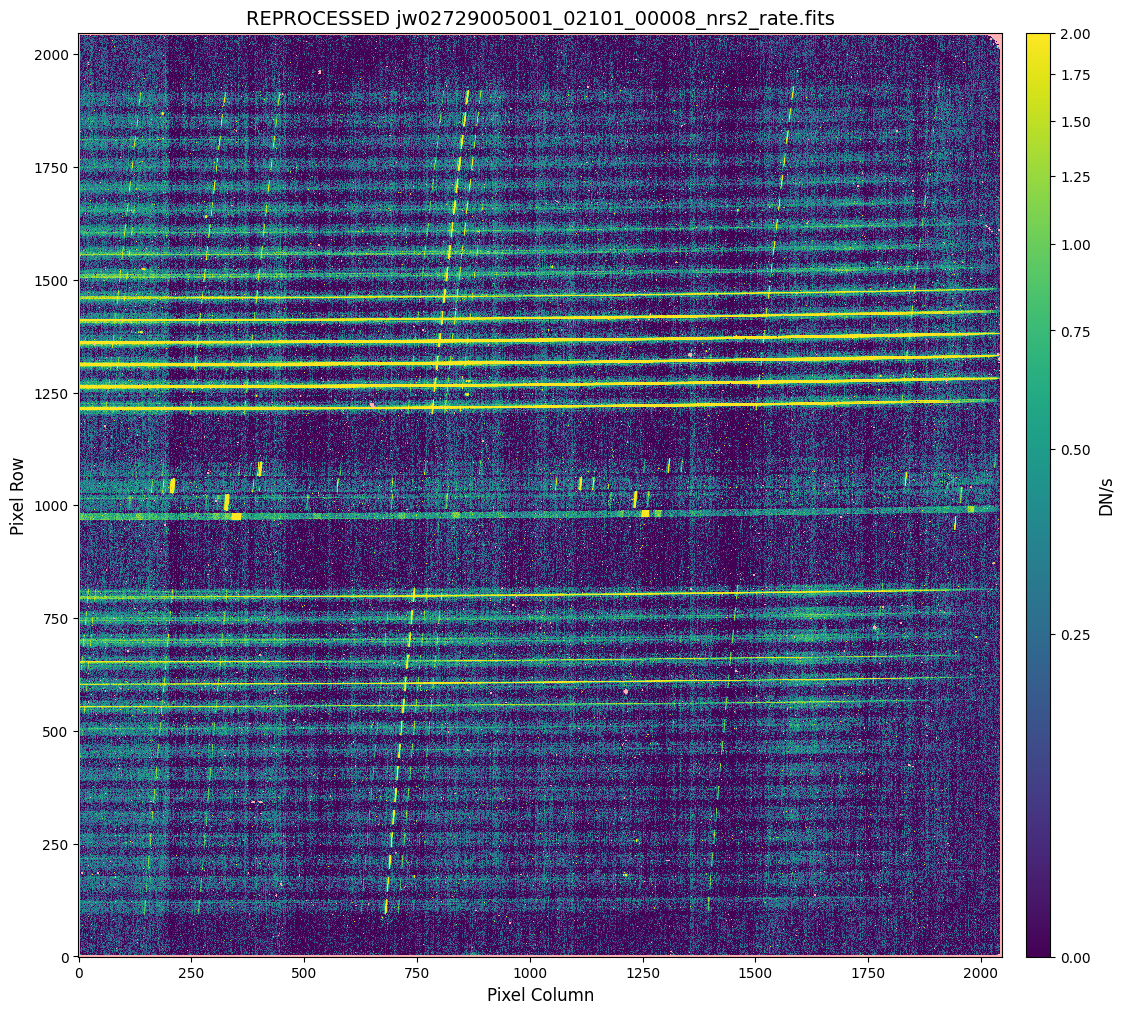

In [44]:
if doviz:
    rate_file = rate_sci[-1]  # Show the last rate file, as an example.
    display_rate(rate_file, vmin=0, vmax=2, scale='asinh',
                 aspect=1, title_prefix='REPROCESSED')  # , extname='dq')

---

### 8.2 Display `Spec3Pipeline` Products
Use Jdaviz [Cubeviz](https://jdaviz.readthedocs.io/en/stable/cubeviz/index.html) and [Specviz](https://jdaviz.readthedocs.io/en/stable/specviz/index.html) to visualize and analyze the Stage 3 combined calibrated spectra. For more information on these visualization tools and plotting capabilities, refer to the official documentation linked.

In [45]:
# Plot the Stage 3 IFU cube with Cubeviz.
if doviz:
    cubeviz = Cubeviz()
    cube = stage3_s3d[0]
    cubeviz.load_data(cube, data_label='Level 3 IFU Product: 3D Cube')
    cubeviz.show()

Application(config='cubeviz', docs_link='https://jdaviz.readthedocs.io/en/v4.2.2/cubeviz/index.html', events=[…

In [46]:
# Plot the Stage 3 1D spectrum with Specviz.
if doviz:
    spec1d = Spectrum1D.read(stage3_x1d[0])
    specviz = Specviz()
    specviz.load_data(spec1d, data_label="Level 3 IFU Product: Extracted 1D Spectrum")
    specviz.show()

Application(config='specviz', docs_link='https://jdaviz.readthedocs.io/en/v4.2.2/specviz/index.html', events=[…

In [47]:
time5 = time.perf_counter()
print(f"Runtime so far: {round((time5-time0)/60.0, 1):0.4f} min")

Runtime so far: 48.5000 min


---

## 9. Modifying the EXTRACT1D Reference File (as needed)

The `extract_1d` step is controlled by a different set of parameters in the EXTRACT1D reference file for extended vs. point source IFU data. 

[Extraction for 3D IFU Data:](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/description.html)

> * For extended sources, rectangular aperture photometry is used, with the entire image extracted and no background subtraction, regardless of what is specified in the reference file or step arguments.
> * For point source data, the extraction aperture is centered at the RA/DEC target location indicated by the header. If the target location is undefined in the header, then the extraction region is the center of the IFU cube.
> * For point sources, a circular extraction aperture is used, along with an optional circular annulus for background extraction and subtraction. The size of the extraction region and the background annulus size varies with wavelength. The extraction-related vectors are found in the ASDF EXTRACT1D reference file. For each element in the wavelength vector, there are three size components: `radius`, `inner_bkg`, and `outer_bkg`. The radius vector sets the extraction size while `inner_bkg` and `outer_bkg` specify the limits of an annular background aperture. 

Below is an example of how to modify the EXTRACT1D reference file for point sources. More information about this file and how to modify it in [extract_1d](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d) and
[Editing JSON reference file](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/reference_files.html#editing-json-reference-file-format-for-non-ifu-data).

<div class="alert alert-block alert-info">

The `ifu_autocen` parameter provides a new method to center on the point sources even if the header information is imperfect due to inaccuracies caused by, e.g., FGS.

</div>

<div class="alert alert-block alert-danger">
    
**Warning**: Currently, there is no aperture correction in place for NIRSpec, so the `radius` parameter **MUST** remain unchanged for point source to ensure proper flux calibration!

</div>

In [48]:
# If you don't know the reference file name this should work.
#extract_1d_ref = Spec3Pipeline().get_reference_file(stage3_s3d, 'extract1d')

refs = api.dump_references(crds_client.get_context_used('jwst'),
                           ['jwst_nirspec_extract1d_0002.asdf'])
extract_1d_ref = refs['jwst_nirspec_extract1d_0002.asdf']

# Construct the modified file name
basename = os.path.basename(extract_1d_ref)[:-5]  # Remove ".asdf"
extract_1d_ref_mod = os.path.join(spec3_dir, f"{basename}_demo.asdf")

print('Original x1d reference file', extract_1d_ref)
print('Modified x1d reference file', extract_1d_ref_mod)

# Open the original ASDF file, modify it, and save the modified version
# in your current directory.
with asdf.open(extract_1d_ref, mode='r') as ref_file:
    # Create a copy of the original tree
    tree = ref_file.tree.copy()

    # Modify the tree.
    tree['data']['radius'] = np.full((2048,), 0.45, dtype='float32')
    tree['data']['inner_bkg'] = np.full((2048,), 1.0, dtype='float32')
    tree['data']['outer_bkg'] = np.full((2048,), 1.2, dtype='float32')

    # Save the modified tree to a new file.
    with asdf.AsdfFile(tree) as new_file:
        new_file.write_to(extract_1d_ref_mod, all_array_storage='inline')

Original x1d reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0002.asdf
Modified x1d reference file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jwst_nirspec_extract1d_0002_demo.asdf


In [49]:
# Check modified file contents.
with asdf.open(extract_1d_ref_mod) as ref_file:
    # Pretty-print the ASDF tree structure.
    pprint(ref_file.tree, depth=4)

{'asdf_library': {'author': 'The ASDF Developers',
                  'homepage': 'http://github.com/asdf-format/asdf',
                  'name': 'asdf',
                  'version': '4.1.0'},
 'data': {'inner_bkg': array([1., 1., 1., ..., 1., 1., 1.], shape=(2048,), dtype=float32),
          'inner_bkg_units': 'arcsec',
          'outer_bkg': array([1.2, 1.2, 1.2, ..., 1.2, 1.2, 1.2], shape=(2048,), dtype=float32),
          'outer_bkg_units': 'arcsec',
          'radius': array([0.45, 0.45, 0.45, ..., 0.45, 0.45, 0.45],
      shape=(2048,), dtype=float32),
          'radius_units': 'arcsec',
          'wavelength': array([0.6       , 0.60229605, 0.6045921 , ..., 5.2954082 , 5.297704  ,
       5.3       ], shape=(2048,), dtype=float32),
          'wavelength_units': 'micron'},
 'history': {'entries': [{'description': 'Update to asdf format as per JIRA '
                                         'issue JP-1730',
                          'time': datetime.datetime(2020, 12, 18, 23, 4, 39)

Now, we re-extract the 1D spectrum by running the `Extract1dStep` and overriding the reference file.

In [50]:
for s3d in stage3_s3d:
    Extract1dStep.call(s3d,
                       save_results=True,
                       output_dir=spec3_dir,
                       output_use_model=True,
                       suffix='x1d_mod',  # Default suffix is `_extract1dstep.fits`
                       use_source_posn=False,
                       ifu_autocen=False,  # Set this to True for isolated point sources
                       override_extract1d=extract_1d_ref_mod)

2025-05-12 20:29:17,928 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2025-05-12 20:29:22,784 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/f290lp_g395h-f290lp_s3d.fits',).


2025-05-12 20:29:22,791 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_mod
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: False
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: False
  save_residual_image: False
  center_xy: None
  ifu_autocen: False
  bkg_sigma_clip: 3.0
  ifu_rfcorr: True
  ifu_set_srctype: None
  ifu_rscale: None
  ifu_covar_scale: 1.0
  soss_atoca: True
  soss_threshold: 0.01
  soss_n_os: 2
  soss_wave_grid_in: None


2025-05-12 20:29:23,000 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jwst_nirspec_extract1d_0002_demo.asdf


2025-05-12 20:29:23,009 - stpipe.Extract1dStep - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0005.asdf


2025-05-12 20:29:23,018 - stpipe.Extract1dStep - INFO - Turning off residual fringe correction because it only works on MIRI MRS data


2025-05-12 20:29:23,019 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2025-05-12 20:29:23,219 - stpipe.Extract1dStep - INFO - Input model does not break out variance information. Passing only generalized errors.


2025-05-12 20:29:45,263 - stpipe.Extract1dStep - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 20:29:45,332 - stpipe.Extract1dStep - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/f290lp_g395h-f290lp_x1d_mod.fits


2025-05-12 20:29:45,333 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2025-05-12 20:29:45,333 - stpipe - INFO - Results used jwst version: 1.18.0


We now plot again the 3D/1D final cube/spectra and showing the original extraction box in red and the new extraction box in black.

2025-05-12 20:29:45,873 - stpipe - WARNING - /tmp/ipykernel_2607/3920203916.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=15)



Radius [arcsec]: 0.45
Inner background [arcsec]: 1.0
Outer background [arcsec]: 1.2


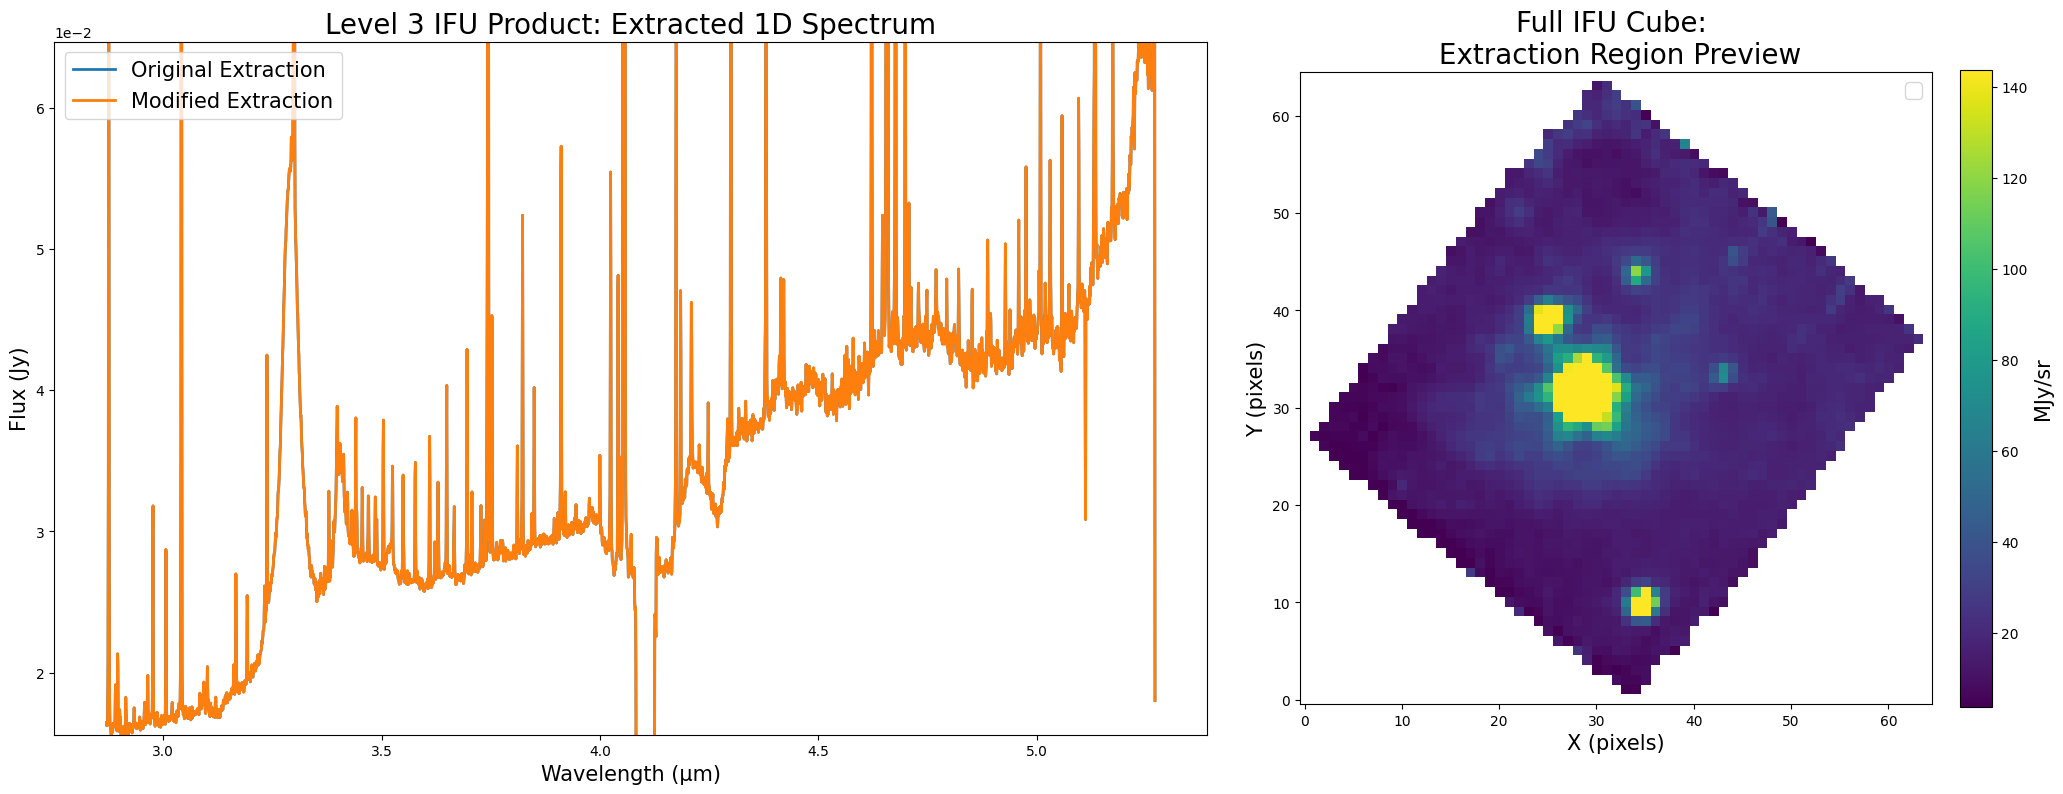

In [51]:
if doviz:
    # Load necessary files
    x1d_file = datamodels.open(stage3_x1d[0])
    x1d_wave = x1d_file.spec[0].spec_table.WAVELENGTH
    x1d_flux = x1d_file.spec[0].spec_table.FLUX

    stage3_x1d_mod = sorted(glob.glob(spec3_dir + '*_x1d_mod.fits'))
    x1d_mod = datamodels.open(stage3_x1d_mod[0])
    x1d_wave_mod = x1d_mod.spec[0].spec_table.WAVELENGTH
    x1d_flux_mod = x1d_mod.spec[0].spec_table.FLUX

    cube_data = datamodels.open(cube).data

    # Setup the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 9),
                                   gridspec_kw={'width_ratios': [5, 3],
                                                'wspace': 0.1})

    # Plot the original and modified spectra
    ax1.plot(x1d_wave, x1d_flux, linewidth=2, label="Original Extraction")
    ax1.plot(x1d_wave_mod, x1d_flux_mod, linewidth=2, label="Modified Extraction")
    ax1.set_xlabel('Wavelength (μm)', fontsize=15)
    ax1.set_ylabel('Flux (Jy)', fontsize=15)
    ax1.set_title("Level 3 IFU Product: Extracted 1D Spectrum", fontsize=20)
    ax1.set_ylim(np.nanpercentile(x1d_flux, 2), np.nanpercentile(x1d_flux, 98))
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, -2))
    ax1.legend(fontsize=15)

    # Plot the IFU cube slice
    slice_mean = np.nanmean(cube_data[400:500, :, :], axis=0)
    vmin = np.nanpercentile(slice_mean, 2)
    vmax = np.nanpercentile(slice_mean, 98)
    if vmin < -vmax:
        vmin = -vmax
    slice_full = ax2.imshow(slice_mean,
                            norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LinearStretch()),
                            origin='lower', cmap='viridis')
    plt.colorbar(slice_full, ax=ax2,
                 fraction=0.046, pad=0.04).set_label('MJy/sr', fontsize=15)

    # Annotate the extraction regions
    with asdf.open(extract_1d_ref_mod, mode='r') as ref_file:
        radii_data = ref_file.tree['data']
        print("Radius [arcsec]:", radii_data['radius'][0])
        print("Inner background [arcsec]:", radii_data['inner_bkg'][0])
        print("Outer background [arcsec]:", radii_data['outer_bkg'][0])

        if x1d_mod.spec[0].source_type == 'POINT':
            x_cen, y_cen = x1d_mod.spec[0].extraction_x, x1d_mod.spec[0].extraction_y
            for label, radius, color in zip(['Radius', 'Inner Background Radius',
                                            'Outer Background Radius'],
                                            ['radius', 'inner_bkg', 'outer_bkg'],
                                            ['black', 'blue', 'red']):
                ax2.add_patch(Circle((x_cen, y_cen), radii_data[radius][0] * 10,
                                     fill=False, color=color, label=label))

        ax2.set_xlabel('X (pixels)', fontsize=15)
        ax2.set_ylabel('Y (pixels)', fontsize=15)
        ax2.set_title("Full IFU Cube: \n Extraction Region Preview", fontsize=20)
        ax2.legend(fontsize=15)

    plt.show()

**The spectra will look identical if the source is extended.**

In [52]:
time5 = time.perf_counter()
print(f"Runtime so far: {round((time5-time0)/60.0, 1):0.4f} min")

Runtime so far: 49.0000 min


---
## Related Notebooks


* [NIRSpec Workaround Notebooks](https://github.com/spacetelescope/jwst-caveat-examples/tree/main/NIRSPEC_General)
* [JDAT: JWST Data Analysis Example Notebooks](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks)

---

<figure>
       <img src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo\" align="right" style="width: 200px"/>
</figure>
   
[Top of Page](#NIRSpec-IFU-Pipeline-Notebook)